<a href="https://colab.research.google.com/github/gupta4327/Rossmann-Sales-Prediction/blob/main/Rossmann_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# <b><u> *Project Title - Sales Prediction : Predicting sales of a major store chain Rossmann*</u></b>

## <b> *Problem Description* </b>

### *Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.*

### *You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.*


### *Dirk Rossmann GmbH (usual: Rossmann) is one of the largest drug store chains in Europe with around 56,200 employees and more than 4000 stores.In 2019 Rossmann had more than €10 billion turnover in Germany, Poland, Hungary, the Czech Republic, Turkey, Albania, Kosovo and Spain.*

### *The product range includes up to 21,700 items and can vary depending on the size of the shop and the location. In addition to drugstore goods with a focus on skin, hair, body, baby and health, Rossmann also offers promotional items ("World of Ideas"), pet food, a photo service and a wide range of natural foods and wines. There is also a perfume range with around 200 commercial brands. Rossmann has 29 private brands with 4600 products (as of 2019). In 1997 the first own brands Babydream, Facelle, Sunozon and Winston were introduced. The best-known Rossmann brands are Isana (skin, hair and body care), Alterra (natural cosmetics), domol (cleaning and laundry detergents) alouette (paper tissues etc).*

In [1]:
!pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 24.0 MB/s eta 0:00:00


In [3]:
#_______________________________________Block 1 _______________________________________________

###importing all the necessary libraries

##for preprocessing
import numpy as np 
import pandas as pd
import math 
from scipy import stats
import datetime 

##for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
import shap

##for transformation
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#importing labelEncoder 
from sklearn.preprocessing import LabelEncoder

##to split data
from sklearn.model_selection import train_test_split

##libraries for linear models and tree models
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.tree import DecisionTreeRegressor
#to visualise decision trees
from sklearn import tree             
from sklearn.tree import export_graphviz  
#for ensembling 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor      
from xgboost import XGBRegressor

##for cross validation and hyperparameter tuning
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

##error metrics
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error 

##to ignore unneccessary warnings
import warnings 
warnings.filterwarnings('ignore') 

In [4]:
#____________________________________Block2__________________________________________

#mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#***Part 1: Loading Datasets***

### ***Loading Rossmann Stores daily sales data***

In [5]:
#_________________________________Block 3_____________________________________________________

#reading a sales data csv file and storing it in sales_data dataframe
file_path = '/content/drive/MyDrive/Datascience/Datasets/'      #path where csv file is stored 
sales_data = pd.read_csv(file_path + 'Rossmann Stores Data.csv')

In [6]:
#_______________________________________Block 4_______________________________________________

#checking for the dimension of the data
sales_data.shape  

(1017209, 9)

*The Sales data have more than 1 Million observations with 9 features*

In [7]:
#__________________________________________Block 5_______________________________________________________

#checking first 15 rows/observations in data 
sales_data.head(15)   

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0       1          5  2015-07-31   5263        555     1      1            0   
1       2          5  2015-07-31   6064        625     1      1            0   
2       3          5  2015-07-31   8314        821     1      1            0   
3       4          5  2015-07-31  13995       1498     1      1            0   
4       5          5  2015-07-31   4822        559     1      1            0   
5       6          5  2015-07-31   5651        589     1      1            0   
6       7          5  2015-07-31  15344       1414     1      1            0   
7       8          5  2015-07-31   8492        833     1      1            0   
8       9          5  2015-07-31   8565        687     1      1            0   
9      10          5  2015-07-31   7185        681     1      1            0   
10     11          5  2015-07-31  10457       1236     1      1            0   
11     12          5  2015-07-31   8959        962     1      1            0   
12     13          5  2015-07-31   8821        568     1      1            0   
13     14          5  2015-07-31   6544        710     1      1            0   
14     15          5  2015-07-31   9191        766     1      1            0   

    SchoolHoliday  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6               1  
7               1  
8               1  
9               1  
10              1  
11              1  
12              0  
13              1  
14              1

### ***Data Dictionary of Sales data***

* *Store - Unique Id of store. We have 1115 stores, thus store Id ranges from 1 -1115*

* *DayOfWeek - Week day on which sale has happened(1-7)*

* *Date - Date on which sales has happened*

* *Sales - How much sale has happened on that particular day*

* *Customers - Number of customers visited to store that particular day*

* *Open - Open indicates whether the store is open on that particular day or not*

 *1 means store open* 

 *0 means store not open*   


* *Promo - If store is running a promo that day or not* 

  *1 means running Promo* 

  *0 means not running promo*


* *SchoolHoliday - Indicates If school holiday effects a store sales that day or not*

  *1 means effect* 

  *0 means no effect*

* *State Holiday - If it's a state holiday on that day and what type of state holiday it is*

  *a = public holiday*

  *b = Easter holiday*

  *c = Christmas* 

  *0 = None*


In [8]:
#___________________________________________Block 6 _________________________________________________

#basic info of dataset 
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


### ***Loading Stores data for each store info***




*This dataset contains an information about the Stores present in Sales data* 

In [9]:
#______________________________________________Block 15_________________________________________________________

#reading a csv file store.csv in stores_data dataframe
stores_data = pd.read_csv(file_path + 'store.csv')

In [10]:
#___________________________________________Block 16_____________________________________________________________

#checking first 5 rows/observations in a data 
stores_data.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [11]:
#__________________________________________Block 17____________________________________________________

#basic info of stores data 
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


### ***Data Dictionary of Stores data***

* *Store - a unique Id for each store*
* *StoreType - differentiates between 4 different store models: a, b, c, d*
* *Assortment - describes an assortment level: a = basic, b = extra, c = extended*
* *CompetitionDistance - distance in meters to the nearest competitor store*
* *CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened*
* *Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating*
* *Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2*
* *PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started a new. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store*

*Data has 1115 observations and each observations corresponds to specific store*

*We can see there are some missing values in stores data. Let's check number of missing values in each column of the stores data*

#***Part 2: Null Values and Duplicates check and their treatment***

### ***Duplicate Checks in Sales and Stores data***

In [12]:
#___________________________Block 7_________________________________________________

#checking if there is any duplicates in sales data observations 
print(' Number of duplicates observation in sales data : ', sales_data.duplicated().sum())

 Number of duplicates observation in sales data :  0


In [13]:
#checking if there is any duplicates in sales data observations 
print(' Number of duplicates observation in stores data : ', stores_data.duplicated().sum())

 Number of duplicates observation in stores data :  0


*Each observation is unique in both the datasets and does not contain any duplicates*

### ***Null Value Checks in Sales and Stores data***

In [14]:
#checking for null values in sales_data
sales_data.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

*There are no any null values in any column of the dataset* 

In [15]:
#_____________________________________________Block 18________________________________________________________

#checking for null values in stores_data
stores_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

*Stores Data contain too many null values*

*Let's explore these variables to find out if the missing values are missing completely at random or there is any relationship between missing values of different variables, so that we can find out best imputation method to treat these null values*



### ***Null Value treatment in Stores data***

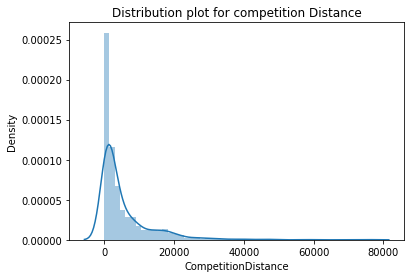

In [16]:
#____________________________________________Block 19_______________________________________________________________

#visualising distribution of competition distance
sns.distplot(stores_data['CompetitionDistance'])    #distribution plot
plt.title('Distribution plot for competition Distance')   #to give title
plt.show()

*Competition distance has outlier values as well, since comptetion distance has only three missing values lets analyse it further*

In [17]:

#checking the rows of stores data where competition distance is null
stores_data[stores_data['CompetitionDistance'].isnull()]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

*Other features related to competitiors also has null values and it seems like there are no competitors for these stores. So we will try to fill competition distance with extreme value 100000 to nullify the effect of competition distance* 

In [18]:
#_____________________________________Block 20__________________________________________________________________________

#replacing null values of comptetion distance with 100000
stores_data['CompetitionDistance'].fillna(100000, inplace = True)

In [19]:
#___________________________________________Block 21______________________________________________________________________

#checking if both comptetionOpenSinceMonth and ComptetionOpenSinceYear have null values for same observations 
len(stores_data[(stores_data['CompetitionOpenSinceMonth'].isnull()) & (stores_data['CompetitionOpenSinceYear'].isnull())])

354

*Every observation that has null value in comptetionsincemonth also have null value in comptetionsinceyear.*

*So for the stores where there is no information when competitors store has set up we have null values there*

*We'll replace these values with zero as there is no possible value for these other than 0*

In [20]:
#___________________________________________Block 22_________________________________________________

#Filling all null values with zero in 'CompetitionOpenSinceMonth' and 'CompetitionOpenSinceYear'
stores_data['CompetitionOpenSinceMonth'].fillna(0, inplace = True )
stores_data['CompetitionOpenSinceYear'].fillna(0, inplace = True)

In [21]:
#______________________________________________Block 23__________________________________________________

#checking unique values in Promo2 feature of stores_data
stores_data['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [22]:
#____________________________________________Block 24___________________________________________________

#checking if promo2sinceweek, promo2sinceyear, promointerval has null values only at the places where promo2 is 0
print('Number of observations where Promo2 is 0 : ',len(stores_data[stores_data['Promo2']==0]))
print('\nNumber of Null values in other features where promo2 is equal to zero : ')
stores_data[stores_data['Promo2']==0].isnull().sum()

Number of observations where Promo2 is 0 :  544

Number of Null values in other features where promo2 is equal to zero : 


Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth      0
CompetitionOpenSinceYear       0
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

*Stores that have value as 0 in promo2(stores that not participated in promotions) have values as null in other three promos related columns*

*It makes sense as well if store is not participating in promo they cannot have promotion data or details*

*So we'll replace these value with zero rather than dropping a column as promotion details might be useful in sales analysis*

In [23]:
#_____________________________________________Block 25___________________________________________________

#replacing null values of promotional details with zero 
promo_columns = ['Promo2SinceWeek','Promo2SinceYear','PromoInterval']
for col in promo_columns:
  stores_data[col].fillna(0, inplace = True)

*As year, month and week cannnot be fractional so ideally it should be int type inspite of float. So we'll convert CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear into int*

In [24]:
#___________________________________________Block 26_____________________________________________________

#datatype conversion
stores_data['CompetitionOpenSinceMonth'] = stores_data['CompetitionOpenSinceMonth'].astype('int64')
stores_data['CompetitionOpenSinceYear'] = stores_data['CompetitionOpenSinceYear'].astype('int64')
stores_data['Promo2SinceWeek'] = stores_data['Promo2SinceWeek'].astype('int64')
stores_data['Promo2SinceYear'] = stores_data['Promo2SinceYear'].astype('int64')

*We are done with null value treatment*

# ***Part 3: Exploratory Data Analysis and feature Engineering***

## ***Value checks of different features and basic feature type and value transformation in sales and stores data***

In [25]:
#________________________________Block 8___________________________________________________

#checking for number of unique values and their counts in some features
print("Number of unique values and there counts in DayofWeek :\n",sales_data['DayOfWeek'].value_counts())
print('--------------------------------------------------------------------------------------------')
print("\nNumber of unique values and there counts in open :\n",sales_data['Open'].value_counts())
print('--------------------------------------------------------------------------------------------')
print("\nNumber of unique values and there counts in Promo :\n",sales_data['Promo'].value_counts())
print('--------------------------------------------------------------------------------------------')
print("\nNumber of unique values and there counts in StateHoliday :\n",sales_data['StateHoliday'].value_counts())
print('--------------------------------------------------------------------------------------------')
print("\nNumber of unique values and there counts in SchoolHoliday :\n",sales_data['SchoolHoliday'].value_counts())

Number of unique values and there counts in DayofWeek :
 5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: DayOfWeek, dtype: int64
--------------------------------------------------------------------------------------------

Number of unique values and there counts in open :
 1    844392
0    172817
Name: Open, dtype: int64
--------------------------------------------------------------------------------------------

Number of unique values and there counts in Promo :
 0    629129
1    388080
Name: Promo, dtype: int64
--------------------------------------------------------------------------------------------

Number of unique values and there counts in StateHoliday :
 0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64
--------------------------------------------------------------------------------------------

Number of unique values and there counts in SchoolHoliday :
 0    835488
1    181721
Name: Schoo

*We see that number of unique values in state holiday, 0, it is appearing twice. Let's check and rectify this*

In [26]:
#______________________________________________Block 9______________________________________

#trying to check if both value of 0 stored in different datatype form(as char and int) and printing its length
print(len(sales_data[sales_data['StateHoliday']==0]))
print(len(sales_data[sales_data['StateHoliday']=='0']))

131072
855087


*Okay so 1 zero stored as character while other as integer. So We'll combine the both and will store both of them as integer*

In [27]:
#_________________________________________Block 10_______________________________________________

#replacing a string character 0 with integer 0 in state holiday column
sales_data['StateHoliday'].replace(to_replace ='0', value = 0, inplace = True)

*Converting a,b,c of stateholiday to public holiday, easter holiday, christmas holiday*

In [28]:
#_______________________________________Block 11________________________________________________________

#function to convert a,b,c of state holidays to meaningful name
def stateholiday_name_conversion(x):
  if x =='a':
    return 'PublicHoliday'
  if x=='b':
    return 'Easter'
  if x=='c':
    return 'Christmas'
  else:
    return 0 

In [29]:
#___________________________________________Block 12__________________________________________________________

#applying above defined function to change the value of stateholiday feature accordingly
sales_data['StateHoliday'] = sales_data['StateHoliday'].apply(stateholiday_name_conversion)

In [30]:
#_____________________________________________Block 13_________________________________________________________

#different values and their count in stateholiday
print('Different state holiday vakues and their counts : ')
sales_data['StateHoliday'].value_counts()

Different state holiday vakues and their counts : 


0                986159
PublicHoliday     20260
Easter             6690
Christmas          4100
Name: StateHoliday, dtype: int64

*State holiday values has been converted to meaningful names and most of them have zero value i.e. no state holiday*

*Converting a,b,c of assortment to basic, extra, extended respectively*

In [31]:
#_________________________________________Block 28___________________________________________________

#function to replace a,b,c in assortment with real meaningful names
def assortment_name_conversion(x):
  if x =='a':
    return 'Basic'
  if x=='b':
    return 'Extra'
  if x=='c':
    return 'Extended'
  

In [32]:
#____________________________________________Block 29_______________________________________________________

#applying above defined function to change the values of assortment feature accordingly
stores_data['Assortment'] = stores_data['Assortment'].apply(assortment_name_conversion)

In [33]:
#_____________________________________________Block 14_____________________________________________________________

#checking for no. of unique stores in sales data
print('Number of unique stores in sales data : ',sales_data['Store'].nunique())

Number of unique stores in sales data :  1115


*So we have data for all 1115 unique stores in our sales data*




*As the Date of sales currently have a data type of object/String so we will convert it into datetime object*

In [34]:
#converting date of sales from object/string type to datetime object
sales_data['Date'] = pd.to_datetime(sales_data['Date'])

## ***Feature extraction and engineering in Stores Data***

### *Creating Promo2SinceDate Feature*

*Creating a new feature promo2sincedate from features promo2sinceweek and promo2sinceyear that will show the date from which stores has started taking part in promo2 promotional activity.*

*Also we will consider and assume monday as a day of week from which promo2 has started in week* 

In [35]:
#creating a feature that shows from which date store has started participating in promotional activities(promo2)
def promo2date(promo2week, promo2year):
   #if promo2 year and week is not 0 then only it is convertyed into date
   if promo2week != 0 and promo2year != 0:
     #preparing a string that will be parsed to convert week and year into date. We have taken a date from first day of a week that is monday 
     d = str(promo2year)+'-'+str(promo2week)+'-1'
     #converting string of year-week-firstdayofweek into calendar date by converftingh into datetime object 
     promo2_date = datetime.datetime.strptime(d,"%Y-%W-%w")
     #returning date in date time object
     return promo2_date
   return 0

In [36]:
#applying promo2date function
stores_data['Promo2SinceDate'] = stores_data.apply(lambda x: promo2date(x['Promo2SinceWeek'],x['Promo2SinceYear']), axis=1)

### *Creating CompetitionOpenSinceDate Feature*

*Creating a new feature compopensincedate from features CompetitionOpenSinceMonth and CompetitionOpenSinceYear that will show the date from which stores has started taking part in promo2 promotional activity.*

*Also we will consider and assume 1st day of the month as a day when competition store is established* 

In [37]:
#creating a feature that shows from which date from which competitor store is there as only month is given we are considering it from day 1 of month 
def comp_date(compmonth, compyear):
  #if competitionopensincemonth and comptetionsinceopenyear is not 0 only then only it is possible to get a date 
   if compmonth != 0 and compyear != 0:
     #converting string of year-month-date to date wth type as datetime
     d = str(compyear)+'-'+str(compmonth)+'-1'
      #converting string of year-month-firstdayofmonth into calendar date by converftingh into datetime object
     comp_date = datetime.datetime.strptime(d,"%Y-%m-%d")
     #returning date in date time object
     return comp_date
   return 0

In [38]:
#applying function comp_date
stores_data['CompetitionOpenSinceDate'] = stores_data.apply(lambda x : comp_date(x['CompetitionOpenSinceMonth'],x['CompetitionOpenSinceYear']), axis=1)

### *Creating a new features average sales per day and average customer visit per day on each store using Sales data*

In [39]:
#we will create another variable average sale and average customer for each store that will act as a new feature to our model

#average_customers 
temp = []
#grouping over stores and taking a mean of customers and appending average value of custometrs for each stores   
for i in sales_data[sales_data['Open']==1].groupby('Store')[["Customers"]].mean()["Customers"]:
  temp.append(i)

#customer visit count for each store 
stores_data['avg_cust_visit_per_day'] = temp 

#average_sales 
temp = []
#grouping over stores and taking a mean of sales and appending average value of sales for each stores   
for i in sales_data[sales_data['Open']==1].groupby('Store')[["Sales"]].mean()["Sales"]:
  temp.append(i)

#average sales for each stores 
stores_data['avg_sales_per_day'] = temp 

#average sales per customer
stores_data['avg_sales_per_customer'] = stores_data['avg_sales_per_day']/stores_data['avg_cust_visit_per_day']

In [40]:
#head command to visualise 5 rows
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   int64  
 5   CompetitionOpenSinceYear   1115 non-null   int64  
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   int64  
 8   Promo2SinceYear            1115 non-null   int64  
 9   PromoInterval              1115 non-null   object 
 10  Promo2SinceDate            1115 non-null   object 
 11  CompetitionOpenSinceDate   1115 non-null   object 
 12  avg_cust_visit_per_day     1115 non-null   float64
 13  avg_sales_per_day          1115 non-null   float

## ***Merging stores and historical sales data***

In [41]:
#_____________________________________________Bock 30_____________________________________________________

#merging stores_data and sales_data on store id and creating train data
rossman_stores_data = pd.merge(sales_data,stores_data, how = 'inner', on = 'Store')

In [42]:
#info of merged dataset
rossman_stores_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

In [43]:
#_____________________________________________Block 31_________________________________________________________

#checking first 5 rows of merged data 
rossman_stores_data.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType  ... CompetitionOpenSinceYear  Promo2  \
0              1         c  ...                     2008       0   
1              1         c  ...                     2008       0   
2              1         c  ...                     2008       0   
3              1         c  ...                     2008       0   
4              1         c  ...                     2008       0   

   Promo2SinceWeek  Promo2SinceYear  PromoInterval  Promo2SinceDate  \
0                0                0              0                0   
1                0                0              0                0   
2                0                0              0                0   
3                0                0              0                0   
4                0                0              0                0   

   CompetitionOpenSinceDate avg_cust_visit_per_day avg_sales_per_day  \
0       2008-09-01 00:00:00             564.049936       4759.096031   
1       2008-09-01 00:00:00             564.049936       4759.096031   
2       2008-09-01 00:00:00             564.049936       4759.096031   
3       2008-09-01 00:00:00             564.049936       4759.096031   
4       2008-09-01 00:00:00             564.049936       4759.096031   

  avg_sales_per_customer  
0               8.437366  
1               8.437366  
2               8.437366  
3               8.437366  
4               8.437366  

[5 rows x 23 columns]

In [44]:
rossman_stores_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Promo2SinceDate',
       'CompetitionOpenSinceDate', 'avg_cust_visit_per_day',
       'avg_sales_per_day', 'avg_sales_per_customer'],
      dtype='object')

In [45]:
#____________________________________________________Block 32________________________________________________

#checking for shape of merged data
rossman_stores_data.shape

(1017209, 23)

*Date feature analysis*

In [46]:
#_______________________________________________Block 33______________________________________________________

#checking for number of unique values in date columns
rossman_stores_data['Date'].nunique()

942

*We have 942 unique dates in our data so ideally we should have 1115 stores data for all these 942 days thus total number of rows in data should be 1115 X 942 i.e. 1050330 rows. But we have 1017209 rows in our data so nearly 33,121 rows are less in our data. Let's analyze a bit more why and how this data is missing*



##***Analysis on Missing Sales data for few of the stores***

In [47]:
#grouping by store and aggregating count of date to check for the number of days each store operating and applying value_counts to see no. of stores operating for same days 
stores_dates = rossman_stores_data.groupby('Store').aggregate({'Date':'count'}).value_counts().reset_index()
#naming the columns of the store_dates dataframe
stores_dates.columns = ['DaysStoreOperating', 'NumberOfStoresOperating']
stores_dates

DaysStoreOperating  NumberOfStoresOperating
0                 942                      934
1                 758                      180
2                 941                        1

*Out of total 1115 stores 934 stores that are operating on all the 942 days in our data whereas we can see that 180 stores are only operating on 758 days inspite of 942 days and a single that is there for 941 dates inspite of 942.*

*Let's check these stores and the time period for which they are not operating* 

Text(0.5, 0, 'Date')

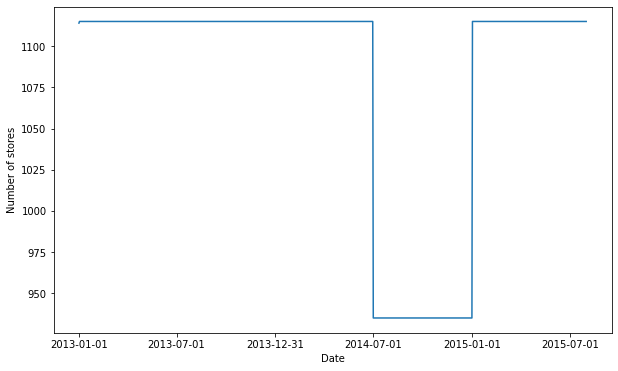

In [48]:
#figure and axis of canvas
fig, ax = plt.subplots(1,1,figsize = (10,6))
#grouping data by date and storing the count of stores operating on that date
a = rossman_stores_data.groupby('Date').aggregate({'Store':'count'}).reset_index()
#plotting a line plot with date and store counts
ax.plot(a['Date'], a['Store'])
#xlabels
x_ticks = ['2013-01-01','2013-07-01','2013-12-31','2014-07-01','2015-01-01','2015-07-01']
#converting x_ticks to date format and setting it on x labels
for i in range(len(x_ticks)):
  #datetime conversion 
  x_ticks[i] = datetime.datetime.strptime(x_ticks[i], '%Y-%m-%d')
ax.set_xticks(x_ticks)
ax.set_ylabel('Number of stores')
ax.set_xlabel('Date')

*From above graph we can see that between a continuous span from 01-07-2014 to 31-12-2014 lesser number of stores data is there and count of missing stores throughout this period seems to be constant. Lets try to find count and store id of such stores*  

In [49]:
#checking the number of stores operating on different dates
print('Stores operating on 30th June 2014 : ',len(rossman_stores_data[rossman_stores_data['Date']=='2014-06-30']))
print('Stores operating on 01st July 2014 : ',len(rossman_stores_data[rossman_stores_data['Date']=='2014-07-01']))
print('Stores operating on 31st December 2014 : ',len(rossman_stores_data[rossman_stores_data['Date']=='2014-12-31']))
print('Stores operating on 01st Januarary 2015 : ',len(rossman_stores_data[rossman_stores_data['Date']=='2015-01-01']))

Stores operating on 30th June 2014 :  1115
Stores operating on 01st July 2014 :  935
Stores operating on 31st December 2014 :  935
Stores operating on 01st Januarary 2015 :  1115


*We have 935 stores operating from 01st July 2014 to 31st December 2014. Lets check what are the store ID's of store closed in this period and also whether the stores are same only throughout the span*

In [50]:
'''This block will extarct the data from rossman_stores_data that have a dates between 1-July-2014 and 31-Dec-2014'''

#converting it to date
dates = rossman_stores_data['Date']

#creating start date and end date for thresholding the limits between july 2014 and Dec 2014
start_date = datetime.date(2014,7,1)
end_date = datetime.date(2014,12,31)

#creating list to store true and false if date is in range between start date and end date then true else false 
check_list = []
#looping over the dates extracted from rossman_Sales_data
for i in dates:
  #if date is in range between start date and end date return true else false  
  if i >= start_date and i <= end_date:
    check_list.append(True)
  else:
    check_list.append(False)  

#seperating rows with these date ranges
july_dec_14 = rossman_stores_data[check_list]

#cheking unique store count in this time span(between July 2014 - 31 Dec 2014)
print('Number of Unique stores are operating from July 2014 and December 2014 : ', len(july_dec_14['Store'].unique()))

Number of Unique stores are operating from July 2014 and December 2014 :  935


*We have total 935 unique stores operating in this time span and also we have 935 stores operating everday in this span so its clear that same stores are operating in this time period and for rest 180 stores there is no data* 

In [51]:
'''This block will extract the stores that are not operating between July 2014 to December 2014'''

#total unique stores in our data
all_stores = set(rossman_stores_data['Store'].unique())

#total unique stores operating between July 2014 and December 2014
stores_btwn_julandDec14  = set(july_dec_14['Store'].unique())

#removing the stores that are operating between july 14 and dec 14 from total stores data to have non operating stores between july and dec14
stores_not_operating = list(all_stores-stores_btwn_julandDec14)
print('Stores not operating between July 2014 and December 31 : ')
print(stores_not_operating)

Stores not operating between July 2014 and December 31 : 
[512, 514, 1027, 518, 522, 13, 1038, 1041, 20, 22, 534, 1049, 539, 540, 542, 32, 1056, 547, 36, 41, 1065, 555, 1067, 46, 51, 52, 1080, 58, 571, 573, 575, 1092, 1094, 72, 587, 76, 1102, 1104, 81, 1107, 1109, 598, 89, 604, 99, 100, 611, 612, 619, 108, 620, 113, 115, 629, 633, 636, 637, 638, 127, 129, 132, 644, 646, 136, 137, 650, 139, 144, 145, 660, 149, 155, 669, 670, 159, 671, 164, 165, 677, 172, 684, 174, 181, 694, 183, 186, 701, 190, 191, 192, 702, 706, 710, 711, 712, 204, 716, 719, 215, 218, 736, 739, 231, 744, 750, 243, 766, 258, 771, 263, 775, 778, 275, 277, 279, 283, 284, 797, 287, 288, 804, 805, 806, 298, 815, 306, 820, 825, 317, 842, 851, 342, 345, 858, 859, 348, 365, 879, 884, 890, 893, 385, 900, 902, 903, 904, 909, 399, 915, 407, 919, 920, 412, 413, 420, 932, 427, 428, 429, 430, 941, 434, 952, 457, 974, 977, 471, 477, 989, 485, 1000, 490, 492, 1004, 1009, 498, 500, 501, 1012, 1019]


*We got the stores that are not operating between 01-July-2014 and 31-Dec-2014. We don't know the exact reason but as informed in problem statement that some stores are closed for refurbishment so these might be the stores that are closed for refurbishment*

##***Analysis of Open and Close Stores Data***

In [52]:
#_____________________________________________________Block 36______________________________________________________

#checking value counts of open feature 
rossman_stores_data['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [53]:
#____________________________________________________Block 37__________________________________________________________

#creating two subframes one contains a data for store that is open and other one contains data when store is closed 
close_store_data = rossman_stores_data[rossman_stores_data['Open']==0]
open_store_data = rossman_stores_data[rossman_stores_data['Open']==1]

*Lets analyse close_store_data first*

In [54]:
#___________________________________________________Block 38___________________________________________________________

#checking length of close store_data and values of sales and customers in data correspondingly
print('Length of close store data : ', len(close_store_data))
print('No. of unique values and their counts in sales : \n', close_store_data['Sales'].value_counts())
print('No. of unique values and their counts in customers : \n', close_store_data['Customers'].value_counts())

Length of close store data :  172817
No. of unique values and their counts in sales : 
 0    172817
Name: Sales, dtype: int64
No. of unique values and their counts in customers : 
 0    172817
Name: Customers, dtype: int64


*Okay so when a store is closed sales and number of customers is zero. Well that is already comprehensible*

*Lets check for state holiday in close store data to know whether stores are mostly closed on state holidays or not* 

In [55]:
#______________________________________________Block 39_____________________________________________________________________

#to check if most of the state holidays are under close_store_data
print("Number of state holidays in a complete train data:", len(rossman_stores_data[rossman_stores_data['StateHoliday']!=0]))
print("Number of state holidays in close_store_data:",len(close_store_data[close_store_data['StateHoliday']!=0]))

Number of state holidays in a complete train data: 31050
Number of state holidays in close_store_data: 30140


*We can observe that stores are closed on most of the state holidays or most of the stores are closed on state holidays except few*

*Let's analyse open_store_data*

In [56]:
#_____________________________________Block 40____________________________________________________________________

#to check if there are observations for which store is open but sales is zero
print('Number of observations for which store is open but sales is zero :',len(open_store_data[open_store_data['Sales']==0]))

Number of observations for which store is open but sales is zero : 54


*So, we have 54 observation in our data where store is open but still sales is zero.*

*Let's try to find possible reason behind it*

In [57]:
#________________________________________Block 41________________________________________________________________

#to check customer visit for the stores which are open but have 0 sales
open_store_data[open_store_data['Sales']==0][['Customers','Sales']]

Customers  Sales
22589            0      0
22590            0      0
25212            0      0
25213            0      0
25214            0      0
51491            0      0
92570            0      0
92582            0      0
205303           0      0
210424           0      0
215530           0      0
235476           0      0
274736           0      0
297110           0      0
308819           0      0
308820           0      0
321411           0      0
324624           0      0
331720           0      0
331721           0      0
352576           0      0
356674           0      0
499043           0      0
537239           0      0
567892           0      0
567893           0      0
601963           0      0
604061           0      0
606010           0      0
606011           0      0
613301           0      0
620396           0      0
636348           0      0
637900           0      0
644401           0      0
694235           0      0
760375           0      0
760376           0      0
774487           0      0
803779           0      0
808305           0      0
842281           0      0
844494           0      0
864013           5      0
884745           0      0
896163           0      0
896164           0      0
898930           0      0
927132           0      0
927133           0      0
947634           0      0
947635           0      0
1003330          0      0
1003331          3      0

*okay, so we found that stores which are open but have zero sales are the ones which have 0 customers on these particular days except two which have 5 and 3 customers which is also very low number. So, possible reason for these stores to have 0 sales is no customer visit or very low no. of customers visit*

*Stores that have open = 0(stores that are closed) and stores having zero sales won't be useful for our sales analysis as they have 0 sales due to closed store or no customer visit*

*Considering the data where open = 1 and also drop open variable as it has constant value of 1 so it will be of no use for further analysis*

In [58]:
#_________________________________________Block 42__________________________________________________________

#keeping all those columns where sales > 0 and open = 1
rossman_stores_data = rossman_stores_data[(rossman_stores_data['Open']==1) & (rossman_stores_data['Sales']>0)]
#dropping open variable
rossman_stores_data.drop(columns=['Open'], inplace= True)

In [59]:
#_____________________________________ Block 43_______________________________________________________

#info on data
rossman_stores_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Promo                      844338 non-null  int64         
 6   StateHoliday               844338 non-null  object        
 7   SchoolHoliday              844338 non-null  int64         
 8   StoreType                  844338 non-null  object        
 9   Assortment                 844338 non-null  object        
 10  CompetitionDistance        844338 non-null  float64       
 11  CompetitionOpenSinceMonth  844338 non-null  int64  

##***Customer Analysis***

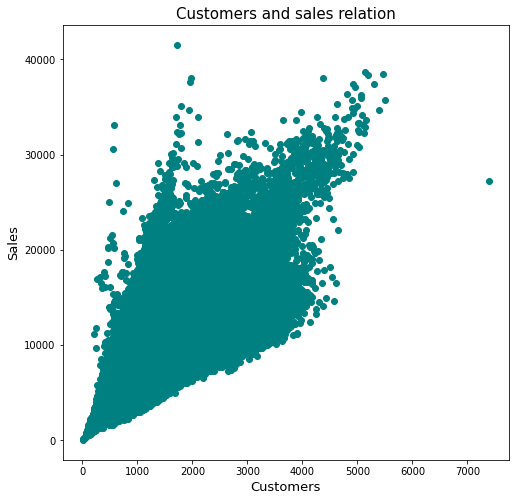

In [60]:
#___________________________________Block 44_____________________________________________________

#visualising relationship between customer and sales
fig1 = plt.figure(figsize=(8,8))   #defining figure
ax = fig1.gca()   #to get current axes
#customer and sales relation scatter plot
plt.scatter(rossman_stores_data['Customers'], rossman_stores_data['Sales'],color='teal')   #scatter plot
plt.xlabel('Customers',fontsize=13)   #labelling x-axis
plt.ylabel('Sales',fontsize=13)      #labelling y-axis
plt.title('Customers and sales relation',fontsize=15)  #title for graph
plt.show()

*Relation seems to be linear between customers and sales but seems to have high variance*

*Also Graph  helps us conclude that although there are some stores that have a same customer visit still some have higher sales and some have lower sales*

*It can be dependable on many factors like competitors distance, promo,etc*



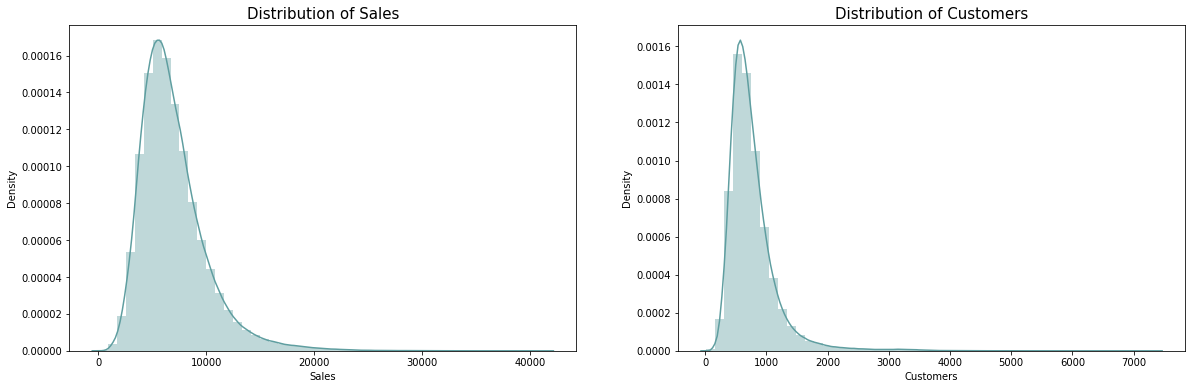

In [61]:
#___________________________________________Block 45__________________________________________________________

#visualising distribution of sales and customers

#defining figure and initialising axes
fig,axes= plt.subplots(1,2,figsize=(20,6))     

#distribution plot of sales
sns.distplot(rossman_stores_data['Sales'],color='cadetblue',ax=axes[0])  
axes[0].set_title('Distribution of Sales',fontsize=15)  #title for plot

#distribution plot of customers
sns.distplot(rossman_stores_data['Customers'],color='cadetblue',ax=axes[1])  
axes[1].set_title('Distribution of Customers',fontsize=15) 
plt.show()

*Most of the stores are having sales between 3000 and 10000 and customers between 500 and 1000  with few of them having below and above that range* 

*Sales have outliers but these outliers are getting defined by customers, higher the customers visit greater the sales*

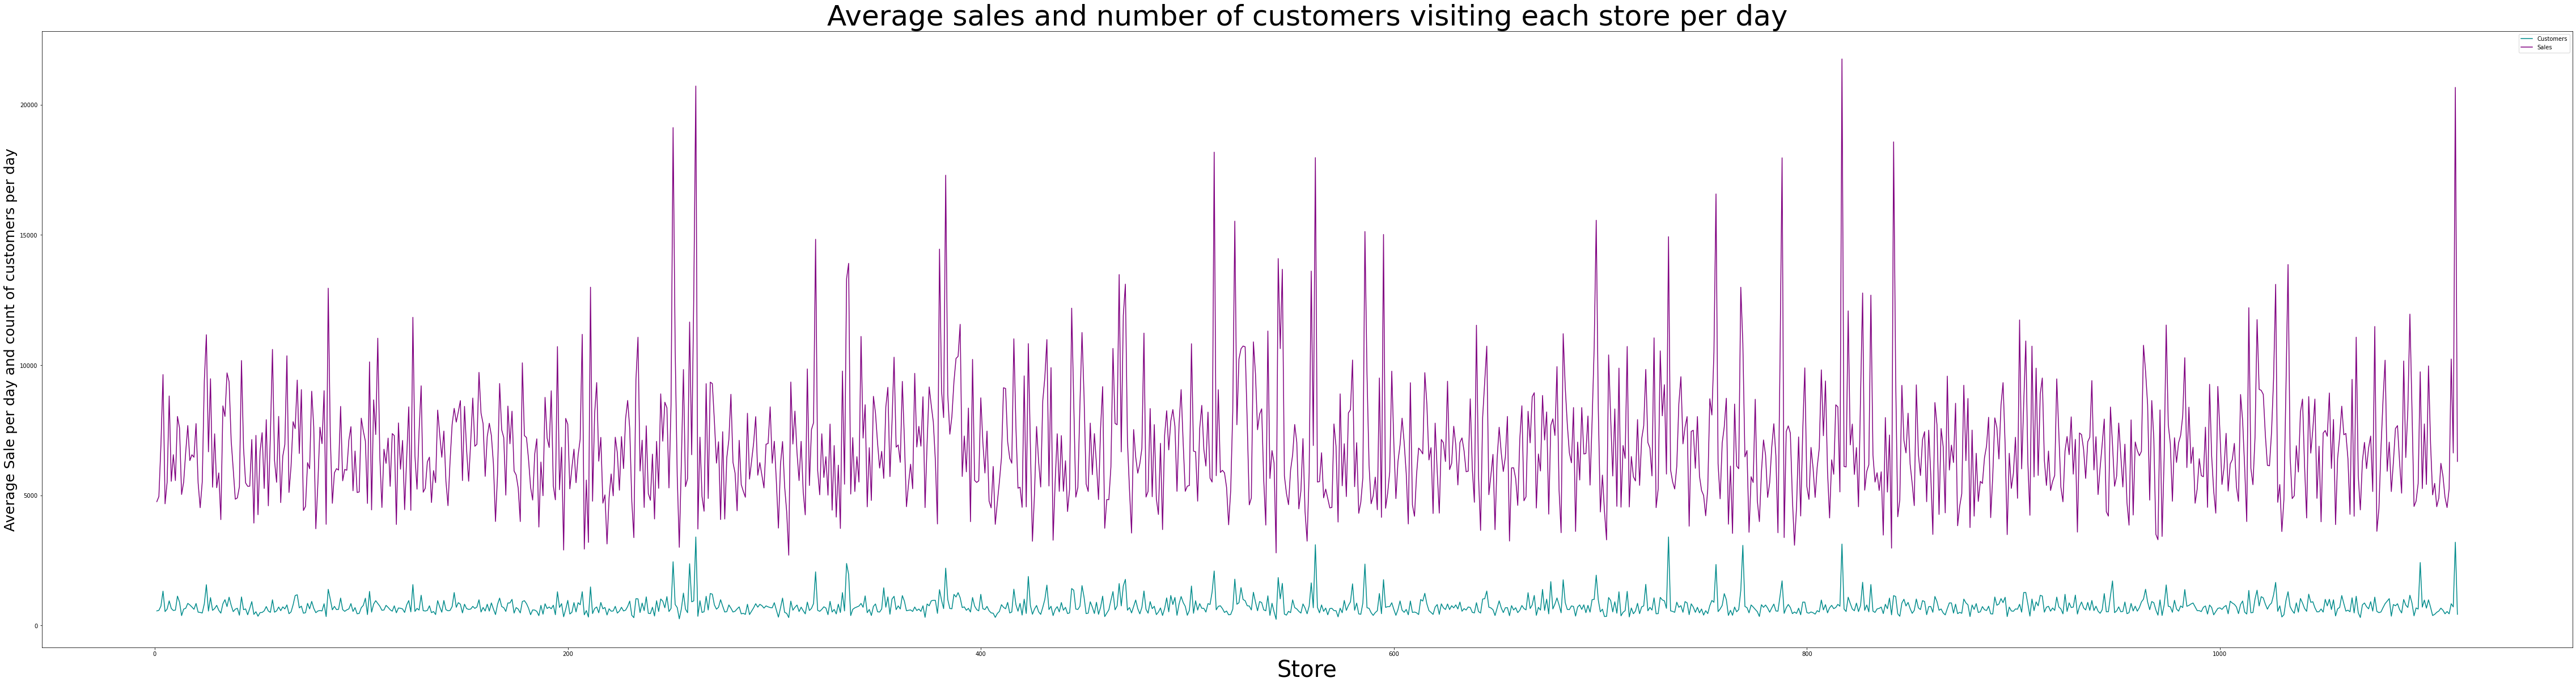

In [62]:
#__________________________________________Block 46_______________________________________________________

#line plot for average sale and customer visit per day of each store
fig = plt.figure(figsize=(80,20))
axs = fig.gca()  #to get current axes
#average sales and average customers visit in each store of a data 
rossman_stores_data.groupby('Store').agg({'Customers':'mean','Sales':'mean'}).plot( color=['darkcyan','purple'],ax =axs)  #line plot 
plt.title('Average sales and number of customers visiting each store per day',fontsize=50)  #title for plot
plt.xlabel('Store',fontsize=40)   #label on X-axis for the plot
plt.ylabel('Average Sale per day and count of customers per day',fontsize=25)  #label on y-axis for the plot
plt.show()

*From above plot also we can convict that yes stores with higher customers have higher sales*

## ***Date related analysis (Year,month, date of month , day of week, week of year)*** 

### *Segregating a year, month and date from dates*

In [63]:
#________________________________________________Block 34______________________________________________________________

#segregating month from Date Column and storing it in month variable
rossman_stores_data['month'] = pd.DatetimeIndex(rossman_stores_data['Date']).month

#segregating year from Date Column and storing it in year variable
rossman_stores_data['year'] = pd.DatetimeIndex(rossman_stores_data['Date']).year

#segregating day of month from Date Column and storing it in DateOfMonth variable
rossman_stores_data['DateOfMonth'] = pd.DatetimeIndex(rossman_stores_data['Date']).day

#segregating number of week of year(out of 52 weeks) from Date Column and storing it in WeekofYear variable
rossman_stores_data['WeekofYear'] = pd.DatetimeIndex(rossman_stores_data['Date']).week

In [64]:
#____________________________________________Block 35___________________________________________________________________

#checking first 5 rows of data 
pd.set_option('max_columns', None)    #to show all the columns of the dataframe
rossman_stores_data.head()

Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555      1            0   
1      1          4 2015-07-30   5020        546      1            0   
2      1          3 2015-07-29   4782        523      1            0   
3      1          2 2015-07-28   5011        560      1            0   
4      1          1 2015-07-27   6102        612      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c      Basic               1270.0   
1              1         c      Basic               1270.0   
2              1         c      Basic               1270.0   
3              1         c      Basic               1270.0   
4              1         c      Basic               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                          9                      2008       0   
1                          9                      2008       0   
2                          9                      2008       0   
3                          9                      2008       0   
4                          9                      2008       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval Promo2SinceDate  \
0                0                0             0               0   
1                0                0             0               0   
2                0                0             0               0   
3                0                0             0               0   
4                0                0             0               0   

  CompetitionOpenSinceDate  avg_cust_visit_per_day  avg_sales_per_day  \
0      2008-09-01 00:00:00              564.049936        4759.096031   
1      2008-09-01 00:00:00              564.049936        4759.096031   
2      2008-09-01 00:00:00              564.049936        4759.096031   
3      2008-09-01 00:00:00              564.049936        4759.096031   
4      2008-09-01 00:00:00              564.049936        4759.096031   

   avg_sales_per_customer  month  year  DateOfMonth  WeekofYear  
0                8.437366      7  2015           31          31  
1                8.437366      7  2015           30          31  
2                8.437366      7  2015           29          31  
3                8.437366      7  2015           28          31  
4                8.437366      7  2015           27          31

### *Analysis of Date extracted features*

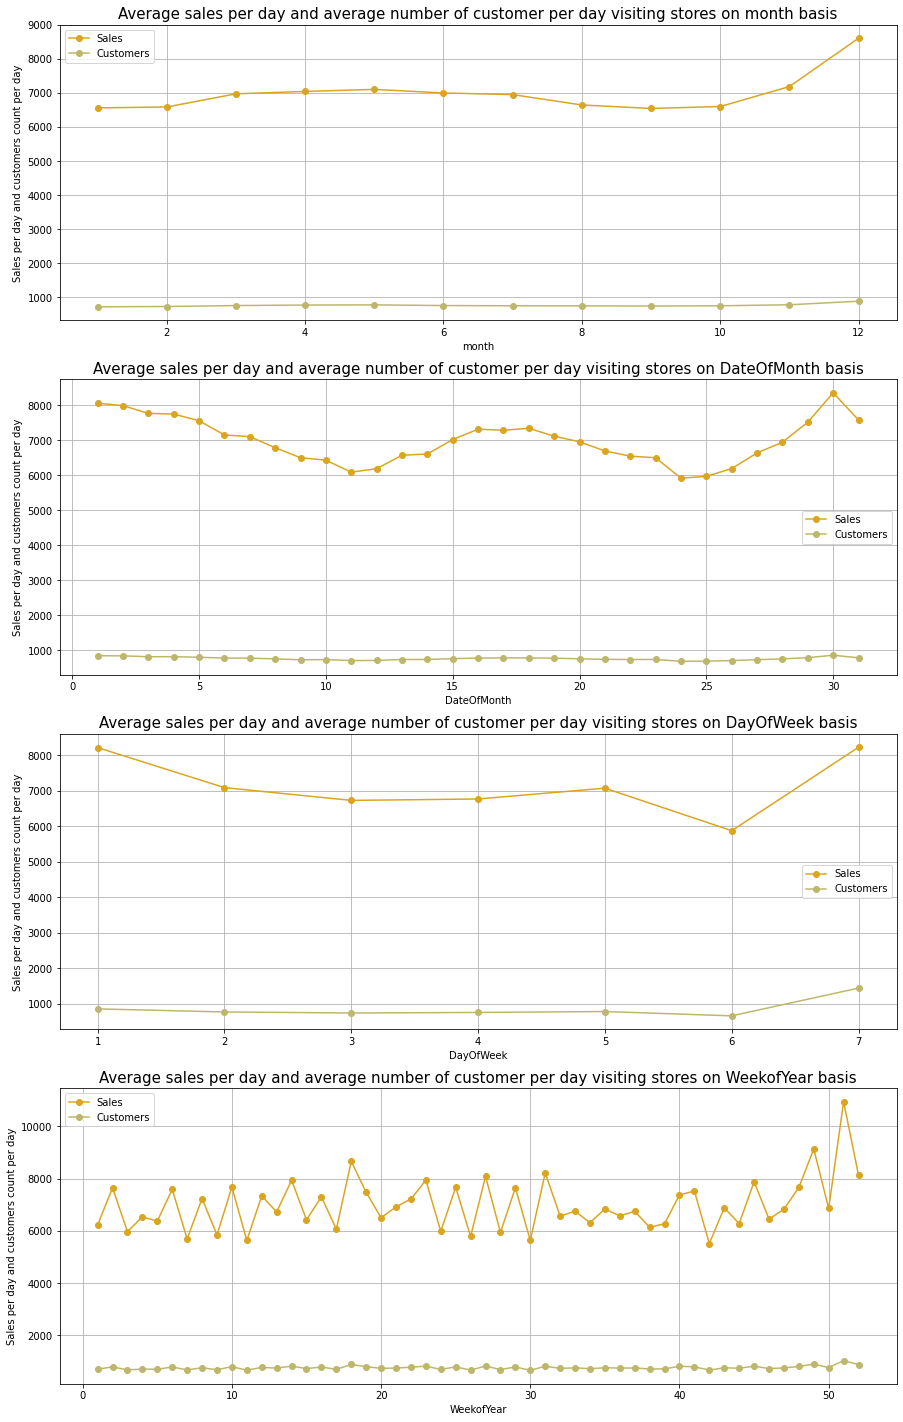

In [65]:
#______________________________________Block 47_____________________________________________________

#visualising average sales and average no. of customers visiting the store on various basis(monthly,dayof week,week of year and date of month)

#initialising figure canvas
fig,axs = plt.subplots(4,1, figsize=(15,25)) 

#storing all columns related to Date data in date_feature list
date_features = ['month','DateOfMonth',"DayOfWeek",'WeekofYear' ]  

#line plot for analyzing the trend of sales and customers with the date features
for i in range(4):
  
  #grouping by date feature and aggregating mean for sales and customers
  dates_graph = rossman_stores_data.groupby(date_features[i]).agg({'Sales':'mean','Customers':'mean'}).plot(marker = 'o', ax =axs[i],
                                                                                                     color=['goldenrod','darkkhaki'])
  dates_graph.set_ylabel('Sales per day and customers count per day')  #setting y label 

  #setting title
  dates_graph.set_title('Average sales per day and average number of customer per day visiting stores on '+ date_features[i] +' basis',fontsize=15)
  dates_graph.grid()  # to show grid lines for ease of comprehending graphs


*In Regards to month sales and customers graph we can depict that number of  customers visiting store per day is almost similar every month and for sales per day there is a quite surge in daily sales in 12th month which is also a festive month(christmas and New Year) and week of the year graphs gives a prove of that as well (you can see a surge in 51st week)*

*In Regards to Date of month sales and customers graph there is no any such great depiction but still customers visiting store and sales is higher in starting and ending of months*

*In Regards to day of week sales and customers graph we can see surge in sales on Monday and Sunday and also number of  customers visiting store is higher on sundays and almost similar for other weekdays*


In [66]:
#_______________________________________________Block 48__________________________________________

#to find average number of stores operating each day of week 

total_stores_eachweekday= list(rossman_stores_data['DayOfWeek'].value_counts())  #taking counts of no. of observations on weekday basis
weekday_count = list(rossman_stores_data.groupby(['DayOfWeek']).agg({'Date':'nunique'}).values)  #getting unique dates for each weekday from data

stores_op_each_dayofweek=[]   #empty list to store average no. of stores operating on each weekday
for i in range(len(total_stores_eachweekday)):
  stores_op_each_dayofweek.append(int(total_stores_eachweekday[i]/weekday_count[i]))

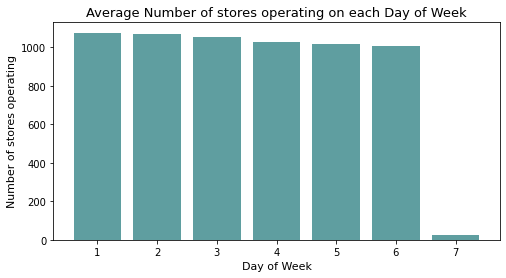

In [67]:
#___________________________________________Block 49____________________________________

#plotting the data for average no. of stores operating on each day of week

plt.rcParams['figure.figsize']=(8,4)   #defining figure 
plt.bar(x = [1,2,3,4,5,6,7], height= stores_op_each_dayofweek,color='cadetblue')  #bar plot
plt.xlabel('Day of Week',fontsize=11) #to show x-axis label on the plot
plt.ylabel('Number of stores operating',fontsize=11)   #to show y-axis label on the plot
plt.title('Average Number of stores operating on each Day of Week',fontsize=13)  #to show title of the plot
plt.show()

*We can simply see that where on other weekdays near to 1000 or above stores are opened and operating whereas on sundays on an average less than 50 stores are opened and thus resulting in increasing sale value for store on that day* 

*Most of the stores are closed on sundays thats why the rare ones that are operating on sunday are getting surge in sales on sundays*

*And the same reason as most of stores are closed on sundays then on next day of opening that is on monday they are getting bit higher sales*

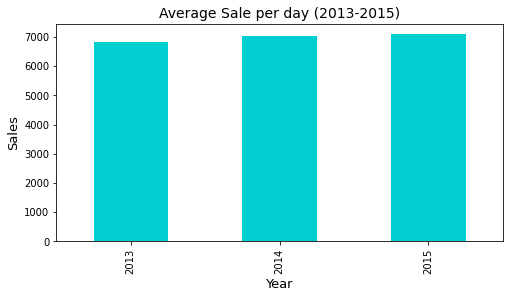

In [68]:
#______________________________________________BLOCK 50_________________________________________________

#visualising average sale stores made each year 
axs = rossman_stores_data.groupby('year')['Sales'].mean().plot.bar(color='darkturquoise')  #to find average sales made by stores each year  
axs.set_xlabel('Year',fontsize=13)   #setting xlabel
axs.set_ylabel('Sales',fontsize=13)   #setting ylabel
axs.set_title('Average Sale per day (2013-2015)',fontsize=14)  #setting title
plt.show()

*Company Sales are growing at a slow pace every year. In 2013 on an average stores were having sales less than 7000 per day whereas in 2015 it was more than 7000 per day*



## ***Promotional Analysis***

*Let's move over the promos and let's see how it is affecting sales*

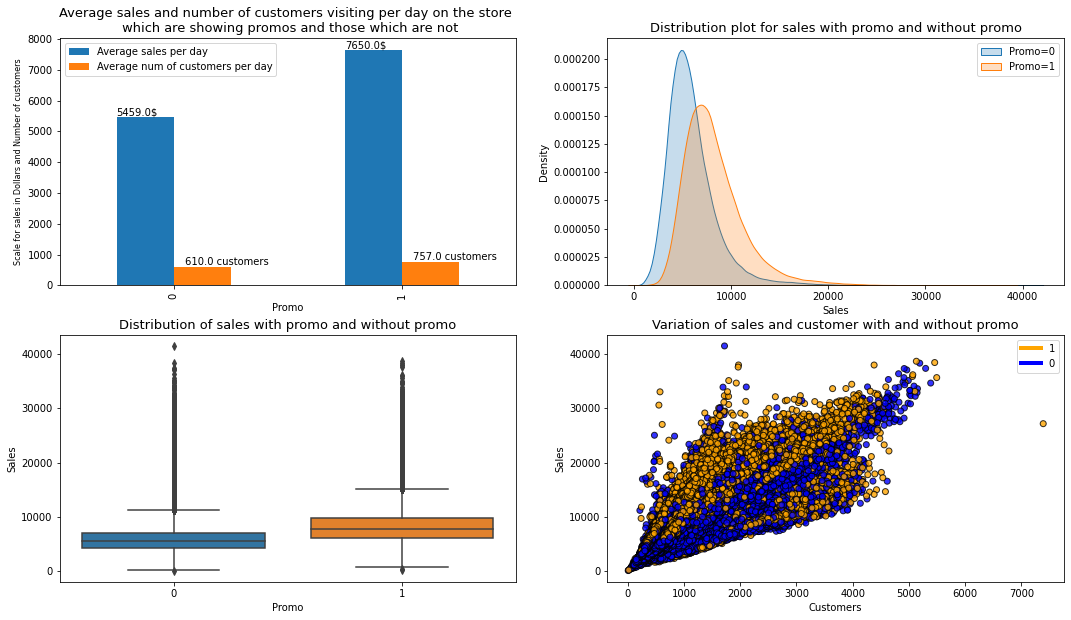

In [69]:
#________________________________________________BLOCK 51________________________________________

#visualising promo effect on sales and customers
colors = {1:'orange', 0: 'blue'}
fig , axes = plt.subplots(2,2, figsize = (18,10))   #creating figure and multiple axes(2*2=2)

#grouping data on the basis of promo then taking medians of sales and customer counts to check the promos effect on sales and customers
promo_sales  = rossman_stores_data.groupby('Promo').agg({'Sales':'median','Customers':'median'})
promo_sales.rename(columns={'Sales':'Average sales per day','Customers':'Average num of customers per day'},inplace=True)  #renaming column 
axs = promo_sales.plot.bar(ax= axes[0][0]) #bar plot in axes[0] representing average sales and customers when promo=0 and promo=1
axs.set_title('Average sales and number of customers visiting per day on the store \n which are showing promos and those which are not',fontsize=13)  
axs.set_ylabel('Scale for sales in Dollars and Number of customers',fontsize=8)  #to set y-label for the plot of current axes

#to put text over bars
for i in range(len(promo_sales)):
  axs.text(x = i-0.25, y = promo_sales.iloc[i]['Average sales per day'] +50, s= str(round(promo_sales.iloc[i]['Average sales per day'],0))+'$')
  axs.text(x = i+0.05, y = promo_sales.iloc[i]['Average num of customers per day'] +50, 
           s= str(round(promo_sales.iloc[i]['Average num of customers per day'],0))+' customers')
rossman_stores_data.groupby('Promo')['Sales']  #sales corresponding to promo

#kde plot for sales when promo=0
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['Promo'] == 0]['Sales'], ax = axes[0][1],label = 'Promo=0', shade = True)
#kde plot for sales when promo=1
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['Promo'] == 1]['Sales'], ax = axes[0][1],label ='Promo=1', shade = True) 

axs2.set_title('Distribution plot for sales with promo and without promo',fontsize=13)   #to set title for plot 
axs2.legend()  #to show labels on graphs

#box plot showing distribution of sales and customers when promo=0 and promo=1
axs3 = sns.boxplot(x = 'Promo', y = 'Sales', data = rossman_stores_data, ax= axes[1][0])
axs3.set_title('Distribution of sales with promo and without promo',fontsize=13)

#scatterplot showing variation of sales with customer when promo=0 and promo=1 
axes[1][1].scatter(rossman_stores_data['Customers'], rossman_stores_data['Sales'],c = rossman_stores_data['Promo'].map(colors),alpha = 0.8,edgecolors='black')
axes[1][1].set_title('Variation of sales and customer with and without promo',fontsize=13)
axes[1][1].set_xlabel('Customers')
axes[1][1].set_ylabel('Sales')
from matplotlib.lines import Line2D  
custom_lines = [Line2D([0], [0], color='orange', lw=4),  # custom lines for label of scatter plot
                Line2D([0], [0], color='blue', lw=4)]
labels=[1,0]
axes[1][1].legend(custom_lines,labels)
plt.show()

*Promos are surely working in favour of increasing sales of stores. On a day Stores showing promos on an average makes a sale of approx 2000 dollars greater than the days they don't shows a promo*

*We can see for sales with promo, peak of distribution lies somewhere around 8500$ and sales without promo peak of distribution lies somewhere around 7500 which means maximum sales with promo is around 8500 and maximum sales without promo is around 7500 for stores* 

*Lets randomly get 5-10 stores and see the difference in there sales on the days when they are showing promos and when they are not*

<Figure size 576x288 with 0 Axes>

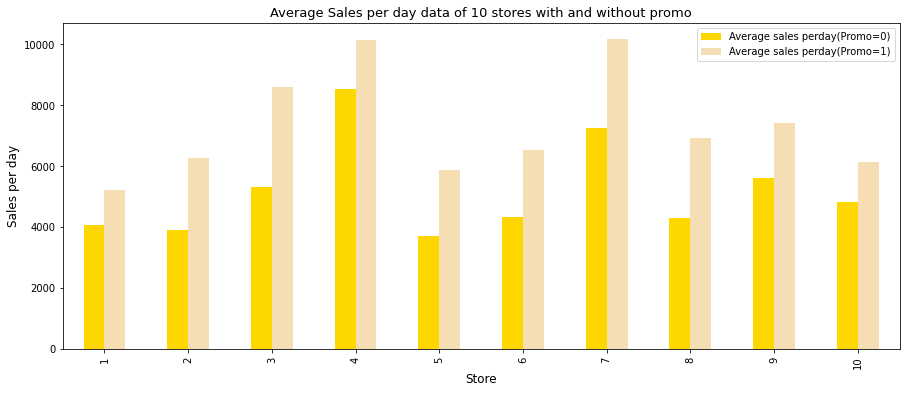

In [70]:
1#___________________________________________BLOCK 52_________________________________________

#selecting 20 observations by grouping rossman_stores_data on store and promo and finding median of sales and customers then
ten_stores_data = rossman_stores_data.groupby(['Store','Promo']).agg({'Sales':'median','Customers':'median'})[0:20].reset_index()
ten_stores_data.rename(columns={'Sales':'Average sales(pd)','Customers':'Average customers(pd)'},inplace=True)  #renaming columns

#creating a subdataframe of store and median of sales from ten_stores_data and selecting those observations where promo equals to zero
sales_without_promo = ten_stores_data[ten_stores_data['Promo']==0][['Store','Average sales(pd)']].set_index('Store') 
sales_without_promo.rename(columns={'Average sales(pd)':'Average sales perday(Promo=0)'},inplace=True)

#creating a subdataframe of store and average sales from ten_stores_data and selecting those observations where promo equals to one
sales_with_promo = ten_stores_data[ten_stores_data['Promo']==1][['Store','Average sales(pd)']].set_index('Store') 
sales_with_promo.rename(columns={'Average sales(pd)':'Average sales perday(Promo=1)'},inplace=True)

sales_promodata = pd.merge(sales_without_promo,sales_with_promo, how='inner', on ='Store') #merging with and without promo dataset with inner join on store

#visualising on an average sales of randomly choosen 10 stores on promo basis
plt.figure(figsize =(8,4))  #defining figure
axs1=sales_promodata.plot.bar(color=['gold','wheat'], figsize=(15,6))  #bar plot 
axs1.set_ylabel('Sales per day',fontsize=12)
axs1.set_xlabel('Store',fontsize=12)
axs1.set_title('Average Sales per day data of 10 stores with and without promo',fontsize=13)
plt.show()

*From above block we can see, average sales of stores with promo is higher than that of without promo. Promo is creating higher end differences in sales*

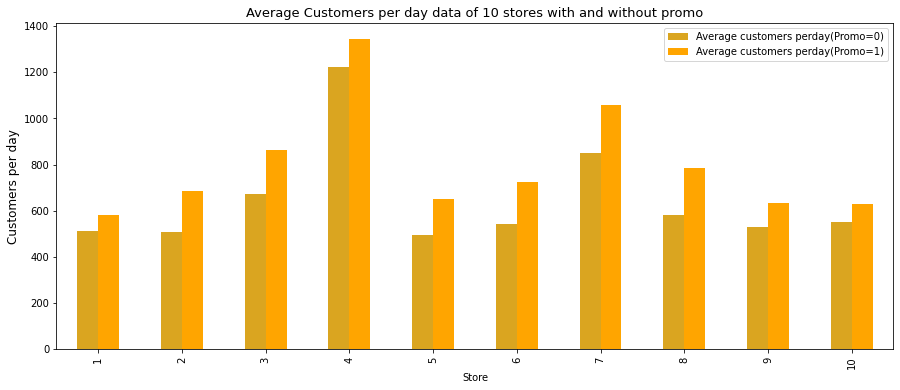

In [71]:
#_________________________________________________BLOCK 53________________________________________________

#creating a subdataframe of store and average customers from ten_stores_data and selecting those observations where promo equals to zero
customers_without_promo = ten_stores_data[ten_stores_data['Promo']==0][['Store','Average customers(pd)']].set_index('Store') 
customers_without_promo.rename(columns={'Average customers(pd)':'Average customers perday(Promo=0)'},inplace=True)  #renaming the column

#creating a subdataframe of store and average customers from ten_stores_data and selecting those observations where promo equals to one
customers_with_promo = ten_stores_data[ten_stores_data['Promo']==1][['Store','Average customers(pd)']].set_index('Store') 
customers_with_promo.rename(columns={'Average customers(pd)':'Average customers perday(Promo=1)'},inplace=True)

#merging with and without promo dataset with inner join on store
customers_promodata = pd.merge(customers_without_promo,customers_with_promo, how='inner', on ='Store') 

#visualising customers per day from randomly choosen 10 stores on promo basis
axs1=customers_promodata.plot.bar(color=['goldenrod','orange'], figsize=(15,6)) #bar plot 
axs1.set_ylabel('Customers per day',fontsize=12)
axs1.set_title('Average Customers per day data of 10 stores with and without promo',fontsize=13)
plt.show()

*As the difference in sale with and without promo is clearly seen, there seems to be no need of statistical testing*

## ***Promo2 Analysis***

### *Creating Promo2Indicator Feature*



*Promo2Indicator is a feature that will have a value as 1 if promo2sincedate is less than or equal to the date of sales else indicator will be set as 0*

In [72]:
'''Designing a function to check If on a date of sales day if stores started participating in promo2(promo2 has been there 
  before this date) then set promo2 indicator as 1 else set promo2 indicator to 0'''

def promo2_indicator(promo2_since_date, date):
  #check if promo2 since date is not equal to zero 
  if promo2_since_date != 0:  
    #if days difference between sales date and date between promotion2 started is greater than 0 then set indicator as 1
    if date-promo2_since_date>= datetime.timedelta(days=0):
      return 1
    #if promo2 since date is 0 then store is not participating in promo2 and set indicator as 0
    else:
      return 0
  return 0

In [73]:
#applying promo2 indicator function
rossman_stores_data['Promo2Indicator'] = rossman_stores_data.apply(lambda x: promo2_indicator(x['Promo2SinceDate'],x['Date']),axis=1)

In [74]:
rossman_stores_data.sample(7)

Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
286651     316          4 2014-12-18  14799       1214      1            0   
947661    1039          4 2013-06-13   5053        714      0            0   
1015608   1114          2 2014-10-21  18694       2817      1            0   
853965     938          4 2015-07-16   9823       1002      1            0   
201604     223          5 2014-07-04   7258        764      1            0   
774499     850          1 2014-03-17   8140        828      1            0   
541294     594          5 2015-02-13   4027        467      0            0   

         SchoolHoliday StoreType Assortment  CompetitionDistance  \
286651               0         d      Basic               9000.0   
947661               0         a   Extended                 70.0   
1015608              1         a   Extended                870.0   
853965               0         a      Basic               2820.0   
201604               0         d   Extended               2920.0   
774499               0         d      Basic               1120.0   
541294               0         a      Basic               1790.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
286651                           8                      2001       0   
947661                           6                      1990       1   
1015608                          0                         0       0   
853965                           9                      2009       0   
201604                          10                      1995       1   
774499                           5                      2007       1   
541294                          10                      2011       0   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  \
286651                 0                0                 0   
947661                22             2012  Mar,Jun,Sept,Dec   
1015608                0                0                 0   
853965                 0                0                 0   
201604                27             2011   Jan,Apr,Jul,Oct   
774499                31             2013   Jan,Apr,Jul,Oct   
541294                 0                0                 0   

             Promo2SinceDate CompetitionOpenSinceDate  avg_cust_visit_per_day  \
286651                     0      2001-08-01 00:00:00              901.838254   
947661   2012-05-28 00:00:00      1990-06-01 00:00:00             1037.385214   
1015608                    0                        0             3200.946429   
853965                     0      2009-09-01 00:00:00              963.707908   
201604   2011-07-04 00:00:00      1995-10-01 00:00:00              738.716113   
774499   2013-08-05 00:00:00      2007-05-01 00:00:00              652.210867   
541294                     0      2011-10-01 00:00:00              456.676020   

         avg_sales_per_day  avg_sales_per_customer  month  year  DateOfMonth  \
286651         9855.625160               10.928373     12  2014           18   
947661         8181.425422                7.886584      6  2013           13   
1015608       20666.562500                6.456391     10  2014           21   
853965         9408.114796                9.762413      7  2015           16   
201604         7232.875959                9.791144      7  2014            4   
774499         6193.765847                9.496570      3  2014           17   
541294         4155.866071                9.100250      2  2015           13   

         WeekofYear  Promo2Indicator  
286651           51                0  
947661           24                1  
1015608          43                0  
853965           29                0  
201604           27                1  
774499           12                1  
541294            7                0

### *Analysis of Promo2Indicator Feature*

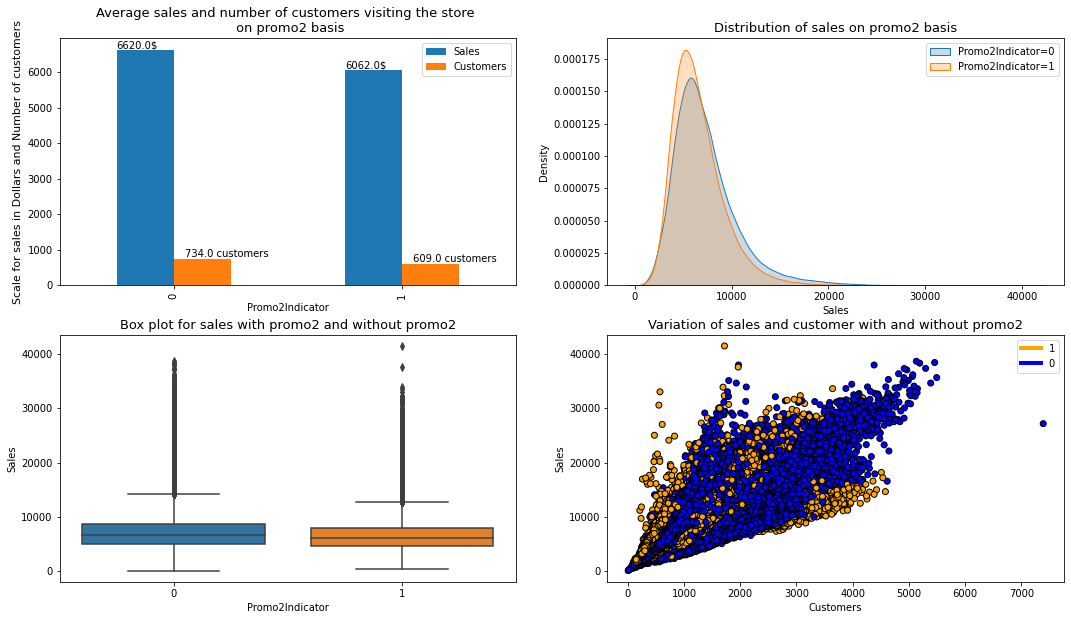

In [75]:
#_______________________________________BLOCK 54_________________________________________________

#sales and customer visit per day on promo2 basis
promo2_sales_cust  = rossman_stores_data.groupby('Promo2Indicator').agg({'Sales':'median','Customers':'median'})
colors = {1:'orange', 0: 'blue'}

#visualising promo2 effect on sales and customers
fig , axes = plt.subplots(2,2, figsize = (18,10))   #defining figure and creating different axes
axs = promo2_sales_cust.plot.bar(ax = axes[0][0])    #bar plot
axs.set_title('Average sales and number of customers visiting the store \n on promo2 basis',fontsize=13)
axs.set_ylabel('Scale for sales in Dollars and Number of customers',fontsize=11)
#to put text over bars
for i in range(len(promo2_sales_cust)):
  axs.text(x = i-0.25, y = promo2_sales_cust.iloc[i]['Sales'] +50 , s= str(round(promo2_sales_cust.iloc[i]['Sales'],0))+'$')
  axs.text(x = i+0.05, y = promo2_sales_cust.iloc[i]['Customers']+50, s= str(round(promo2_sales_cust.iloc[i]['Customers'],0))+' customers')

#kde plot showing distribution of sales without promo2
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['Promo2Indicator'] == 0]['Sales'], ax = axes[0][1],label = 'Promo2Indicator=0', shade = True)
#kde plot showing distribution of sales with promo2
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['Promo2Indicator'] == 1]['Sales'], ax = axes[0][1],label ='Promo2Indicator=1', shade = True) 
axs2.set_title('Distribution of sales on promo2 basis',fontsize=13)
axs2.legend()  #to show labels on graphs

#boxplot showing distribution of sales on promo2 basis
axs3 = sns.boxplot(x = 'Promo2Indicator', y = 'Sales', data = rossman_stores_data, ax= axes[1][0])
axs3.set_title('Box plot for sales with promo2 and without promo2',fontsize=13)

#scatterplot showing variation of sales with customer on promo2 basis
axes[1][1].scatter(rossman_stores_data['Customers'], rossman_stores_data['Sales'],  c = rossman_stores_data['Promo2Indicator'].map(colors), edgecolors='black')
axes[1][1].set_title('Variation of sales and customer with and without promo2',fontsize=13)
axes[1][1].set_xlabel('Customers')
axes[1][1].set_ylabel('Sales')
custom_lines = [Line2D([0], [0], color='orange', lw=4),  # custom lines for label of scatter plot
                Line2D([0], [0], color='blue', lw=4)]
labels=[1,0]
axes[1][1].legend(custom_lines,labels)
plt.show()

*Stores participating in consecutive promotions have slightly lesser sales as compare to stores that don't*

*Box plot for both sales with promo2 and without promo2 is almost same with just slighter difference*

*It seems that for increasing their sales these stores are participating and the ones which already have a decent sale is not participating to that extent*

*Lets look on how these promotional events helping in increasing sales.*

In [76]:
'''In this block we are basically trying to get those stores that started 
    participating in promo2 activities between feb 2013 and july 2015.'''

#empty list to store the Store ID
stores=[]
#threshold start and end date for the stores to check if promo2 since date is between these dates 
date1 = datetime.datetime.strptime('2013-02-01', '%Y-%m-%d')
date2 = datetime.datetime.strptime('2015-07-01', '%Y-%m-%d')
#looping over each store in stores data and checking if promo2since date is between date1 and date2 
#and if in between append store id to stores list
for i in range(len(stores_data)):
  if stores_data.iloc[i]['Promo2'] != 0:
    if stores_data.iloc[i]['Promo2SinceDate'] >= date1 and stores_data.iloc[i]['Promo2SinceDate'] < date2:
      stores.append(stores_data.iloc[i]['Store']) 

In [77]:
len(stores)

212

In [78]:
#-stores those participated in promo2 between 1 feb 2013 - 01-07-2015
#say stores 2 and stores 5 
#say store 2 - promo2since date = 01 apr 2014
#sales data before 01 apr 2014 promo2indicator - 0
#sales data after or equal to 01 apr 2014 promo2indicator ->1 
#store 5 02 feb 2013 
#sales data before 02 feb 2013 - promo2indicator - 0 
#sales data after 02 feb 2013 and on that day - promo2indicator - 1 
#all the stores collected from previous block will have some rows as promo2indicator= 0 and other rows as promo2indicator=1

In [79]:
''' Preparing a dataframe that contains store id average sales of store before participating in promo2
    and average sales of store after participating in promo2'''

#empty lists to store sales and customer before and after promo2 activities 
sales_before_promo2 = []
sales_after_promo2 = []
customer_before_promo2 = []
customer_after_promo2 = []

#looping over each store collected in previous block
for store_id in stores:
  #averaging before sales when promo2 indicator is 0 for each store in stores
  sales_before_promo2.append(int(rossman_stores_data[(rossman_stores_data['Promo2Indicator']==0) & (rossman_stores_data['Store']==store_id)]['Sales'].mean()))
  #averaging after sales when promo2 indicator is 1 for each store in stores
  sales_after_promo2.append(int(rossman_stores_data[(rossman_stores_data['Promo2Indicator']!=0) & (rossman_stores_data['Store']==store_id)]['Sales'].mean()))  
  #averaging customer counts when promo2 indicator is 0 for each store in stores
  customer_before_promo2.append(int(rossman_stores_data[(rossman_stores_data['Promo2Indicator']==0) & (rossman_stores_data['Store']==store_id)]['Customers'].mean()))
  #averaging customer counts when promo2 indicator is 1 for each store in stores
  customer_after_promo2.append(int(rossman_stores_data[(rossman_stores_data['Promo2Indicator']!=0) & (rossman_stores_data['Store']==store_id)]['Customers'].mean()))

#preparing a dataframe from above collected information 
promo2_df = pd.DataFrame({'store':stores,'Sales_before':sales_before_promo2,'sales_after' :sales_after_promo2, 'customer_before' : customer_before_promo2,'customer_after':customer_after_promo2})
promo2_df.set_index('store',inplace = True) 

In [80]:
#head copmmand for promo2_df
promo2_df.head()

Sales_before  sales_after  customer_before  customer_after
store                                                            
20             7556         8269              844             859
28             5461         4675              599             512
30             5973         4714              886             683
36             9229         9709             1097            1070
39             4345         5002              598             638

In [81]:
#average sales of all the stores before and after promo2
before_sales_avg = sum(sales_before_promo2)/len(sales_before_promo2)
after_sales_avg  = sum(sales_after_promo2)/len(sales_after_promo2)
print('Average Sales of stores before the promo2 is there : ', before_sales_avg)
print('Average Sales of stores after the promo2 is there : ', after_sales_avg)

Average Sales of stores before the promo2 is there :  6100.66037735849
Average Sales of stores after the promo2 is there :  6592.084905660377


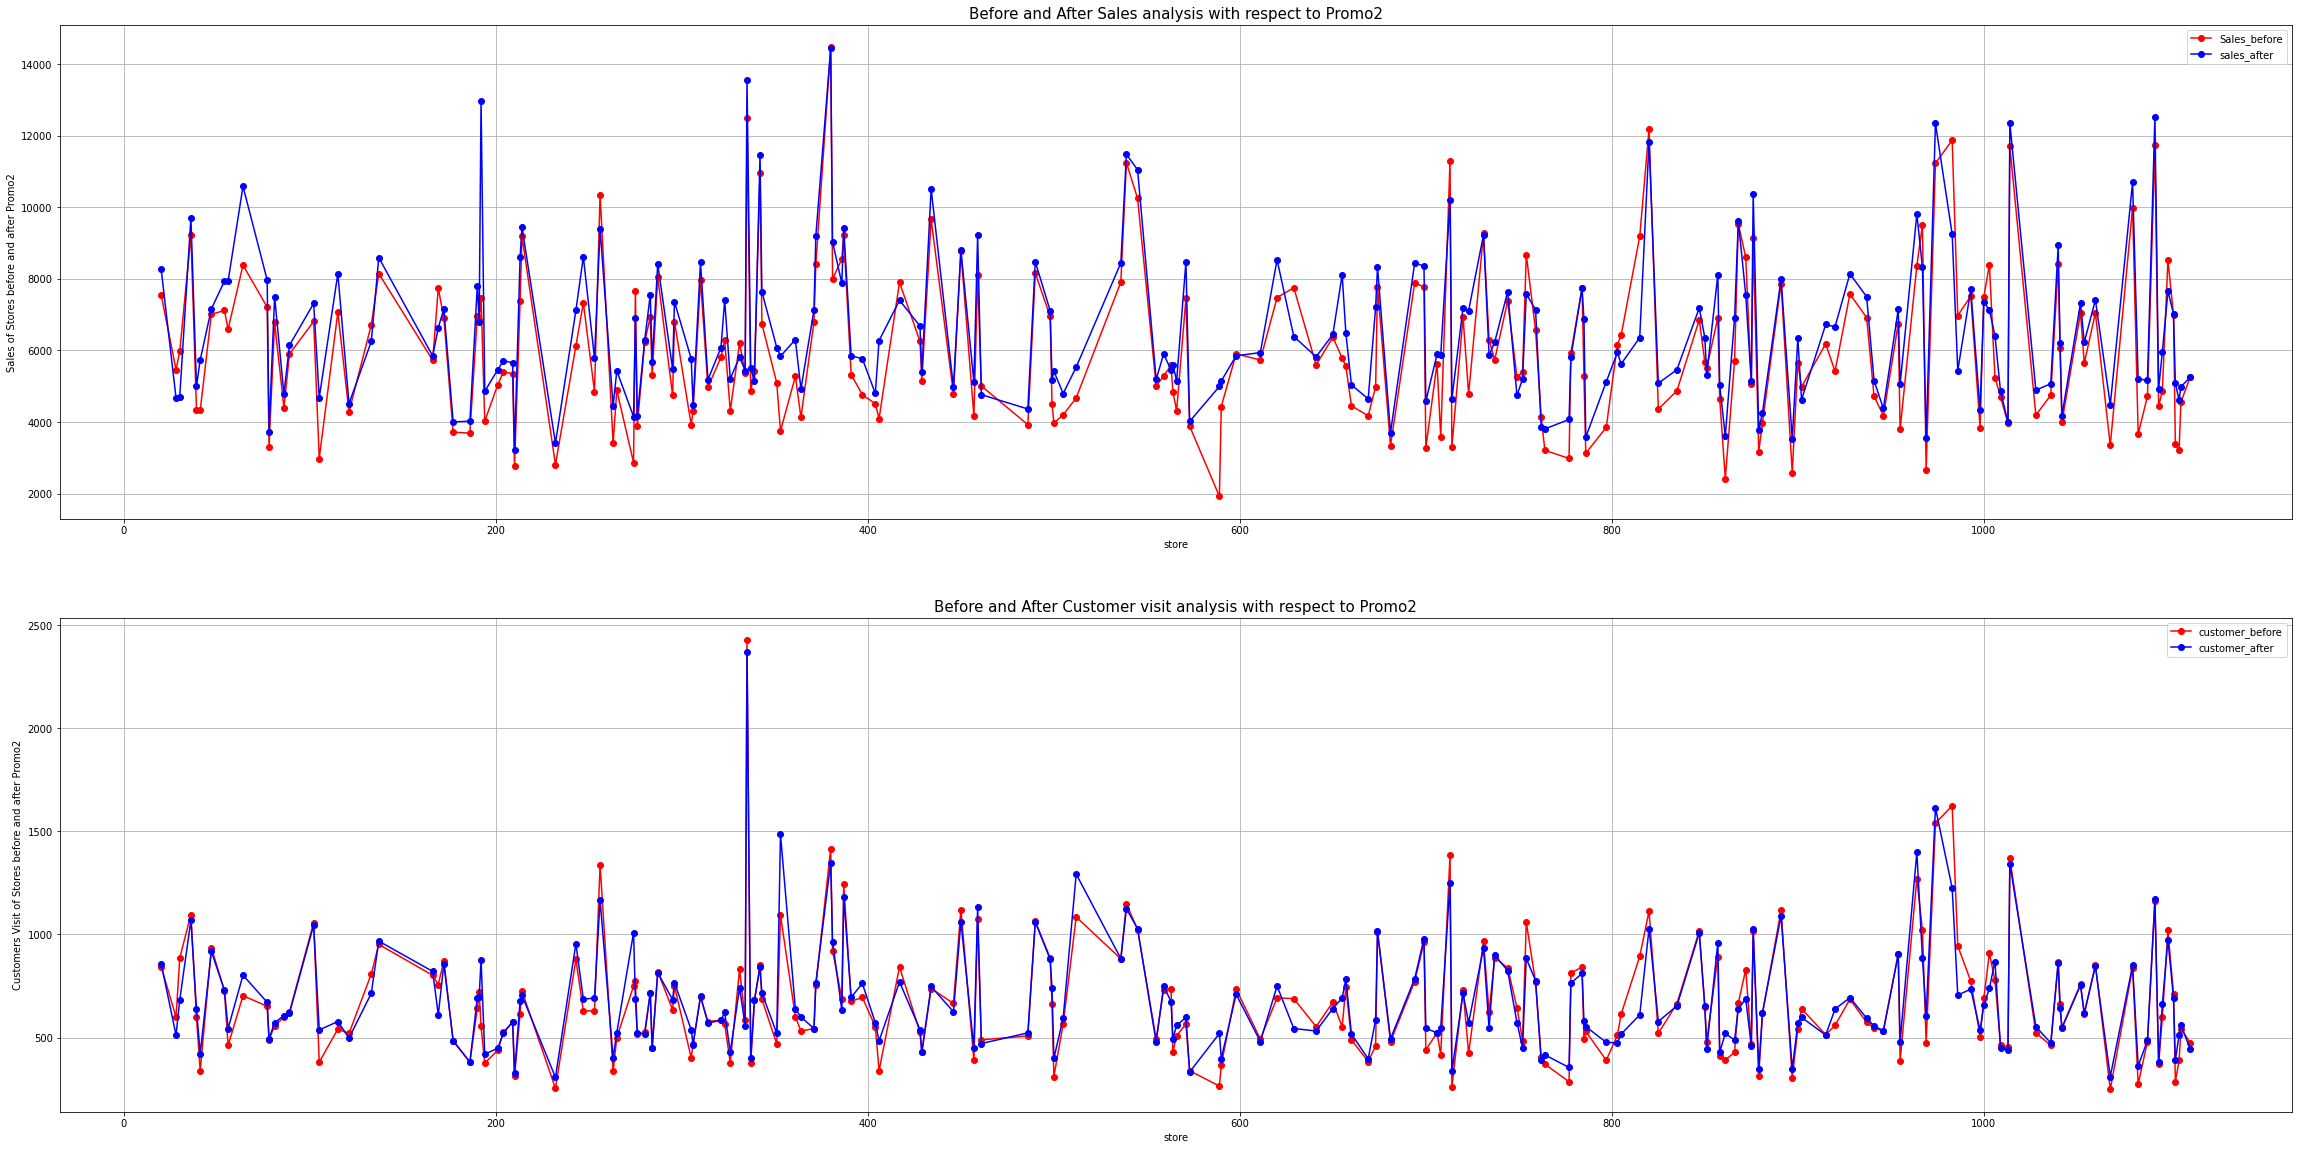

In [82]:
'''In this block we are trying to visualise the pattern of sales and customer before and after the store participated in promo2
   to observe a general trend of sales with effect of promo2 '''


#initialising figure canvas
fig,axs = plt.subplots(2,1, figsize=(40,20)) 
#line plot for analyzing the trend of sales in stores before and after promo2
sales_graph = promo2_df[['Sales_before','sales_after']].plot(marker = 'o', ax =axs[0],color=['red','blue'])
sales_graph.set_ylabel('Sales of Stores before and after Promo2')      #setting ylabel of the graph                                                                                               
sales_graph.set_title('Before and After Sales analysis with respect to Promo2', fontsize=15)  #setting titile of the graph

#line plot for analyzing the trend of customer_visit in stores before and after promo2
customers_graph = promo2_df[['customer_before','customer_after']].plot(marker = 'o', ax =axs[1],color=['red','blue'])  
customers_graph.set_ylabel('Customers Visit of Stores before and after Promo2')  #setting ylabel of the graph  
customers_graph.set_title('Before and After Customer visit analysis with respect to Promo2', fontsize=15)  #setting titile of the graph

sales_graph.grid()  # to show grid lines for ease of comprehending graphs
customers_graph.grid()


*Looking over all the stores it seems like for most of the **stores** promo2 is actually working as a average sales of these stores after participating in promo2 is higher than before participating.*

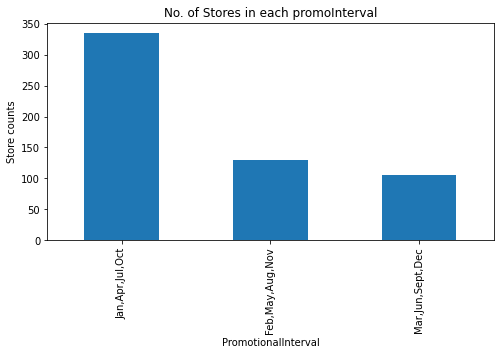

In [83]:
#_______________________________________BLOCK 58___________________________________________________

#visualising no. of stores participating in different promo intervals 
stores_data[stores_data['Promo2']==1]['PromoInterval'].value_counts().plot.bar()   #bar plot
plt.xlabel('PromotionalInterval')
plt.ylabel('Store counts')
plt.title('No. of Stores in each promoInterval')
plt.show()

*Most of the stores participates in those promo intervals that starts from Jan*

Sales
PromoInterval                
Feb,May,Aug,Nov   6427.367069
Jan,Apr,Jul,Oct   6726.367401
Mar,Jun,Sept,Dec  6215.888185

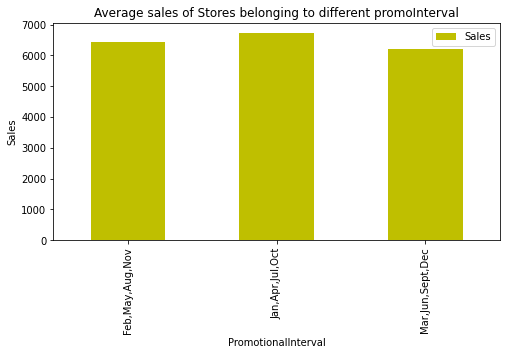

In [84]:
#________________________________BLOCK 59_________________________________________

#visualising promointervals effect on sales
rossman_stores_data[rossman_stores_data['Promo2']==1].groupby(['PromoInterval']).agg({'Sales':'mean'}).plot.bar(color='y')   #bar plot
plt.xlabel('PromotionalInterval')   
plt.ylabel('Sales')
plt.title('Average sales of Stores belonging to different promoInterval')

#to show data of promointervals effect on sales
rossman_stores_data[rossman_stores_data['Promo2']==1].groupby(['PromoInterval']).agg({'Sales':'mean'})

*Although there is not much difference in sales value but still the stores that are participating in promotion intervals of jan starting plan is making a bit higher sale on an average, this might be due to large no. of stores which are participating in jan plan*

## ***School Holiday Analysis***

In [85]:
#___________________________________BLOCK 60________________________________________

#unique values and their counts in schoolholiday 
rossman_stores_data['SchoolHoliday'].value_counts()

0    680893
1    163445
Name: SchoolHoliday, dtype: int64

In [86]:
#stateholidays when stores are affected by school holidays 
rossman_stores_data[rossman_stores_data['SchoolHoliday']==1]['StateHoliday'].value_counts()

0                163131
Easter              139
PublicHoliday       104
Christmas            71
Name: StateHoliday, dtype: int64

In [87]:
#stateholidays when stores are not affected by school holidays
rossman_stores_data[rossman_stores_data['SchoolHoliday']==0]['StateHoliday'].value_counts()

0                680297
PublicHoliday       590
Easter                6
Name: StateHoliday, dtype: int64

In [88]:
#stateholidays in complete data 
rossman_stores_data['StateHoliday'].value_counts()

0                843428
PublicHoliday       694
Easter              145
Christmas            71
Name: StateHoliday, dtype: int64

*Stores sales are mostly affected by school holidays on the holidays of christmas and easter and less affected by school holidays on public holidays*

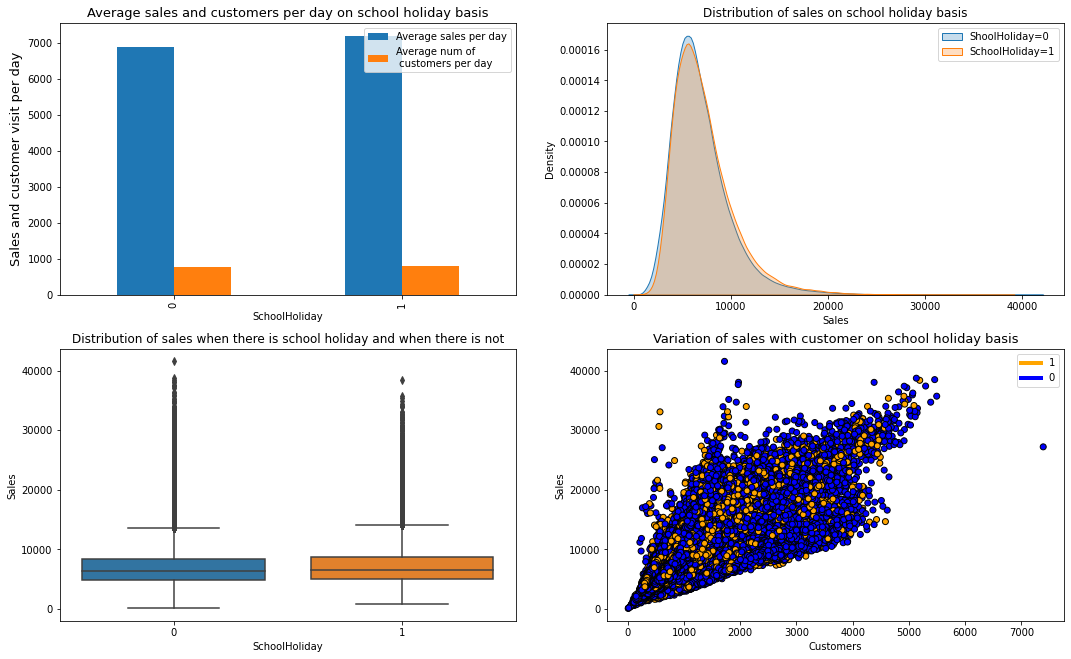

In [89]:
#____________________________________BLOCK 61_____________________________________

#to check for average of sales and customers on school holiday basis
customer_sales_acrdntoschoolholiday=rossman_stores_data.groupby('SchoolHoliday').agg({'Sales':'mean','Customers':'mean'}) 
customer_sales_acrdntoschoolholiday.rename(columns={'Sales':'Average sales per day','Customers':'Average num of\n customers per day'},inplace=True) 

#visualising schoolholiday effect on sales and customers
fig,axes = plt.subplots(2,2,figsize=(18,11))  #defining figure and creating different axes
colors = {1:'orange', 0: 'blue'}

#bar plot representing average sales and customers corresponding to school holiday value
axs1 = customer_sales_acrdntoschoolholiday.plot.bar( ax = axes[0][0]) 
axs1.set_title('Average sales and customers per day on school holiday basis',fontsize=13)
axs1.set_ylabel('Sales and customer visit per day',fontsize=13)

#kdeplot showing sales distribution corresponding to school holiday
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['SchoolHoliday'] == 0]['Sales'], ax = axes[0][1],label = 'ShoolHoliday=0', shade = True) 
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['SchoolHoliday'] == 1]['Sales'], ax = axes[0][1],label ='SchoolHoliday=1', shade = True) 
axs2.set_title('Distribution of sales on school holiday basis')
axs2.legend()  #to show labels on graphs

#boxplot showing sales distribution corresponding to school holiday
axs3 = sns.boxplot(x = 'SchoolHoliday', y = 'Sales', data = rossman_stores_data, ax= axes[1][0])
axs3.set_title('Distribution of sales when there is school holiday and when there is not')

#scatterplot showing variation of sales with customer on school holiday basis
axes[1][1].scatter(rossman_stores_data['Customers'], rossman_stores_data['Sales'],  c = rossman_stores_data['SchoolHoliday'].map(colors), edgecolors='black')
axes[1][1].set_title('Variation of sales with customer on school holiday basis',fontsize=13)
axes[1][1].set_xlabel('Customers')
axes[1][1].set_ylabel('Sales')
custom_lines = [Line2D([0], [0], color='orange', lw=4),  # custom lines for label of scatter plot
                Line2D([0], [0], color='blue', lw=4)]
labels=[1,0]
axes[1][1].legend(custom_lines,labels)
plt.show()

*Stores affected by school holidays are giving us a positive outcome as those affected by school holiday has a slighter difference in sales towards upward and customers visit both*

*Even scatter plot for customer and sales with respect to school holiday is not bringing any useful insight*

## ***StateHoliday Analysis***

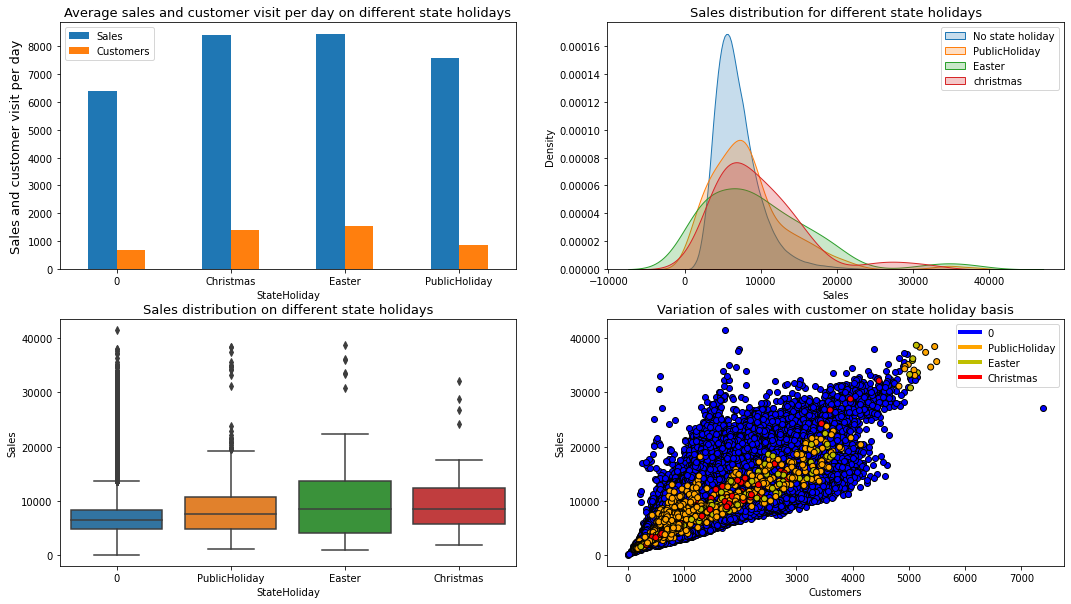

In [90]:
#_________________________________________________BLOCK 62_________________________________________

#visualising state holiday effect on sales and customers
fig,axes = plt.subplots(2,2,figsize=(18,10))
colors = {'PublicHoliday': 'orange','Easter':'y','Christmas':'red'}

#bar plot showing average sales and customers on different state holidays
axs1=rossman_stores_data.groupby('StateHoliday').agg({'Sales':'median','Customers':'median'}).plot.bar(ax = axes[0][0])
#rossman_stores_data.groupby('StateHoliday').agg({'Sales':'mean','Customers':'mean'})  #to find average sales and customers on different state holidays
axs1.set_title('Average sales and customer visit per day on different state holidays',fontsize=13)
axs1.set_ylabel('Sales and customer visit per day',fontsize=13)
axs1.set_xticklabels([0, 'Christmas', 'Easter', 'PublicHoliday'],rotation = 0)

#kde plot showing sales distribution on different state holidays
axs2 =sns.kdeplot(rossman_stores_data[rossman_stores_data['StateHoliday'] == 0]['Sales'], ax = axes[0][1],label = 'No state holiday', shade = True) 
axs2 =sns.kdeplot(rossman_stores_data[rossman_stores_data['StateHoliday'] == 'PublicHoliday']['Sales'], ax = axes[0][1],label ='PublicHoliday', shade = True) 
axs2 =sns.kdeplot(rossman_stores_data[rossman_stores_data['StateHoliday'] == 'Easter']['Sales'], ax = axes[0][1],label ='Easter', shade = True) 
axs2 =sns.kdeplot(rossman_stores_data[rossman_stores_data['StateHoliday'] == 'Christmas']['Sales'], ax = axes[0][1],label ='christmas', shade = True) 
axs2.set_title('Sales distribution for different state holidays',fontsize=13)
axs2.legend()  #to show labels on graphs

#box plot showing sales distribution on different state holidays
axs3=sns.boxplot(x = 'StateHoliday', y = 'Sales', data = rossman_stores_data,ax=axes[1][0])
axs3.set_title('Sales distribution on different state holidays',fontsize=13)

#scatterplot showing variation of sales with customer on state holiday basis
axes[1][1].scatter(rossman_stores_data[rossman_stores_data['StateHoliday']==0]['Customers'], rossman_stores_data[rossman_stores_data['StateHoliday']==0]
                   ['Sales'], edgecolors='black', color = 'blue')
axes[1][1].scatter(rossman_stores_data[rossman_stores_data['StateHoliday']!=0]['Customers'], rossman_stores_data[rossman_stores_data['StateHoliday']!=0]
                   ['Sales'], c =rossman_stores_data[rossman_stores_data['StateHoliday']!=0]['StateHoliday'].map(colors), edgecolors='black')
axes[1][1].set_title('Variation of sales with customer on state holiday basis',fontsize=13)
axes[1][1].set_xlabel('Customers')
axes[1][1].set_ylabel('Sales')
custom_lines = [Line2D([0], [0], color='blue', lw=4),  # custom lines for label of scatter plot
                Line2D([0], [0], color='orange', lw=4),Line2D([0], [0], color='y', lw=4),Line2D([0], [0], color='red', lw=4)]
labels=[0,'PublicHoliday','Easter','Christmas']
axes[1][1].legend(custom_lines,labels)
plt.show()
fig.tight_layout() 

*Stores operating on State holiday has higher sales on that days as compare to the days when there were no state holiday and again the reason being same very less no. of stores are operating on state holidays and people with their families go out to shop as a result of which they are having higher sales on state hoildays*  


*Due to very less no. of obsevations with state holidays scatter plot is not able to provide a significant insght*

## ***Competitions Analysis***

### *Updating CompetitionDistance Feature*

*If competion of a store is established before or on sales day of a store then put competition distance of that store or else impute 100000 as a value to nullify the effect of competition distance*

In [91]:
'''We are designing a function to check in a dataset if at specific day of sales of a specific store is competition is there 
   if so update the competition distance with the actual distance of competitor else put 100000 in place of 
   competition distance '''

def competition_distance(comp_dist, comp_since_date, date):
  #if competition since date has date only and not zero then only enters if value  
  if comp_since_date != 0:
    #if difference between sales date and competitionopensincedate is greater than or equal to zero days means competiton is there before or on sales date   
    #then return comp_dist
    if date-comp_since_date >= datetime.timedelta(days=0):
      return comp_dist
    #else imputr 100000
    else:
      return 100000
  #if comp since date is 0 then return 100000
  return 100000

In [92]:
rossman_stores_data['CompetitionDistance'] = rossman_stores_data.apply(lambda x: competition_distance(x['CompetitionDistance'],x['CompetitionOpenSinceDate'],x['Date']),axis=1)

In [93]:
rossman_stores_data.sample(9)

Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
629229     691          2 2014-06-17   9883        685      1            0   
593066     651          2 2013-04-30   9637       1172      1            0   
252734     278          1 2013-05-06   7233        888      0            0   
206162     228          3 2014-12-03   7725        561      1            0   
383823     421          5 2014-03-07   8022        933      1            0   
19346       21          6 2013-03-09   4891        550      0            0   
398666     438          4 2014-11-13   5782        564      1            0   
1015267   1113          3 2013-02-27   5372        656      0            0   
471794     518          2 2015-06-09   4666        426      0            0   

         SchoolHoliday StoreType Assortment  CompetitionDistance  \
629229               0         d   Extended             100000.0   
593066               0         a      Basic             100000.0   
252734               0         a   Extended               9260.0   
206162               0         d   Extended             100000.0   
383823               0         c   Extended               3530.0   
19346                0         c   Extended                550.0   
398666               0         d   Extended             100000.0   
1015267              0         a   Extended             100000.0   
471794               0         d   Extended               3330.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
629229                           0                         0       1   
593066                           0                         0       0   
252734                           2                      2010       0   
206162                           0                         0       1   
383823                           6                      2012       1   
19346                           10                      1999       1   
398666                           0                         0       1   
1015267                          0                         0       0   
471794                           3                      2015       1   

         Promo2SinceWeek  Promo2SinceYear     PromoInterval  \
629229                37             2009   Jan,Apr,Jul,Oct   
593066                 0                0                 0   
252734                 0                0                 0   
206162                18             2011   Feb,May,Aug,Nov   
383823                35             2012  Mar,Jun,Sept,Dec   
19346                 45             2009   Jan,Apr,Jul,Oct   
398666                40             2012   Jan,Apr,Jul,Oct   
1015267                0                0                 0   
471794                13             2010   Jan,Apr,Jul,Oct   

             Promo2SinceDate CompetitionOpenSinceDate  avg_cust_visit_per_day  \
629229   2009-09-14 00:00:00                        0              621.310655   
593066                     0                        0              948.419769   
252734                     0      2010-02-01 00:00:00              792.599490   
206162   2011-05-02 00:00:00                        0              593.116816   
383823   2012-08-27 00:00:00      2012-06-01 00:00:00             1014.390306   
19346    2009-11-09 00:00:00      1999-10-01 00:00:00              516.361647   
398666   2012-10-01 00:00:00                        0              524.326923   
1015267                    0                        0              717.029337   
471794   2010-03-29 00:00:00      2015-03-01 00:00:00              504.309791   

         avg_sales_per_day  avg_sales_per_customer  month  year  DateOfMonth  \
629229         8371.011553               13.473150      6  2014           17   
593066         7615.865212                8.030057      4  2013           30   
252734         7142.167092                9.011067      5  2013            6   
206162         7946.139923               13.397260     12  2014 

### *Competition Distance Analysis*

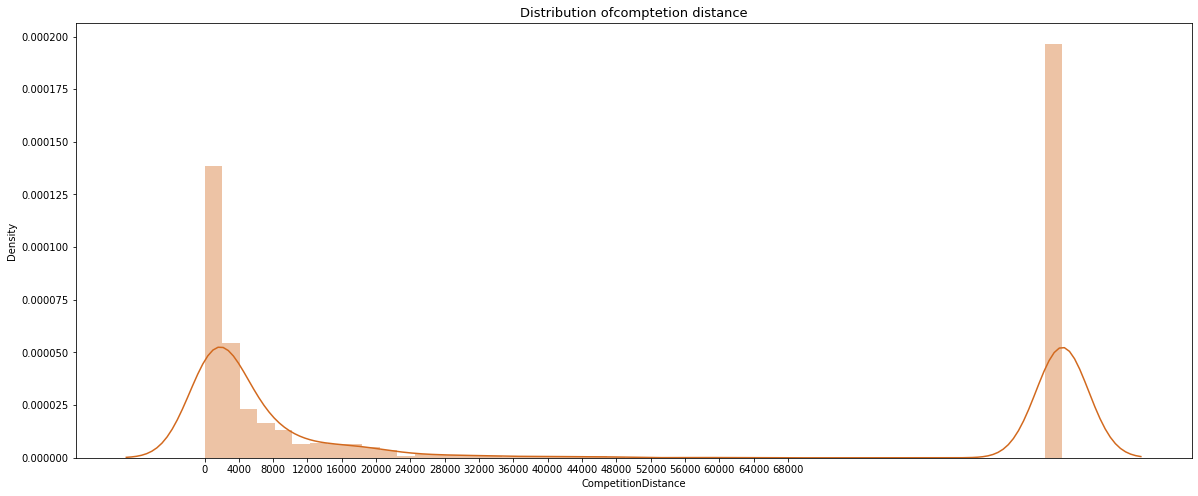

In [94]:
#_____________________________________________BLOCK 63_____________________________________________

#visualising distribution of competition distance
fig = plt.figure(figsize=(20,8))
axs = fig.gca()
sns.distplot(rossman_stores_data['CompetitionDistance'],color='chocolate',ax =axs)   #distribution plot
x_scale = np.arange(0,70000,4000)
plt.xticks(x_scale)
plt.title('Distribution ofcomptetion distance',fontsize=13)
plt.show()

*Most of the stores have there comptetors located under 10kms(10,000m) of range. Whereas peak of the stores lies between 1-4 kms*

In [95]:
#________________________________________________BLOCK 64_____________________________________________

#function to derive new categorical column for comptetional distance for analysis purpose
def num_dis_to_string(x):
  if (x>=0) and (x<=2000):
    y='compet_dist in 0 & 2000'
  if (x>2000) and (x<=4000):
    y='compet_dist in 2000 & 4000'
  if (x>4000) and (x<=8000):
    y='compet_dist_in 4000 & 8000'
  if x>8000:
    y='compet_dist more than 8000'
  return y

In [96]:
#_______________________________________BLOCK 65_____________________________________________________

#applying above function to create comp_dist_categories feature
rossman_stores_data['comp_dist_categories']=rossman_stores_data['CompetitionDistance'].apply(num_dis_to_string)

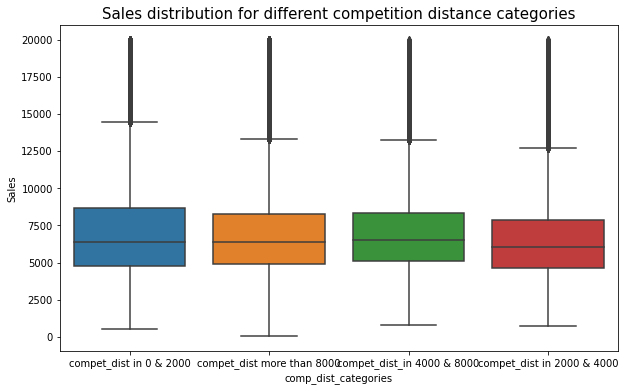

In [97]:
#_____________________________________BLOCK 66______________________________________________________

#visualising comp_dist_categoroies 
plt.figure(figsize=(10,6))
sns.boxplot(x='comp_dist_categories',y='Sales',data=rossman_stores_data[rossman_stores_data['Sales']<20000])   #box plot
plt.title('Sales distribution for different competition distance categories',fontsize=15)
plt.show()

In [98]:
#_________________________________________BLOCK 70____________________________________________

#effect on average sales due to competition distance
rossman_stores_data.groupby('comp_dist_categories').agg({'Sales':'mean'}).rename(columns={'Sales':'Average sales'}) 

Average sales
comp_dist_categories                     
compet_dist in 0 & 2000       7176.825744
compet_dist in 2000 & 4000    6503.601567
compet_dist more than 8000    6937.344446
compet_dist_in 4000 & 8000    6971.443623

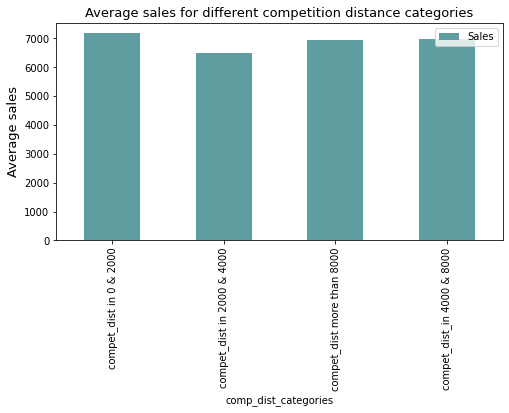

In [99]:
#_________________________________________BLOCK 71______________________________________________________

#visualising above block
rossman_stores_data.groupby('comp_dist_categories').agg({'Sales':'mean'}).plot.bar(color='cadetblue')   #bar plot
plt.title('Average sales for different competition distance categories',fontsize=13)
plt.ylabel('Average sales',fontsize=13)
plt.show()

*Above analysis does not proving any strong relation between competition distance and sales*. 

*Lets try to look on what is the difference between average sales of the stores before and after competition is established*

In [100]:
'''In this block we are basically trying to get those stores for which competition is established between feb 2013 and july 2015.'''

#empty list to store the Store ID
stores=[]
#threshold start and end date for the stores to check if competitor is established between these dates 
date1 = datetime.datetime.strptime('2013-02-01', '%Y-%m-%d')
date2 = datetime.datetime.strptime('2015-07-01', '%Y-%m-%d')
#looping over each store in stores data and checking if competitionopensincedate is between date1 and date2 
#and if in between append store id to stores list
for i in range(len(stores_data)):
  if stores_data.iloc[i]['CompetitionOpenSinceDate'] != 0:
    if stores_data.iloc[i]['CompetitionOpenSinceDate'] >= date1 and stores_data.iloc[i]['CompetitionOpenSinceDate'] < date2:
      stores.append(stores_data.iloc[i]['Store']) 

In [101]:
''' Preparing a dataframe that contains store id average sales of store before competition has been established
    and average sales of store after competition is established'''

#empty lists to store sales and customer before and after competiton is there 
sales_before_competition = []
sales_after_competition = []
customer_before_competition = []
customer_after_competition = []

#looping over each store collected in previous block
for store_id in stores:
  #averaging before sales when competiton is not there i.e. competition distance = 100000 for each store in stores
  sales_before_competition.append(int(rossman_stores_data[(rossman_stores_data['CompetitionDistance']==100000) & (rossman_stores_data['Store']==store_id)]['Sales'].mean()))
  #averaging after sales when competiton is there i.e. competition distance != 100000 for each store in stores
  sales_after_competition.append(int(rossman_stores_data[(rossman_stores_data['CompetitionDistance'] !=100000) & (rossman_stores_data['Store']==store_id)]['Sales'].mean()))  
  #averaging customer counts when when competiton is not there i.e. competition distance = 100000 for each store in stores
  customer_before_competition.append(int(rossman_stores_data[(rossman_stores_data['CompetitionDistance']==100000) & (rossman_stores_data['Store']==store_id)]['Customers'].mean()))
  #averaging customer counts when when competiton is there i.e. competition distance != 100000 for each store in stores
  customer_after_competition.append(int(rossman_stores_data[(rossman_stores_data['CompetitionDistance']!=100000) & (rossman_stores_data['Store']==store_id)]['Customers'].mean()))

#preparing a dataframe from above collected information 
comp_df = pd.DataFrame({'store':stores,'Sales_before':sales_before_competition,'sales_after' :sales_after_competition, 'customer_before' : customer_before_competition,'customer_after':customer_after_competition})
comp_df.set_index('store',inplace = True) 

In [102]:
#head rows check
comp_df.head()

Sales_before  sales_after  customer_before  customer_after
store                                                            
5              4672         4703              537             534
6              6235         5108              726             584
7              7732         8931              847             959
8              5150         6360              625             727
14             5395         5601              629             633

In [103]:
#average sales of all the stores before and after competitor
before_sales_avg = sum(sales_before_competition)/len(sales_before_competition)
after_sales_avg  = sum(sales_after_competition)/len(sales_after_competition)
print('Average Sales of stores before the competition is there : ', before_sales_avg)
print('Average Sales of stores after the competition is there : ', after_sales_avg)

Average Sales of stores before the competition is there :  7406.822222222222
Average Sales of stores after the competition is there :  7196.1


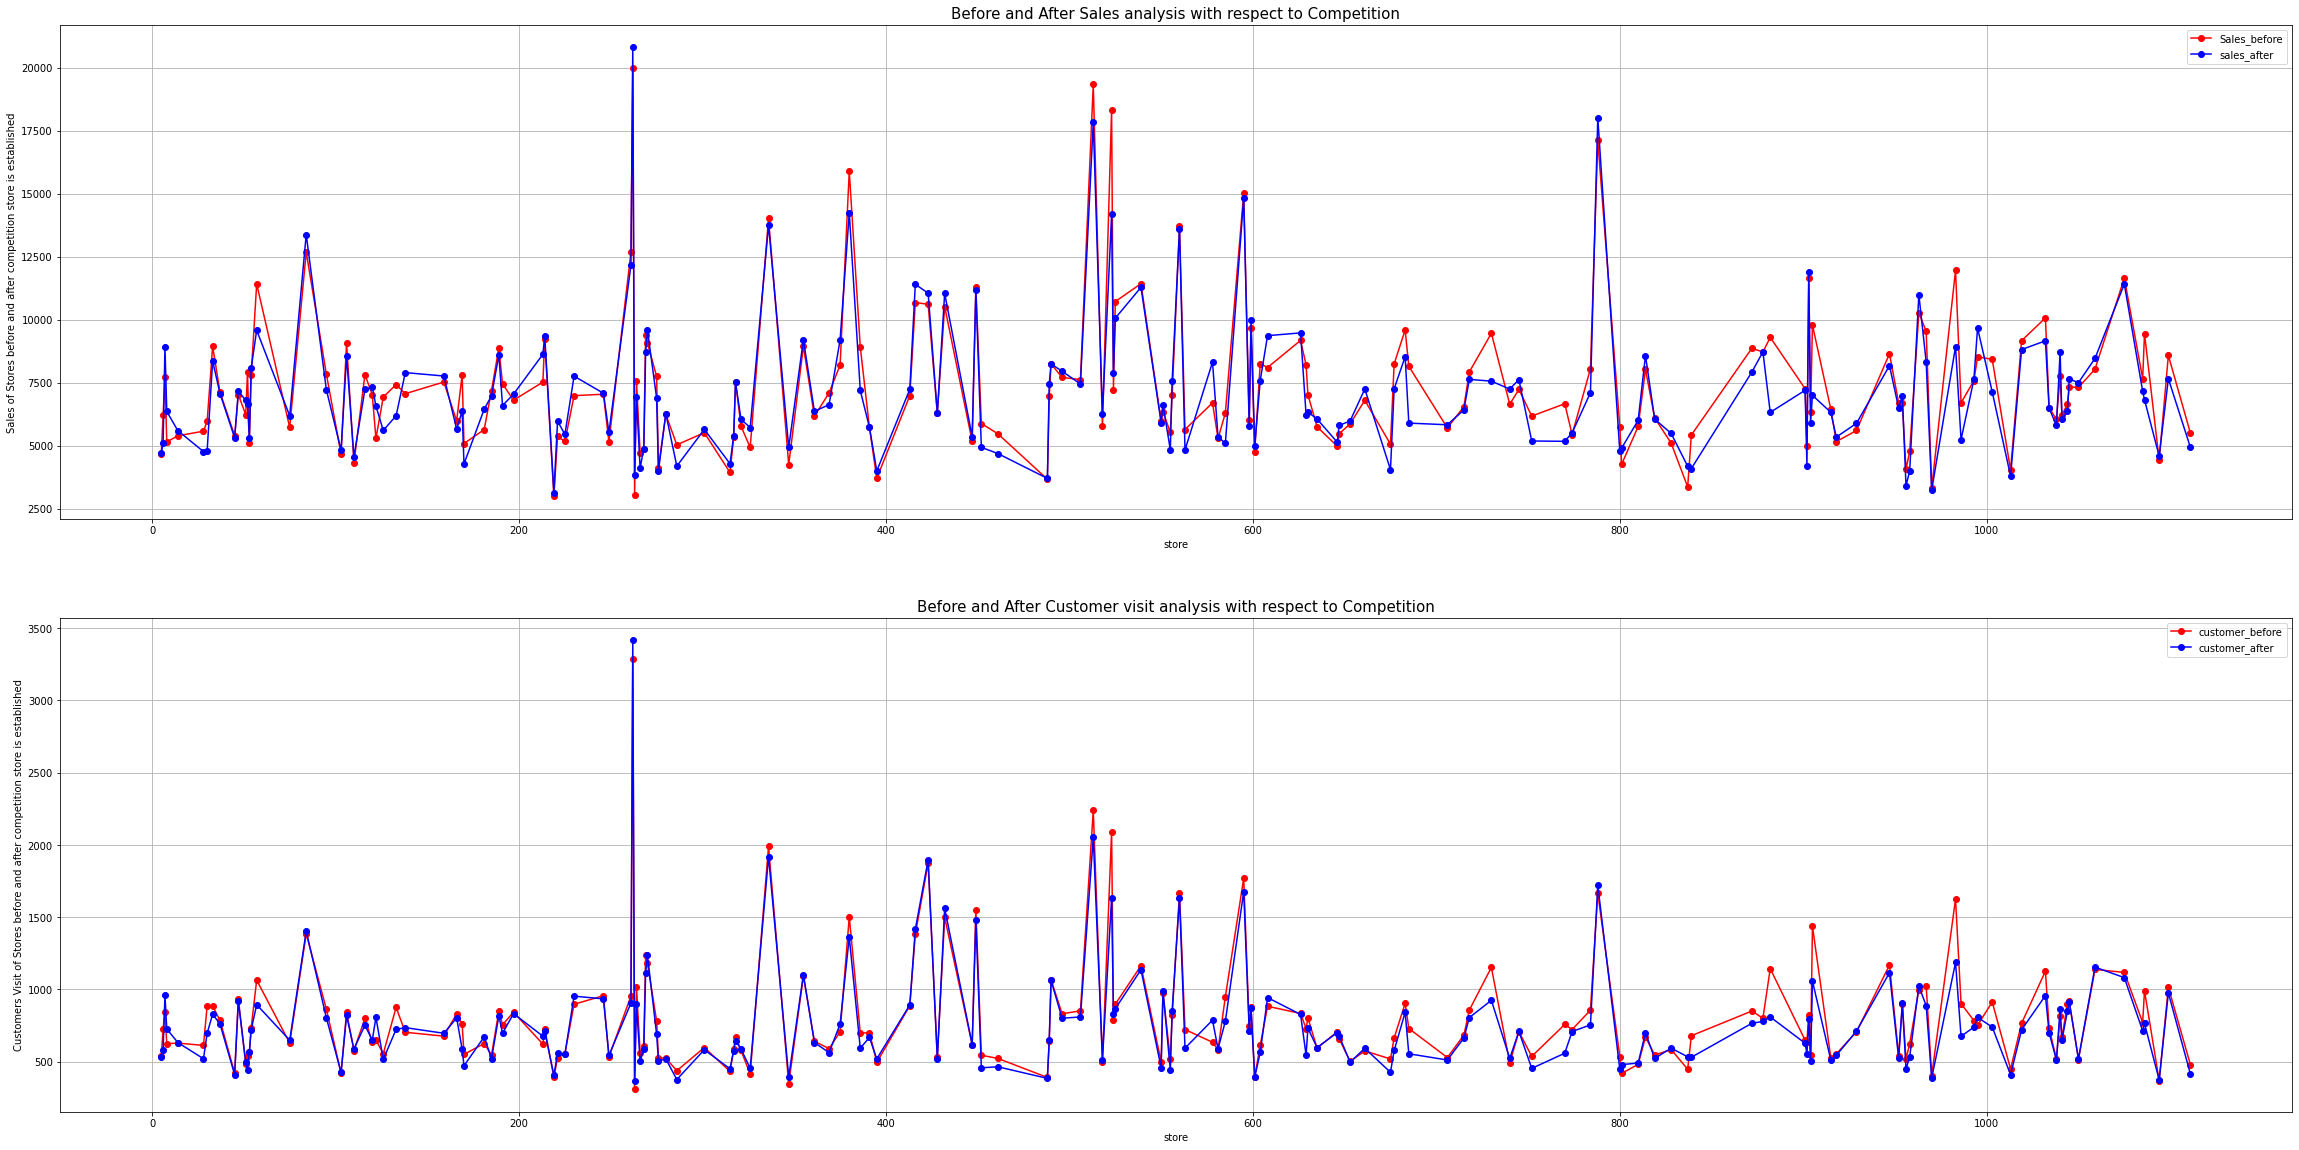

In [104]:
'''In this block we are trying to visualise the pattern of sales and customer before and after the competition is established for the store
   to observe a general trend of sales with effect of competition distance '''

#initialising figure canvas
fig,axs = plt.subplots(2,1, figsize=(40,20)) 
#line plot for analyzing the trend of sales in stores before and after competitior store
sales_graph = comp_df[['Sales_before','sales_after']].plot(marker = 'o', ax =axs[0],color=['red','blue'])
sales_graph.set_ylabel('Sales of Stores before and after competition store is established')      #setting ylabel of the graph                                                                                               
sales_graph.set_title('Before and After Sales analysis with respect to Competition', fontsize=15)  #setting titile of the graph

#line plot for analyzing the trend of customer visits in stores before and after competitior store
customers_graph = comp_df[['customer_before','customer_after']].plot(marker = 'o', ax =axs[1],color=['red','blue'])
customers_graph.set_ylabel('Customers Visit of Stores before and after competition store is established')     #setting ylabel of the graph 
customers_graph.set_title('Before and After Customer visit analysis with respect to Competition', fontsize=15)  #setting titile of the graph
sales_graph.grid()  # to show grid lines for ease of comprehending graphs
customers_graph.grid()


*There are few exceptions but in general we can see that most of the time sales is decreased a bit after competition is established. This proves that competition and its distance is affecting the sales of rossman stores*

##***StoreType and Assortment Analysis***

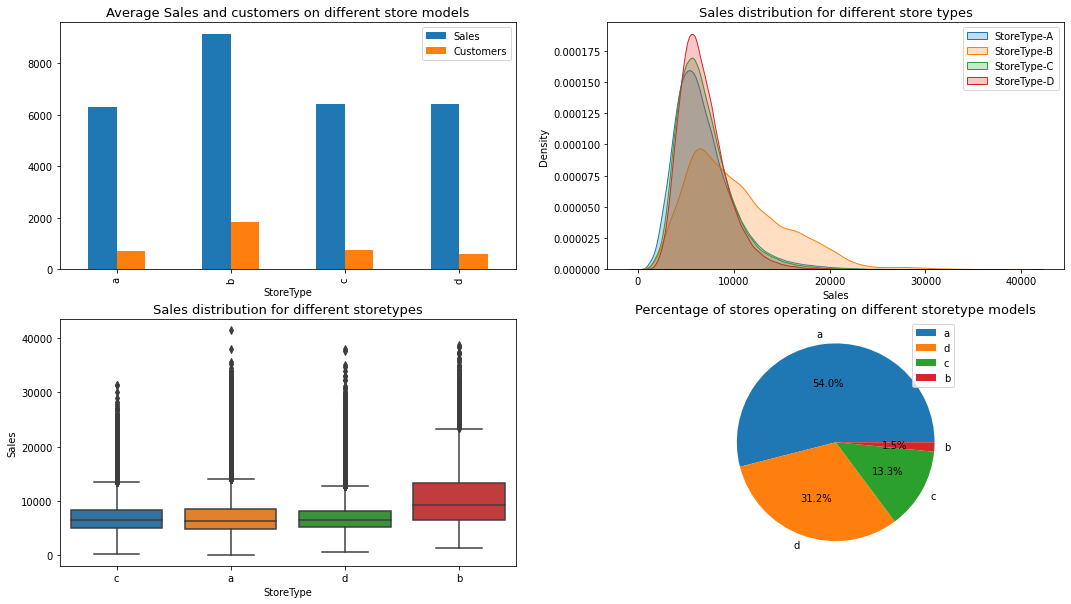

In [105]:
#__________________________________________BLOCK 72_________________________________________________________

#visualising average sales and average no. of customers for different storetypes
fig, axes = plt.subplots(2,2,figsize=(18,10))
colors = {'a':'blue', 'b': 'orange','c':'y','d':'red'}

#bar plot representing average sales and average no. of customers for different storetypes
rossman_stores_data.groupby('StoreType').agg({'Sales':'median','Customers':'median'}).plot.bar(ax = axes[0][0])
axes[0][0].set_title("Average Sales and customers on different store models",fontsize=13)

#kde plot for sales for different storetypes
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['StoreType'] == 'a']['Sales'], ax = axes[0][1],label = 'StoreType-A', shade = True) 
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['StoreType'] == 'b']['Sales'], ax = axes[0][1],label ='StoreType-B', shade = True)
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['StoreType'] == 'c']['Sales'], ax = axes[0][1],label ='StoreType-C', shade = True)
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['StoreType'] == 'd']['Sales'], ax = axes[0][1],label ='StoreType-D', shade = True)
axs2.set_title('Sales distribution for different store types',fontsize=13)
axs2.legend()  #to show labels on graphs

#box plot showing sales distribution for different storetypes
axs3=sns.boxplot(x = 'StoreType', y = 'Sales', data = rossman_stores_data,ax=axes[1][0])
axs3.set_title('Sales distribution for different storetypes',fontsize=13)

#pieplot showing percentahe of stores operating with different storetypes
labels = list(stores_data["StoreType"].value_counts().index)
l = axes[1][1].pie(stores_data["StoreType"].value_counts(), labels = labels,autopct='%1.1f%%')
axes[1][1].set_title('Percentage of stores operating on different storetype models',fontsize=13)
axes[1][1].legend(l[0], labels, loc ='best')
plt.show()
fig.tight_layout()  #for proper spacing between figures

*Store model B is giving us much higher sales and customer visit as well whereas other three stores have nearby by same rate for sales and customers*

*We can see very less stores are operating on store model b we should ask for the stores to operate on model B in order to gain higher sales*

*Lets check for the assortment strategies for each of the store models*

In [106]:
#groupuing by store and assortment strategies to get a count of assortment strategies each store type is using 
rossman_stores_data.groupby(['StoreType','Assortment']).aggregate({'Store':'count'})

Store
StoreType Assortment        
a         Basic       286028
          Extended    171014
b         Basic         6409
          Extended       942
          Extra         8209
c         Basic        58554
          Extended     54414
d         Basic        93884
          Extended    164884

*One observing thing is that only storetype B is using Extar assortment startegies and that could be the potential reason for storetype B having greater sales as from the below analysis we can see that Extra assortment has higher sales*

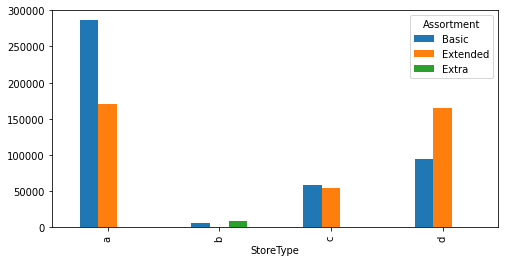

In [107]:
 rossman_stores_data.groupby(['StoreType','Assortment']).aggregate({'Store':'count'}).reset_index().pivot(index='StoreType', columns='Assortment', values='Store').plot(kind='bar')

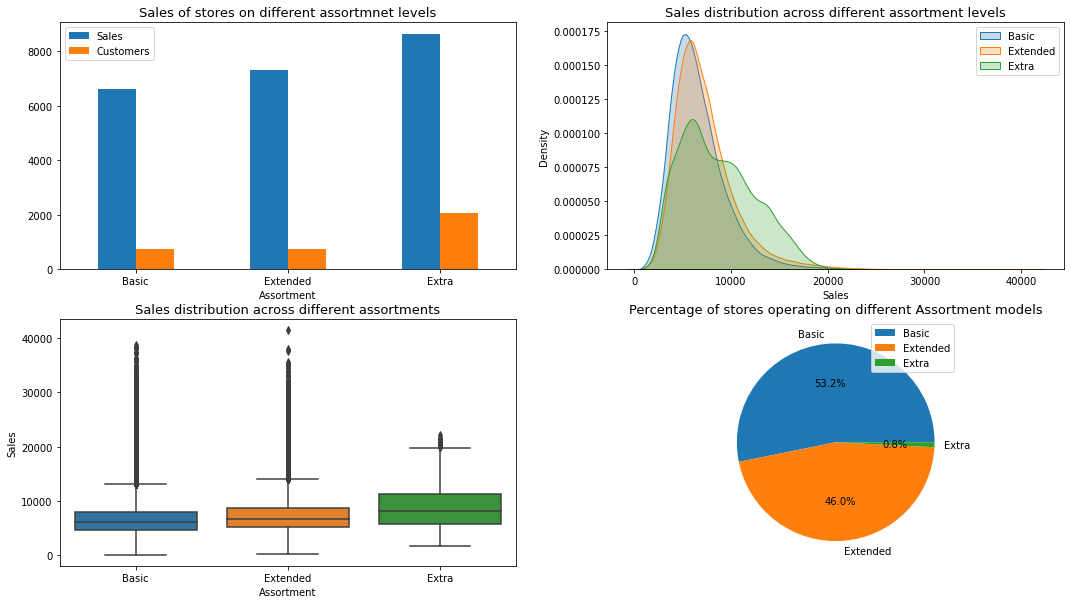

In [108]:
#____________________________________________BLOCK 73______________________________________________________

#visualising average sales and average no. of customers for different assortments
fig, axes = plt.subplots(2,2, figsize = (18,10))
colors = {'Basic':'blue', 'Extended': 'orange','Extra':'y'}
alphas = {'Basic':0.4, 'Extended': 0.4,'Extra':1.0}

#bar plot representing average sales and average no. of customers for different assortments
rossman_stores_data.groupby('Assortment').agg({'Sales':'mean', 'Customers':'mean'}).plot.bar( ax = axes[0][0])   
rossman_stores_data.groupby('Assortment').agg({'Sales':'mean', 'Customers':'mean'})
axes[0][0].set_title("Sales of stores on different assortmnet levels",fontsize=13)
axes[0][0].set_xticklabels(['Basic', 'Extended','Extra'],rotation = 0)

#kdeplot for sales distribution across different assortment levels
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['Assortment'] == 'Basic']['Sales'], ax = axes[0][1],label = 'Basic', shade = True) 
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['Assortment'] == 'Extended']['Sales'], ax = axes[0][1],label ='Extended', shade = True) 
axs2 = sns.kdeplot(rossman_stores_data[rossman_stores_data['Assortment'] == 'Extra']['Sales'], ax = axes[0][1],label ='Extra', shade = True) 
axs2.set_title('Sales distribution across different assortment levels',fontsize=13)
axs2.legend()  #to show labels on graphs

#box plot showing sales distribution across different assortments
axs3=sns.boxplot(x = 'Assortment', y = 'Sales', data = rossman_stores_data,ax=axes[1][0])
axs3.set_title('Sales distribution across different assortments',fontsize=13)

#pieplot showing percentahe of stores operating with different storetypes
labels = list(stores_data["Assortment"].value_counts().index)
l = axes[1][1].pie(stores_data["Assortment"].value_counts(), labels = labels,autopct='%1.1f%%')
axes[1][1].set_title('Percentage of stores operating on different Assortment models',fontsize=13)
axes[1][1].legend(l[0], labels, loc ='best')
plt.show()
fig.tight_layout() #for proper spacing between figures

*For assortment level extra, both average no. of customers  and average sales is comparatively high*

##***Holiday Indicator***

### *Creating HolidayIndicator Feature*

In [109]:
'''If there is a holiday before or after a sales date then set a holiday indicator as 1 as there should be a
   bit of increase in sales. So we are designing a function to check if there is a holiday of a store before 
   or after date passed and if so set as holiday indicator as 1 else 0'''

#list of dates of stateholiday
dates = list(rossman_stores_data[rossman_stores_data['StateHoliday']!=0]['Date'].value_counts().reset_index()['index'])
#create an empty list for storing a before date of a stateHoliday
before_date = []
#create an empty list for storing a before date of a stateHoliday
after_date = []

#iterating over stateholiday date
for date in dates:
  #storing/appending before dates
  before_date.append(date- datetime.timedelta(days=1))
  #storing/appending after dates
  after_date.append(date + datetime.timedelta(days=1))
#creating an empty lisit to store and indicate a holiday indicator
holiday_indicator= []
#looping over a complete rossman_data
for i in range(len(rossman_stores_data)):
  #if a date of sales data is present in before or after date list appending 1 in holiday_indicator 
  if rossman_stores_data.iloc[i]['Date'] in before_date or rossman_stores_data.iloc[i]['Date'] in after_date:
    holiday_indicator.append(1)
  else:
    #appending a 0 in holiday indicator if 0 is not there 
    holiday_indicator.append(0)
    
#placing a holiday indicator column in dataframe 
rossman_stores_data['HolidayIndicator'] = holiday_indicator                                   

### *Holiday Indicator Analysis*

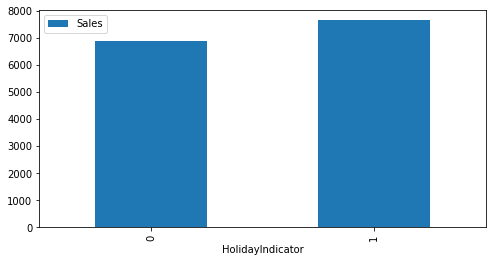

In [110]:
#visualising mean sales of stores with holiday indicator as 0 and 1 
rossman_stores_data.groupby('HolidayIndicator').aggregate({'Sales':'mean'}).plot.bar()

##***Sales outlier Data Analysis***

Text(0.5, 1.0, 'Distribution plot for sales')

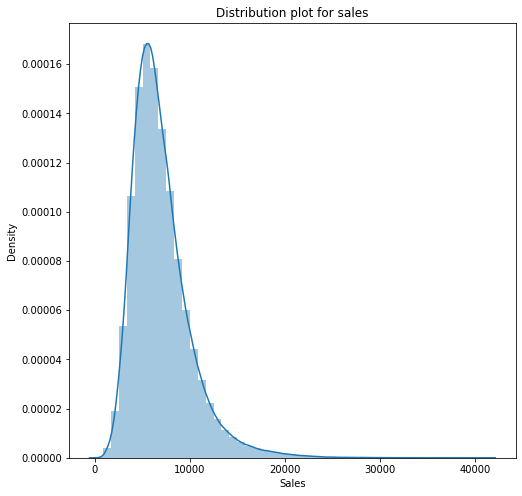

In [111]:
#______________________________________Block 84____________________________________________

#distribution plot for sales, customers, competitiondistance and monthly sales
fig,axs =plt.subplots(1,1,figsize=(8,8))
sns.distplot(rossman_stores_data['Sales'], ax =axs)  
axs.set_title('Distribution plot for sales')

*Sales seems to have some outliers. Lets create a seperate outlier dataset and check for the possible reasons of value being outlier*

In [112]:
#__________________________________________Block 85_______________________________________________________________

#segregating all the rows having sales greater than 18000
outliers_data = rossman_stores_data[rossman_stores_data['Sales']>25000] 

In [113]:
#_________________________________________Block 86______________________________________________________________

#length of dataset 
len(outliers_data)

758

In [114]:
#_____________________________________________Block 87______________________________________________

#descriptive stats of outlier data 
outliers_data.describe()

Store   DayOfWeek         Sales    Customers       Promo  \
count   758.000000  758.000000    758.000000   758.000000  758.000000   
mean    607.547493    3.204485  28046.461741  3467.215040    0.674142   
std     303.770823    2.262002   2653.130920   940.425673    0.469004   
min      27.000000    1.000000  25008.000000   475.000000    0.000000   
25%     262.000000    1.000000  26015.000000  2880.750000    0.000000   
50%     595.000000    2.000000  27294.000000  3625.500000    1.000000   
75%     817.000000    5.000000  29416.250000  4132.250000    1.000000   
max    1114.000000    7.000000  41551.000000  7388.000000    1.000000   

       SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  \
count     758.000000           758.000000                 758.000000   
mean        0.191293         37699.261214                   3.868074   
std         0.393579         47702.616795                   3.371104   
min         0.000000            50.000000                   0.000000   
25%         0.000000           190.000000                   0.000000   
50%         0.000000          1180.000000                   3.000000   
75%         0.000000        100000.000000                   5.000000   
max         1.000000        100000.000000                  12.000000   

       CompetitionOpenSinceYear      Promo2  Promo2SinceWeek  Promo2SinceYear  \
count                758.000000  758.000000       758.000000       758.000000   
mean                1450.216359    0.135884         4.076517       273.277045   
std                  901.300781    0.342892        11.257850       689.591641   
min                    0.000000    0.000000         0.000000         0.000000   
25%                    0.000000    0.000000         0.000000         0.000000   
50%                 2006.000000    0.000000         0.000000         0.000000   
75%                 2013.000000    0.000000         0.000000         0.000000   
max                 2015.000000    1.000000        45.000000      2015.000000   

       avg_cust_visit_per_day  avg_sales_per_day  avg_sales_per_customer  \
count              758.000000         758.000000              758.000000   
mean              2622.334273       18654.204971                7.673416   
std                811.098767        3592.195339                2.298376   
min                543.812580        5774.090078                5.581704   
25%               2096.335459       17294.716667                6.408006   
50%               3130.573980       20666.562500                6.949998   
75%               3200.946429       20718.515924                7.803764   
max               3402.010616       21757.483418               16.162639   

            month         year  DateOfMonth  WeekofYear  Promo2Indicator  \
count  758.000000   758.000000   758.000000  758.000000       758.000000   
mean     7.482850  2013.708443    16.102902   30.781003         0.130607   
std      3.731631     0.755924     9.582154   16.377549         0.337192   
min      1.000000  2013.000000     1.000000    1.000000         0.000000   
25%      4.000000  2013.000000     7.000000   17.000000         0.000000   
50%      6.000000  2014.000000    16.000000   27.000000         0.000000   
75%     12.000000  2014.000000    23.000000   50.000000         0.000000   
max     12.000000  2015.000000    31.000000   52.000000         1.000000   

       HolidayIndicator  
count        758.000000  
mean           0.131926  
std            0.338634  
min            0.000000  
25%            0.000000  
50%            0.000000  
75%            0.000000  
max            1.000000

*From above descriptive stats we can see that some of these outliers are getting justified by the customers count*  

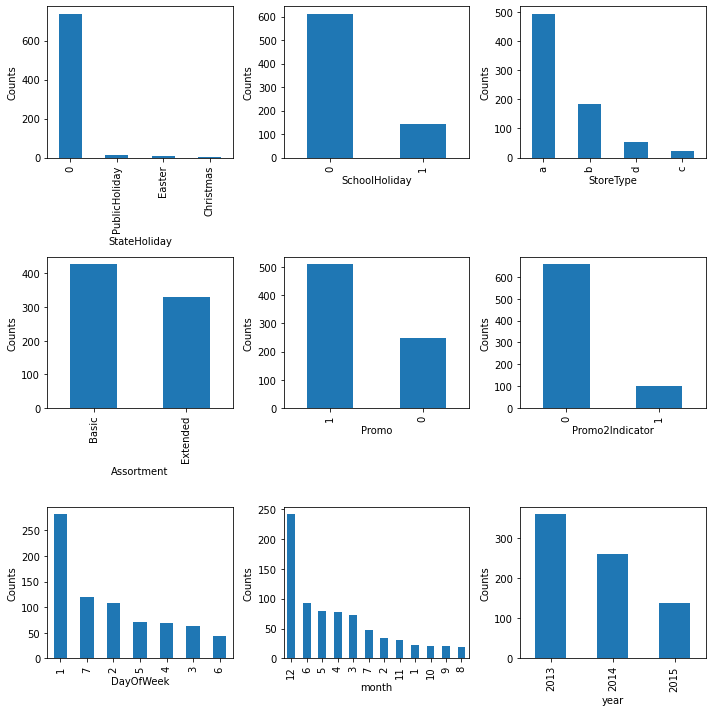

In [115]:
#____________________________________________Block 88_______________________________________________________________

#visualising if outliers are defined by any of the cat_features
cat_features = ['StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo', 'Promo2Indicator', 'DayOfWeek', 'month', 'year']
fig, axes=plt.subplots(3,3, figsize = (10,10))
k =0
for i in range(3):
  for j in range(3):
    axs =  outliers_data[cat_features[k]].value_counts().plot.bar(ax = axes[i][j])  #bar plots for each cataegorical feature
    axs.set_ylabel('Counts')
    axs.set_xlabel(cat_features[k])
    k = k+1
fig.tight_layout()

*There are various other features that is defining these outliers such as 12th month, Promo =1, store types and assortments*

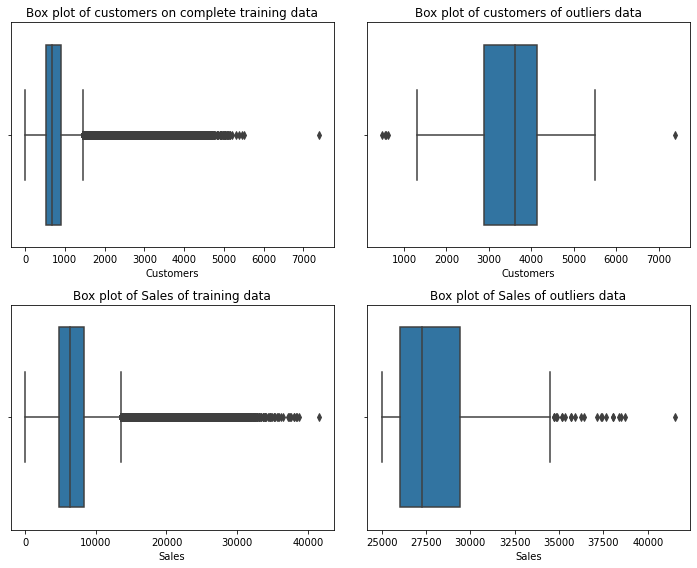

In [116]:
#_____________________________________________Block 89_________________________________________________

#box plots to understand outliers 
fig, axes = plt.subplots(2,2,figsize=(10,8))
axes1 = sns.boxplot(rossman_stores_data['Customers'], ax = axes[0][0])    
axes1.set_title('Box plot of customers on complete training data')
axes2 = sns.boxplot(outliers_data['Customers'], ax = axes[0][1])
axes2.set_title('Box plot of customers of outliers data')
axes3 = sns.boxplot(rossman_stores_data['Sales'], ax = axes[1][0])
axes3.set_title('Box plot of Sales of training data')
axes4 = sns.boxplot(outliers_data['Sales'], ax = axes[1][1])
axes4.set_title('Box plot of Sales of outliers data')
fig.tight_layout()

*From these box plots we can see that stores having very high sales is because of higher customers visit*

##***Conclusions from EDA***

* *There is linear relation between customers and sales but have high variance which can be dependable on factors like competition distance, promo etc.*

* *Sales varies with respect to month, weekday. Sale is high on sundays and mondays and also in the december month which is a festive month.*

* *Company sale is growing at a slow pace every year.*

* *Promos, SchoolHoliday are working in favour of sales.*

* *For most of the stores promo2 seems to be effective as we have seen the increase in average sales of a store after participating in promo2.*

* *Stores operating on state holidays have higher sales on these days in comparison to the days when there is no state holiday.*

* *Stores having their competitors nearby seems to have lower sales as compare to store having no competitors or far away competitors.*

* *Store model B and assortment level Extra has both high average number of customers and average sales comparatively.*

# ***Part 4 : Predictive Modelling***

## ***Train test data Seperation***

*We'll sort the data by date in order to get a historical data in training and future data in test data*

In [117]:
#_________________________________________Block 75_________________________________________________

rossman_stores_data.info()  # info to check for conversion of datetime object

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Promo                      844338 non-null  int64         
 6   StateHoliday               844338 non-null  object        
 7   SchoolHoliday              844338 non-null  int64         
 8   StoreType                  844338 non-null  object        
 9   Assortment                 844338 non-null  object        
 10  CompetitionDistance        844338 non-null  float64       
 11  CompetitionOpenSinceMonth  844338 non-null  int64  

In [118]:
#heads to visualise first 5 rows 
rossman_stores_data.head()

Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555      1            0   
1      1          4 2015-07-30   5020        546      1            0   
2      1          3 2015-07-29   4782        523      1            0   
3      1          2 2015-07-28   5011        560      1            0   
4      1          1 2015-07-27   6102        612      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c      Basic               1270.0   
1              1         c      Basic               1270.0   
2              1         c      Basic               1270.0   
3              1         c      Basic               1270.0   
4              1         c      Basic               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                          9                      2008       0   
1                          9                      2008       0   
2                          9                      2008       0   
3                          9                      2008       0   
4                          9                      2008       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval Promo2SinceDate  \
0                0                0             0               0   
1                0                0             0               0   
2                0                0             0               0   
3                0                0             0               0   
4                0                0             0               0   

  CompetitionOpenSinceDate  avg_cust_visit_per_day  avg_sales_per_day  \
0      2008-09-01 00:00:00              564.049936        4759.096031   
1      2008-09-01 00:00:00              564.049936        4759.096031   
2      2008-09-01 00:00:00              564.049936        4759.096031   
3      2008-09-01 00:00:00              564.049936        4759.096031   
4      2008-09-01 00:00:00              564.049936        4759.096031   

   avg_sales_per_customer  month  year  DateOfMonth  WeekofYear  \
0                8.437366      7  2015           31          31   
1                8.437366      7  2015           30          31   
2                8.437366      7  2015           29          31   
3                8.437366      7  2015           28          31   
4                8.437366      7  2015           27          31   

   Promo2Indicator     comp_dist_categories  HolidayIndicator  
0                0  compet_dist in 0 & 2000                 0  
1                0  compet_dist in 0 & 2000                 0  
2                0  compet_dist in 0 & 2000                 0  
3                0  compet_dist in 0 & 2000                 0  
4                0  compet_dist in 0 & 2000                 0

In [119]:
#sorting stores data by date and Store to perform temporal split
rossman_stores_data.sort_values(by=['Date','Store'], inplace = True)

***Splitting Training and Testing data***

In [120]:
'''In this block we are splitting our training and testing data in such a way that data till Nov 2014 will be considered as 
   train data and data post nov2014 is test data '''

#threshold date to perform a temporal split
threshld_date = datetime.datetime.strptime('2014-11-30','%Y-%m-%d')
train_data = rossman_stores_data[rossman_stores_data['Date']<=threshld_date]  # getting a train data 
test_data = rossman_stores_data[rossman_stores_data['Date'] > threshld_date]  #getting a test data

In [121]:
#checking last 5 rows of train data 
train_data.tail()

Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
666971     733          7 2014-11-30  17371       3547      0            0   
699963     769          7 2014-11-30  14047       3161      0            0   
863429     948          7 2014-11-30  11610       2110      0            0   
985586    1081          7 2014-11-30   7547       1017      0            0   
1000290   1097          7 2014-11-30  13662       2519      0            0   

         SchoolHoliday StoreType Assortment  CompetitionDistance  \
666971               0         b      Extra                860.0   
699963               0         b      Extra             100000.0   
863429               0         b      Extra             100000.0   
985586               0         b      Basic                400.0   
1000290              0         b      Extra                720.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
666971                          10                      1999       0   
699963                           0                         0       1   
863429                           0                         0       0   
985586                           3                      2006       0   
1000290                          3                      2002       0   

         Promo2SinceWeek  Promo2SinceYear    PromoInterval  \
666971                 0                0                0   
699963                48             2012  Jan,Apr,Jul,Oct   
863429                 0                0                0   
985586                 0                0                0   
1000290                0                0                0   

             Promo2SinceDate CompetitionOpenSinceDate  avg_cust_visit_per_day  \
666971                     0      1999-10-01 00:00:00             3403.458599   
699963   2012-11-26 00:00:00                        0             3081.052017   
863429                     0                        0             1712.427802   
985586                     0      2006-03-01 00:00:00              937.178336   
1000290                    0      2002-03-01 00:00:00             2420.921444   

         avg_sales_per_day  avg_sales_per_customer  month  year  DateOfMonth  \
666971        14933.288747                4.387680     11  2014           30   
699963        10825.902335                3.513703     11  2014           30   
863429         6936.760776                4.050834     11  2014           30   
985586         5924.919419                6.322083     11  2014           30   
1000290        9744.599788                4.025161     11  2014           30   

         WeekofYear  Promo2Indicator        comp_dist_categories  \
666971           48                0     compet_dist in 0 & 2000   
699963           48                1  compet_dist more than 8000   
863429           48                0  compet_dist more than 8000   
985586           48                0     compet_dist in 0 & 2000   
1000290          48                0     compet_dist in 0 & 2000   

         HolidayIndicator  
666971                  0  
699963                  0  
863429                  0  
985586                  0  
1000290                 0

In [122]:
#checking first 5 rows of data 
test_data.head()

Store  DayOfWeek       Date  Sales  Customers  Promo StateHoliday  \
242       1          1 2014-12-01   7380        723      1            0   
1184      2          1 2014-12-01   8674        783      1            0   
2126      3          1 2014-12-01  10369        962      1            0   
3068      4          1 2014-12-01  12359       1608      1            0   
4010      5          1 2014-12-01   8580        783      1            0   

      SchoolHoliday StoreType Assortment  CompetitionDistance  \
242               0         c      Basic               1270.0   
1184              0         a      Basic                570.0   
2126              0         a      Basic              14130.0   
3068              0         c   Extended                620.0   
4010              0         a      Basic             100000.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
242                           9                      2008       0   
1184                         11                      2007       1   
2126                         12                      2006       1   
3068                          9                      2009       0   
4010                          4                      2015       0   

      Promo2SinceWeek  Promo2SinceYear    PromoInterval      Promo2SinceDate  \
242                 0                0                0                    0   
1184               13             2010  Jan,Apr,Jul,Oct  2010-03-29 00:00:00   
2126               14             2011  Jan,Apr,Jul,Oct  2011-04-04 00:00:00   
3068                0                0                0                    0   
4010                0                0                0                    0   

     CompetitionOpenSinceDate  avg_cust_visit_per_day  avg_sales_per_day  \
242       2008-09-01 00:00:00              564.049936        4759.096031   
1184      2007-11-01 00:00:00              583.998724        4953.900510   
2126      2006-12-01 00:00:00              750.077022        6942.568678   
3068      2009-09-01 00:00:00             1321.752551        9638.401786   
4010      2015-04-01 00:00:00              537.340180        4676.274711   

      avg_sales_per_customer  month  year  DateOfMonth  WeekofYear  \
242                 8.437366     12  2014            1          49   
1184                8.482725     12  2014            1          49   
2126                9.255808     12  2014            1          49   
3068                7.292138     12  2014            1          49   
4010                8.702634     12  2014            1          49   

      Promo2Indicator        comp_dist_categories  HolidayIndicator  
242                 0     compet_dist in 0 & 2000                 0  
1184                1     compet_dist in 0 & 2000                 0  
2126                1  compet_dist more than 8000                 0  
3068                0     compet_dist in 0 & 2000                 0  
4010                0  compet_dist more than 8000                 0

In [123]:
#____________________________________________Block 78_____________________________________________________

#as rows are sorted in date order in both train and test data we'll shuffle train and test data
# train_data = train_data.sample(frac=1)
# test_data = test_data.sample(frac=1)

*We have sorted the data here by date and then splitted the data into 75-25.*

## ***Features Transformation Analysis and Functions designing for feature transformatiuon***

#### *Sales variable*

Text(0.5, 1.0, 'Distribution plot for sales')

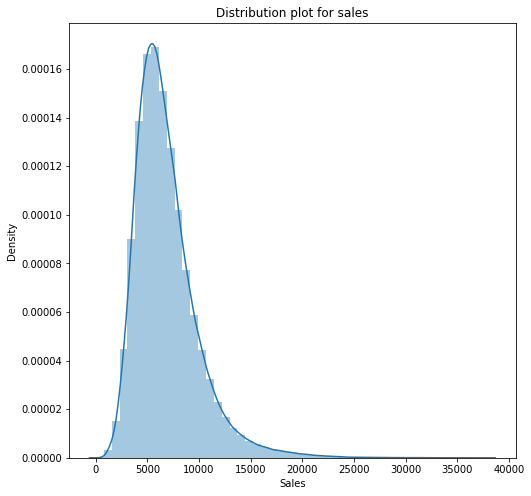

In [124]:
#____________________________________Block 91____________________________________________

#distribution plot for sales
fig,axs =plt.subplots(1,1,figsize=(8,8))
sns.distplot(train_data['Sales'], ax =axs)  
axs.set_title('Distribution plot for sales')

*As seen earler in EDA these outlier in a Sales is defined by various variable like Promo, customer_visit,etc. So We will not remove these outliers and will try to transform it to transform it to normal distribution*




*Square Root Transformation*

Text(0.5, 1.0, 'Distribution plot for sales')

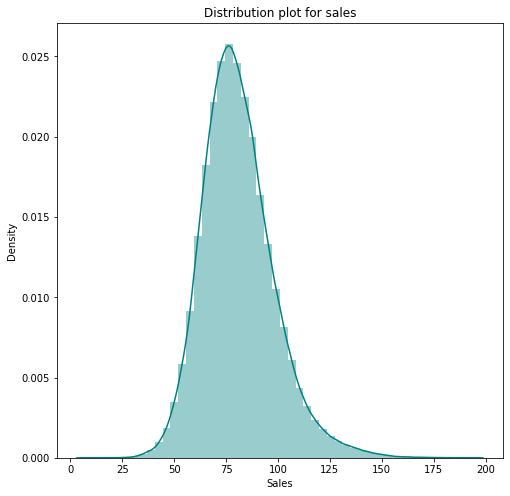

In [125]:
#______________________________________Block 92____________________________________

#square root transformation
fig,axs =plt.subplots(1,1,figsize=(8,8))
sns.distplot(np.sqrt(train_data['Sales']), ax =axs,color='teal')   #distribution plot of features after applying cube root transformation
axs.set_title('Distribution plot for sales')

*Square root transformation is transforming sales data into normal distribution. We will design a function that will transform sales variable into normally distributed variable and later on it can be used for transformation*

#### *Competition Variable*

Text(0.5, 1.0, 'Distribution plot for Competition Distance')

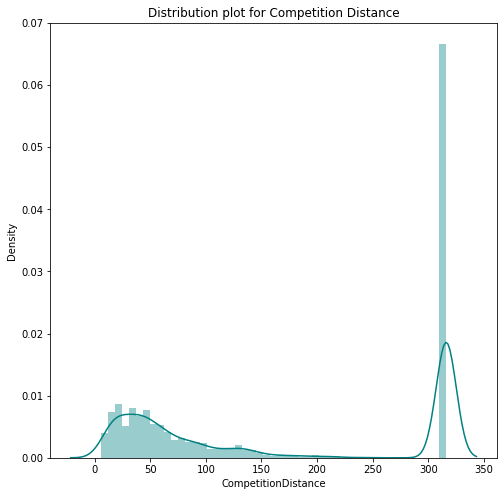

In [126]:
#distribution plot for competitionDistance

fig,axs =plt.subplots(1,1,figsize=(8,8))
sns.distplot(np.sqrt(train_data['CompetitionDistance']), ax =axs,color='teal')   #distribution plot of features after applying cube root transformation
axs.set_title('Distribution plot for Competition Distance')

Text(0.5, 1.0, 'Distribution plot for Competition Distance')

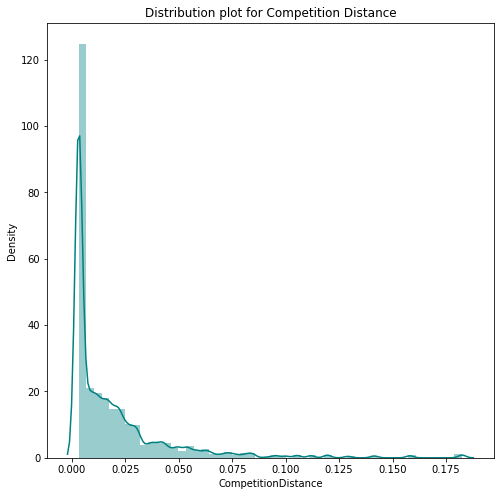

In [127]:
#Inverse square root transformation on competition distance 

fig,axs =plt.subplots(1,1,figsize=(8,8))
sns.distplot(1/np.sqrt(train_data['CompetitionDistance']), ax =axs,color='teal')   #distribution plot of features after applying cube root transformation
axs.set_title('Distribution plot for Competition Distance')

In [128]:
#__________________________________________Block 93___________________________________________

#function for Square transformation of features
def sqrt_transformation(feature):
  return (np.sqrt(feature))

#function for inverse Square transformation of features
def inv_sqrt_transformation(feature):
  return (1/np.sqrt(feature))

#### *Day Of Week*

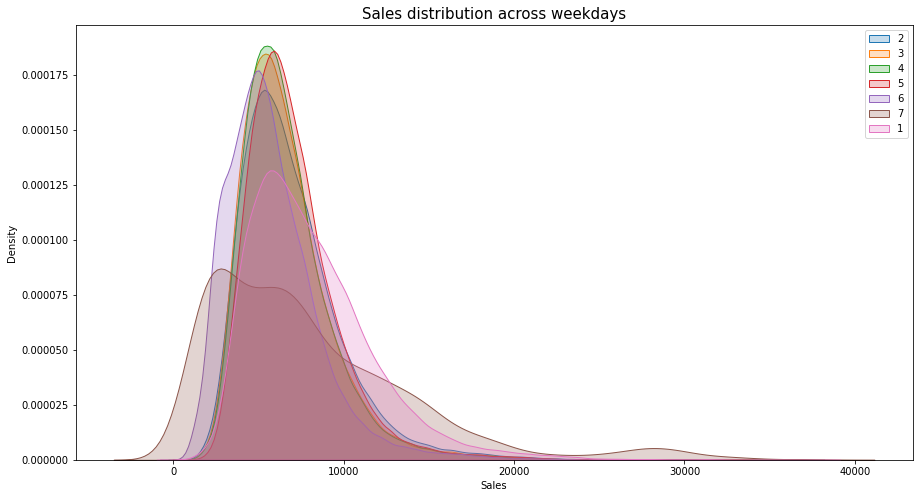

In [129]:
#_________________________________________Block 97_______________________________________________________

#checking for distribution of sales in each day of week
plt.figure(figsize=(15,8))
for val in train_data['DayOfWeek'].unique():   
  #iterating over unique values of weekdays to visualise distribution of sales across each weekday
  sns.kdeplot(train_data[train_data['DayOfWeek']==val]['Sales'] ,label = val,shade=True)   #kde plot
plt.title('Sales distribution across weekdays',fontsize=15)
plt.legend()   #to give legends in the plot
plt.show()

*Seeing Sales distribution for weeks, distribution of sales over weekdays(tuesday - friday) is almost similar whereas sales for saturday, sunday and monday is different*



In [130]:
#_____________________________________Block 98______________________________________________________


#defining a function to perform label encoding in dayofweek feature
def dayofweek_conversion(x):
#assigning integral values corresponding to different categories of dayofweek feature on the basis of their contribution to sales
  if x == 1:   #monday
    return 'Mon'
  if x == 6:   #saturday
    return 'Sat'
  if x == 7:   #sunday
    return 'sun'  
  else:        #days other than monday
    return 'Weekday'

#### *Month of Year*

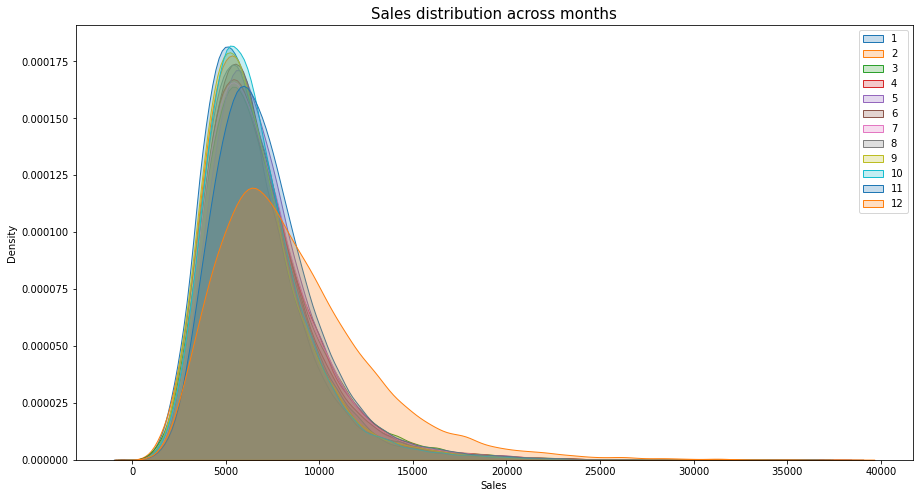

In [131]:
#________________________________________Block 100________________________________________________________

#checking for distribution of sales in each day of month
plt.figure(figsize=(15,8))
for val in train_data['month'].unique():   
  #iterating over unique values of weekdays to visualise distribution of sales across each weekday
  sns.kdeplot(train_data[train_data['month']==val]['Sales'] ,label = val,shade=True)   #kde plot
plt.title('Sales distribution across months',fontsize=15)
plt.legend()   #to give legends in the plot
plt.show()

*For month 12 and 11 there is a slight difference in sales else all months have nearly similar sales*

In [132]:
#__________________________________________Block 101_______________________________________________________

#defining a function to perform label encoding in month feature
def month_to_int(x):
#assigning integral values corresponding to different categories of month feature on the basis of their contribution to sales
  if x == 12:    #month of December
    return 2
  elif x==11:    #month of November
    return 1  
  else:          #other months
    return 0

#### *Function to perform one hot encoding on features*

In [133]:
#_______________________________________________________Block 95______________________________________

#function designed to perform one hot encoding of the features passed in encode features 
def one_hot_encoding(train_data, test_data, encode_features, drop_first=False):
  #if drop first is True then remove one created variable for each feature to avoid dummy variable trap 
  if drop_first == True:
    dummies_train = pd.get_dummies(train_data[encode_features], drop_first = True)  #one hot encoding of encode features of train data
    train_data = pd.concat([train_data, dummies_train], axis =1)   #concatenating dummy data to orignal data 
    train_data.drop(columns = encode_features, inplace = True)     #droping the orignal columns as encoded variables are present
    dummies_test = pd.get_dummies(test_data[encode_features], drop_first = True)   #one hot encoding of encode features of test data
    test_data = pd.concat([test_data, dummies_test], axis =1)      #concatenating dummy data to orignal data 
    test_data.drop(columns = encode_features, inplace = True)      #droping the orignal columns as encoded variables are present
    return (train_data, test_data)
    
  #if drop first is false then apply similar except keeping drop_first True
  else:
    dummies_train = pd.get_dummies(train_data[encode_features])  
    train_data = pd.concat([train_data, dummies_train], axis =1)   
    train_data.drop(columns = encode_features, inplace = True) 
    dummies_test = pd.get_dummies(test_data[encode_features])   
    test_data = pd.concat([test_data, dummies_test], axis =1)
    test_data.drop(columns = encode_features, inplace = True)
    return (train_data, test_data) 

#### *Function to perform label encoding on features*

In [134]:
#____________________________________________Block 125_____________________________________________________________

#function designing to perform label encoding 
def label_encoding(train_data, test_data, encode_features):
  #dictionary to store encoders 
  encoder_dict ={}
  #fitting encoder on different features
  for feature in encode_features: 
    le = LabelEncoder()  #creating a instance of a labelencoder 
    encoder_dict[feature] = le.fit(train_data[feature]) #fitting a encoder

  #transforming data of different features to their respected fitted encoder
  for feature in encoder_dict.keys():
    #concatenating train data
    train_data[feature] = encoder_dict[feature].transform(train_data[feature])
    #concatenating test data
    test_data[feature] = encoder_dict[feature].transform(test_data[feature])
  #returning train,test data 
  return (train_data, test_data)

# ***Linear Regression model***

##***Basic feature transformation and prepreparation for linear regression models***

In [135]:
#___________________________________Block 79__________________________________________________

reg_train_data = train_data.copy()    #creating a copy of train_data for linear_regression_model
reg_test_data = test_data.copy()      #creating a copy of test_data for linear_regression_model

In [136]:
#columns to drop the features that are used in regression modelling
cols_to_drop = ['Store','Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear' ,'Promo2SinceWeek','Promo2SinceYear','PromoInterval',
               'CompetitionOpenSinceDate','Promo2SinceDate','Promo2','Customers',
                'avg_sales_per_day','comp_dist_categories','DateOfMonth', 'WeekofYear']

*From EDA these features doesn't seems to be useful in our regression model building*

In [137]:
#_____________________________________Block 82__________________________________________

#deleting some of the unnecessary columns first from train_data 
reg_train_data.drop(columns=cols_to_drop,inplace= True)
#deleting some of the unnecessary columns first from test data as well 
reg_test_data.drop(columns=cols_to_drop,inplace= True)

In [138]:
#info check of dataset
reg_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 624817 entries, 77677 to 1000290
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   DayOfWeek               624817 non-null  int64  
 1   Sales                   624817 non-null  int64  
 2   Promo                   624817 non-null  int64  
 3   StateHoliday            624817 non-null  object 
 4   SchoolHoliday           624817 non-null  int64  
 5   StoreType               624817 non-null  object 
 6   Assortment              624817 non-null  object 
 7   CompetitionDistance     624817 non-null  float64
 8   avg_cust_visit_per_day  624817 non-null  float64
 9   avg_sales_per_customer  624817 non-null  float64
 10  month                   624817 non-null  int64  
 11  year                    624817 non-null  int64  
 12  Promo2Indicator         624817 non-null  int64  
 13  HolidayIndicator        624817 non-null  int64  
dtypes: float64(3), 

In [139]:
#applying a square root transformation on sales transformation on train and test data
reg_train_data['Sales'] = reg_train_data['Sales'].apply(sqrt_transformation)
reg_test_data['Sales'] =  reg_test_data['Sales'].apply(sqrt_transformation)

#applying a inverse square root transformation on sales transformation on train and test data
reg_train_data['CompetitionDistance'] = reg_train_data['CompetitionDistance'].apply(inv_sqrt_transformation)
reg_test_data['CompetitionDistance'] =  reg_test_data['CompetitionDistance'].apply(inv_sqrt_transformation)

#applying a feature transformation function on day of week on train and test data
reg_train_data['DayOfWeek'] = reg_train_data['DayOfWeek'].apply(dayofweek_conversion)   
reg_test_data['DayOfWeek'] = reg_test_data['DayOfWeek'].apply(dayofweek_conversion)     

##applying a label encoding function on month feature on train and test data
reg_train_data['month'] = reg_train_data['month'].apply(month_to_int)   
reg_test_data['month'] = reg_test_data['month'].apply(month_to_int)     

In [140]:
#features selected for one hot encoding 
encode_features = ['StateHoliday', 'StoreType', 'Assortment','DayOfWeek','year']  

#applying one_hot_encoding function to encode_features
reg_train_data, reg_test_data = one_hot_encoding(reg_train_data, reg_test_data, encode_features, drop_first=True)

In [141]:
#_____________________________________Block 83___________________________________________________

#descriptive table for basic statistical summary
reg_train_data.describe()   

Sales          Promo  SchoolHoliday  CompetitionDistance  \
count  624817.000000  624817.000000  624817.000000        624817.000000   
mean       80.936648       0.441803       0.201787             0.018632   
std        17.371313       0.496602       0.401334             0.025103   
min         6.782330       0.000000       0.000000             0.003162   
25%        69.159237       0.000000       0.000000             0.003162   
50%        79.202273       0.000000       0.000000             0.008874   
75%        90.752410       1.000000       0.000000             0.023250   
max       195.030767       1.000000       1.000000             0.182574   

       avg_cust_visit_per_day  avg_sales_per_customer          month  \
count           624817.000000           624817.000000  624817.000000   
mean               763.231053                9.584966       0.168374   
std                365.578619                1.983263       0.475534   
min                240.183099                3.513703       0.000000   
25%                544.411012                8.098467       0.000000   
50%                682.828798                9.405620       0.000000   
75%                870.084615               10.922422       0.000000   
max               3403.458599               16.162639       2.000000   

       Promo2Indicator  HolidayIndicator  StateHoliday_Christmas  \
count    624817.000000     624817.000000           624817.000000   
mean          0.405839          0.069846                0.000058   
std           0.491054          0.254888                0.007590   
min           0.000000          0.000000                0.000000   
25%           0.000000          0.000000                0.000000   
50%           0.000000          0.000000                0.000000   
75%           1.000000          0.000000                0.000000   
max           1.000000          1.000000                1.000000   

       StateHoliday_Easter  StateHoliday_PublicHoliday    StoreType_b  \
count        624817.000000               624817.000000  624817.000000   
mean              0.000154                    0.000802       0.018341   
std               0.012394                    0.028305       0.134183   
min               0.000000                    0.000000       0.000000   
25%               0.000000                    0.000000       0.000000   
50%               0.000000                    0.000000       0.000000   
75%               0.000000                    0.000000       0.000000   
max               1.000000                    1.000000       1.000000   

         StoreType_c    StoreType_d  Assortment_Extended  Assortment_Extra  \
count  624817.000000  624817.000000        624817.000000     624817.000000   
mean        0.133991       0.305949             0.463849          0.009688   
std         0.340643       0.460808             0.498692          0.097948   
min         0.000000       0.000000             0.000000          0.000000   
25%         0.000000       0.000000             0.000000          0.000000   
50%         0.000000       0.000000             0.000000          0.000000   
75%         0.000000       1.000000             1.000000          0.000000   
max         1.000000       1.000000             1.000000          1.000000   

       DayOfWeek_Sat  DayOfWeek_Weekday  DayOfWeek_sun  
count  624817.000000      624817.000000  624817.000000  
mean        0.171064           0.661941       0.004304  
std         0.376566           0.473049       0.065461  
min         0.000000           0.000000       0.000000  
25%         0.000000           0.000000       0.000000  
50%         0.000000           1.000000       0.000000  
75%         0.000000           1.000000       0.000000  
max         1.000000           1.000000       1.000000

In [142]:
#__________________________________________Block 111_______________________________________

#standardizing input variables
scale = StandardScaler()
reg_train_data[['avg_cust_visit_per_day']] = scale.fit_transform(reg_train_data[['avg_cust_visit_per_day']])  #train data standardization
reg_test_data[['avg_cust_visit_per_day']] = scale.fit_transform(reg_test_data[['avg_cust_visit_per_day']])    #test data standardization
reg_train_data[['avg_sales_per_customer']] = scale.fit_transform(reg_train_data[['avg_sales_per_customer']])  #train data standardization
reg_test_data[['avg_sales_per_customer']] = scale.fit_transform(reg_test_data[['avg_sales_per_customer']])    #test data standardization

##***Checking correlation with Sales variable***

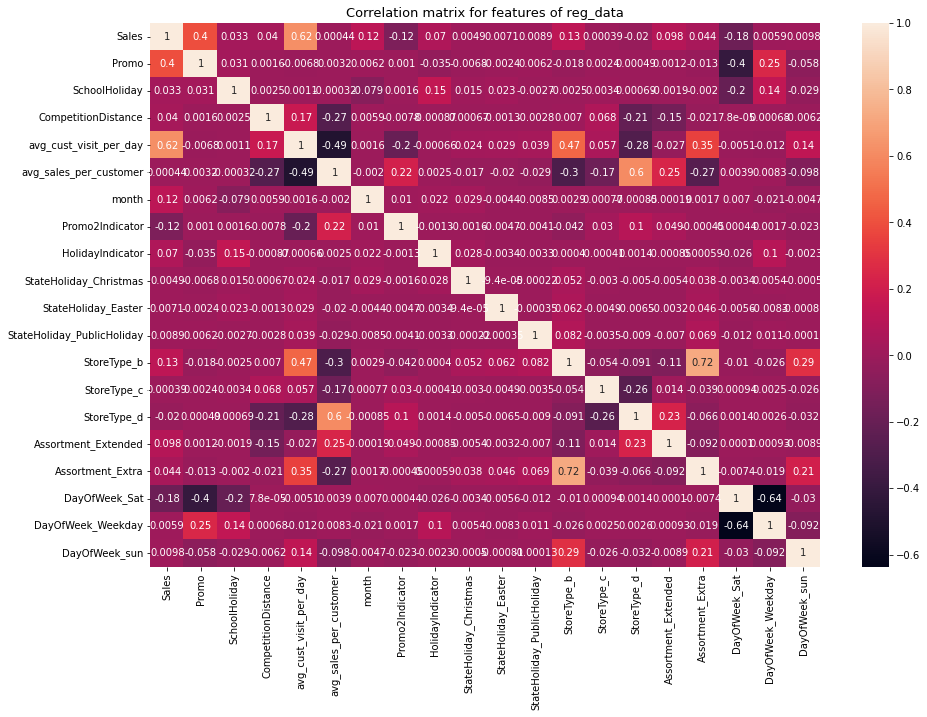

In [143]:
#_________________________________________Block 104_______________________________________________

#correlation matrix
plt.figure(figsize=(15,10))
sns.heatmap(reg_train_data.corr(), annot =True)   #heatmap to show correlation between features
plt.title('Correlation matrix for features of reg_data',fontsize=13)
plt.show()

*Collinearity of Sales varibale with other variables doesn't seems to be high as most of them are categorical variable but in our previous analysis and EDA that sales are varying with these variables thus we will not remove any feature*

##***Checking for multicollinearity***

In [144]:
#______________________________________________Block 105_______________________________________

#function to check for multicollinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(a): 
   # Calculating VIF (variance inflation factor)
   vif = pd.DataFrame()
   vif["variables"] = a.columns
   vif["VIF"] = [variance_inflation_factor(a.values, j) for j in range(a.shape[1])]
   return(vif)

In [145]:
#___________________________________Block 106__________________________________________________

#applying above defined function in reg_data to calculate VIF
calc_vif(reg_train_data.drop(columns=['Sales']))

variables       VIF
0                        Promo  1.866930
1                SchoolHoliday  1.295958
2          CompetitionDistance  1.627106
3       avg_cust_visit_per_day  1.635358
4       avg_sales_per_customer  2.084100
5                        month  1.117733
6              Promo2Indicator  1.731999
7             HolidayIndicator  1.116222
8       StateHoliday_Christmas  1.004902
9          StateHoliday_Easter  1.005207
10  StateHoliday_PublicHoliday  1.008777
11                 StoreType_b  2.548154
12                 StoreType_c  1.242132
13                 StoreType_d  2.294155
14         Assortment_Extended  1.939197
15            Assortment_Extra  2.156185
16               DayOfWeek_Sat  1.405852
17           DayOfWeek_Weekday  2.898494
18               DayOfWeek_sun  1.108919

*VIF of alll the variables are low only and below the threshold so we will keep all the variables*

##*Function designed to categorise features into input and output features or dependent and independent variables*

In [146]:
#________________________________________Block 112_____________________________________________

#split data function
def split_data(data):
  x = data[[cols for cols in data.columns if cols not in ['Sales']]]   # predictor/input variables
  y = data['Sales']    #predicting/output variable
  return x,y

## *Function designed to apply all linear models*

In [147]:
#___________________________________Block 113__________________________________________________________

#defining a function to apply different linear models 
def linear_model(predmodel, x, y, hyper_param=None):
  #linear regression model
  if predmodel == 'lr':
    model = LinearRegression()   #we don't have any hyperparameter to tune in basic linear regression  
  
  #ridge regression
  elif predmodel == 'ridge':
    if hyper_param != None:  # if model gets a hyperparameter to tune
      model_1=Ridge()
      #grid search cv for hyperparameters tuning
      grid_model = GridSearchCV(model_1, param_grid = hyper_param, scoring = 'r2', n_jobs = -1, cv=5)
      #fitting models from grid search cv
      grid_model.fit(x,y)
      #printing the best hyperparameters and score that came from grid search cv
      print('Best alpha value : ', grid_model.best_params_, '\n')
      print('Best score value for tuned HyperParameter : ', grid_model.best_score_,'\n')
      #modeling with the best_estimator that came out to be best from different estimators 
      model = grid_model.best_estimator_
    else:   #ridge regression with default parameters if no hyperparameters passed
      model = Ridge()
  
  #lasso regression 
  elif predmodel == 'lasso':
    if hyper_param != None:
      model_1=Lasso()
      #grid search cv for hyperparameters tuning
      grid_model = GridSearchCV(model_1, param_grid = hyper_param, scoring = 'r2', n_jobs = -1, cv=5)
      #fitting models from gridsearch cv
      grid_model.fit(x,y)
      #printing the best hyperparameters and score that came from grid search cv
      print('Best alpha value : ', grid_model.best_params_)
      print('Best score value for tuned HyperParameter : ', grid_model.best_score_)
      #modeling with the best_estimator that came out to be best from different estimators 
      model = grid_model.best_estimator_
    else:    #lasso regression with default parameters if no hyperparameters passed
      model = Lasso()
  
  #to return any one model out of these three depending on if else condition
  return model  

## *Function designed to perform cross validation*

In [148]:
#____________________________________Block 114____________________________________________

#defining a function to apply cross validation
def cross_val(model, data):
  x = data[[cols for cols in data.columns if cols not in ['Sales']]]   # predictor/input variables
  y = data['Sales']    #predicting/output variable
  cv = KFold(n_splits =3, shuffle = True, random_state =1)  # creating 3 splits of data
  cv_scores = cross_val_score(model,x,y,scoring='r2',cv=cv)  #running a cross validation 
  print('R2 Scores for cross validated models are : ',  cv_scores)  #printing model r2 scores
  print('\nAverage r2 score from cross validation for a model is : ',round(np.mean(cv_scores),2))  #average r2 score of model

## *Function designed to show graphs for model performance validation*

In [149]:
#_____________________________________Block 115_____________________________________________

#defining a function to plot different graphs for different algorithms used
def graphs_validation(model, pred, actual,test_data, features,algo_category): 
  
  data_visual = test_data.copy()
  data_visual['pred_sales'] = pred

  #checking if algorithm category is linear
  if algo_category == 'linear':
    plt.figure(1)
    fig,axes = plt.subplots(2,2,figsize=(30,20)) 
    #plotting the distribution of residuals 
    sns.distplot(actual-pred, bins =20 , color ='y', ax = axes[0,0])
    axes[0,0].set_title('Residual Distribution plot')
    axes[0,0].set_xlabel('Residuals')
    
    #plotting the graph to check hetroscadecity
    axes[0,1].scatter(pred,((actual)- (pred)),c='r')
    axes[0,1].set_xlabel('Predicted selling price')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Hetroscadecity depicting Plot')
    
    # checking for the scatter plot between predicted and actual values to check the model performance
    # data_visual.iloc[0:300].groupby('Store').aggregate({'Sales':'sum', 'pred_sales':'sum'}).plot(marker = 'o',ax = axes[1,0])
    # #axes[1,0].plot(range(len(actual)), pred)
    # axes[1,0].set_xlabel('Actual values')
    # axes[1,0].set_ylabel('Predicted Values')
    # axes[1,0].set_title('Actual vs predicted price')
    
    #feature importance
    bars = features
    height = model.coef_
    y_pos = np.arange(len(bars))
    sns.barplot(height,y_pos, ax= axes[1,0], orient='h')
    axes[1,0].set_yticks(y_pos)
    axes[1,0].set_yticklabels(bars)

    axes[1,1].set_axis_off() 

  #checking if algorithm category is tree
  if algo_category =='tree':
     #feature importance 
     plt.figure(1)
     bars = features   #feature names
     height = model.feature_importances_  #getting feature importance of tree based model
     y_pos = np.arange(len(bars))
     plt.barh(y_pos, height)   #horizontal bars
     plt.yticks(y_pos, bars)
     plt.xlabel('Feature importance')  #labelling X axis
     plt.ylabel('Feature')   #labelling Y axis
     plt.title('Feature importance Graph')   #graph title
     
  
  fig2 = plt.figure(figsize=(30,7))
  axs = fig2.add_subplot(111)
  data_visual.groupby('Store').aggregate({'Sales':'sum', 'pred_sales':'sum'}).iloc[0:400].plot(marker = 'o', ax = axs)
  axs.set_xlabel('Store')
  axs.set_ylabel('Sales')
  axs.set_title('Predicted And Actual Sales')

## *Function designed to evaluate models*

In [150]:
#_______________________________________Block 116____________________________________________________

#defining a function to evaluate model performance
def model_eval(model, x_train, y_train, x_test, y_test, algo_category):
  #builiding a model  
  model.fit(x_train,y_train)
  #predicting training and testing data output
  y_pred = model.predict(x_test)
  y_pred_train = model.predict(x_train)
  
  if algo_category == 'linear':
    y_pred = y_pred**2
    y_pred_train = y_pred_train**2
    y_train = y_train**2
    y_test = y_test**2
  #scoring values
  #storing different training data and testing data score
  
  #mean_square_error
  train_mse = round(mean_squared_error(y_train,y_pred_train),2)
  test_mse = round(mean_squared_error(y_test,y_pred),2)

  #root mean square error
  train_rmse = round(np.sqrt(mean_squared_error(y_train,y_pred_train)),2)
  test_rmse = round(np.sqrt(mean_squared_error(y_test,y_pred)),2)
  
  #mean absolute error
  train_mae = round(mean_absolute_error(y_train,y_pred_train),2)
  test_mae = round(mean_absolute_error(y_test,y_pred),2)

  #root mean square percentage error
  train_rmspe = round(np.sqrt(np.sum(np.power(((y_train-y_pred_train)/y_train),2))/len(y_train)),3)
  test_rmspe =  round(np.sqrt(np.sum(np.power(((y_test-y_pred)/y_test),2))/len(y_test)),3)
  
  #r2_score
  train_r2 = round(r2_score(y_train,y_pred_train),2)
  test_r2 = round(r2_score(y_test,y_pred),2)

  #adjusted_r2_score
  train_adjr2 = round(1-(1-r2_score(y_train,y_pred_train))*((x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)),2)
  test_adjr2 = round(1-(1-r2_score(y_test,y_pred))*((x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1)),2)
  
  #training scores print
  print('Train data score card : \n')
  print('MSE for a model over train data is : ',train_mse )
  print('RMSE for a model over train data is : ', train_rmse)
  print('Mean absolute error for train data is : ', train_mae)
  print('Root mean square percentage error for train data is : ', train_rmspe)
  print('R2_score for a model over train data is : ', train_r2)
  print('Adjusted R2_score for a model over train data is :',train_adjr2,'\n')
  
  #testing score print
  print('Test data score card : \n')
  print('MSE for a model over test data is : ',test_mse )
  print('RMSE for a model over test data is : ', test_rmse)
  print('Mean absolute error for train data is : ', test_mae)
  print('Root mean square percentage error for train data is : ', test_rmspe)
  print('R2_score for a model over test data is : ', test_r2)
  print('Adjusted R2_score for a model over test data is :',test_adjr2,'\n')
  
  graphs_validation(model, y_pred, y_test,test_data, x_train.columns, algo_category)
  #dictionary storing all these testing score and this will be the returning value of function
  score_dict = {'Mean Square Error':test_mse, 'Root Mean Square Error':test_rmse,
                'Mean Absolute Error':test_mae,'Root Mean Square Percentage Error':test_rmspe,'R2 Score':test_r2,
                 'Adjusted R2 Score': test_adjr2 }

  #in linear model we have some assumptions related to residuals. Plotting and verifying these assumptions
  return (model,score_dict)

## *Function designed to perform model explainability*

In [151]:
def model_explain_build(model,x_train, x_test):
  # Need to load JS vis in the notebook
  shap.initjs()
  #building a explainer model
  explainer = shap.TreeExplainer(model)
  #train building shap
  shap_values_train = explainer.shap_values(x_train)
  #test building shap
  shap_values_test = explainer.shap_values(x_test)
  #returning explainability variable 
  return (explainer, shap_values_train, shap_values_test)

In [152]:
def model_explaination(explainer, data,shap_value, data_loc =None,Global=False):
  #if global then plot summary for whole data
  if Global:
    shap.summary_plot(shap_value, features=data, feature_names=data.columns)
  #if not then explain a single prediction
  else:
    if data_loc != None:
      shap.force_plot(explainer.expected_value, shap_value[data_loc], features=data.iloc[data_loc], feature_names=data.columns)

## ***Building Basic Linear Regression Model***

Train data score card : 

MSE for a model over train data is :  2616618.03
RMSE for a model over train data is :  1617.6
Mean absolute error for train data is :  1092.76
Root mean square percentage error for train data is :  0.33
R2_score for a model over train data is :  0.72
Adjusted R2_score for a model over train data is : 0.72 

Test data score card : 

MSE for a model over test data is :  3125815.45
RMSE for a model over test data is :  1768.0
Mean absolute error for train data is :  1197.03
Root mean square percentage error for train data is :  0.274
R2_score for a model over test data is :  0.69
Adjusted R2_score for a model over test data is : 0.69 

R2 Scores for cross validated models are :  [0.74144436 0.74043117 0.74112803]

Average r2 score from cross validation for a model is :  0.74

 Time taken to train and cross validating a model is :  4.04  Seconds


<Figure size 576x288 with 0 Axes>

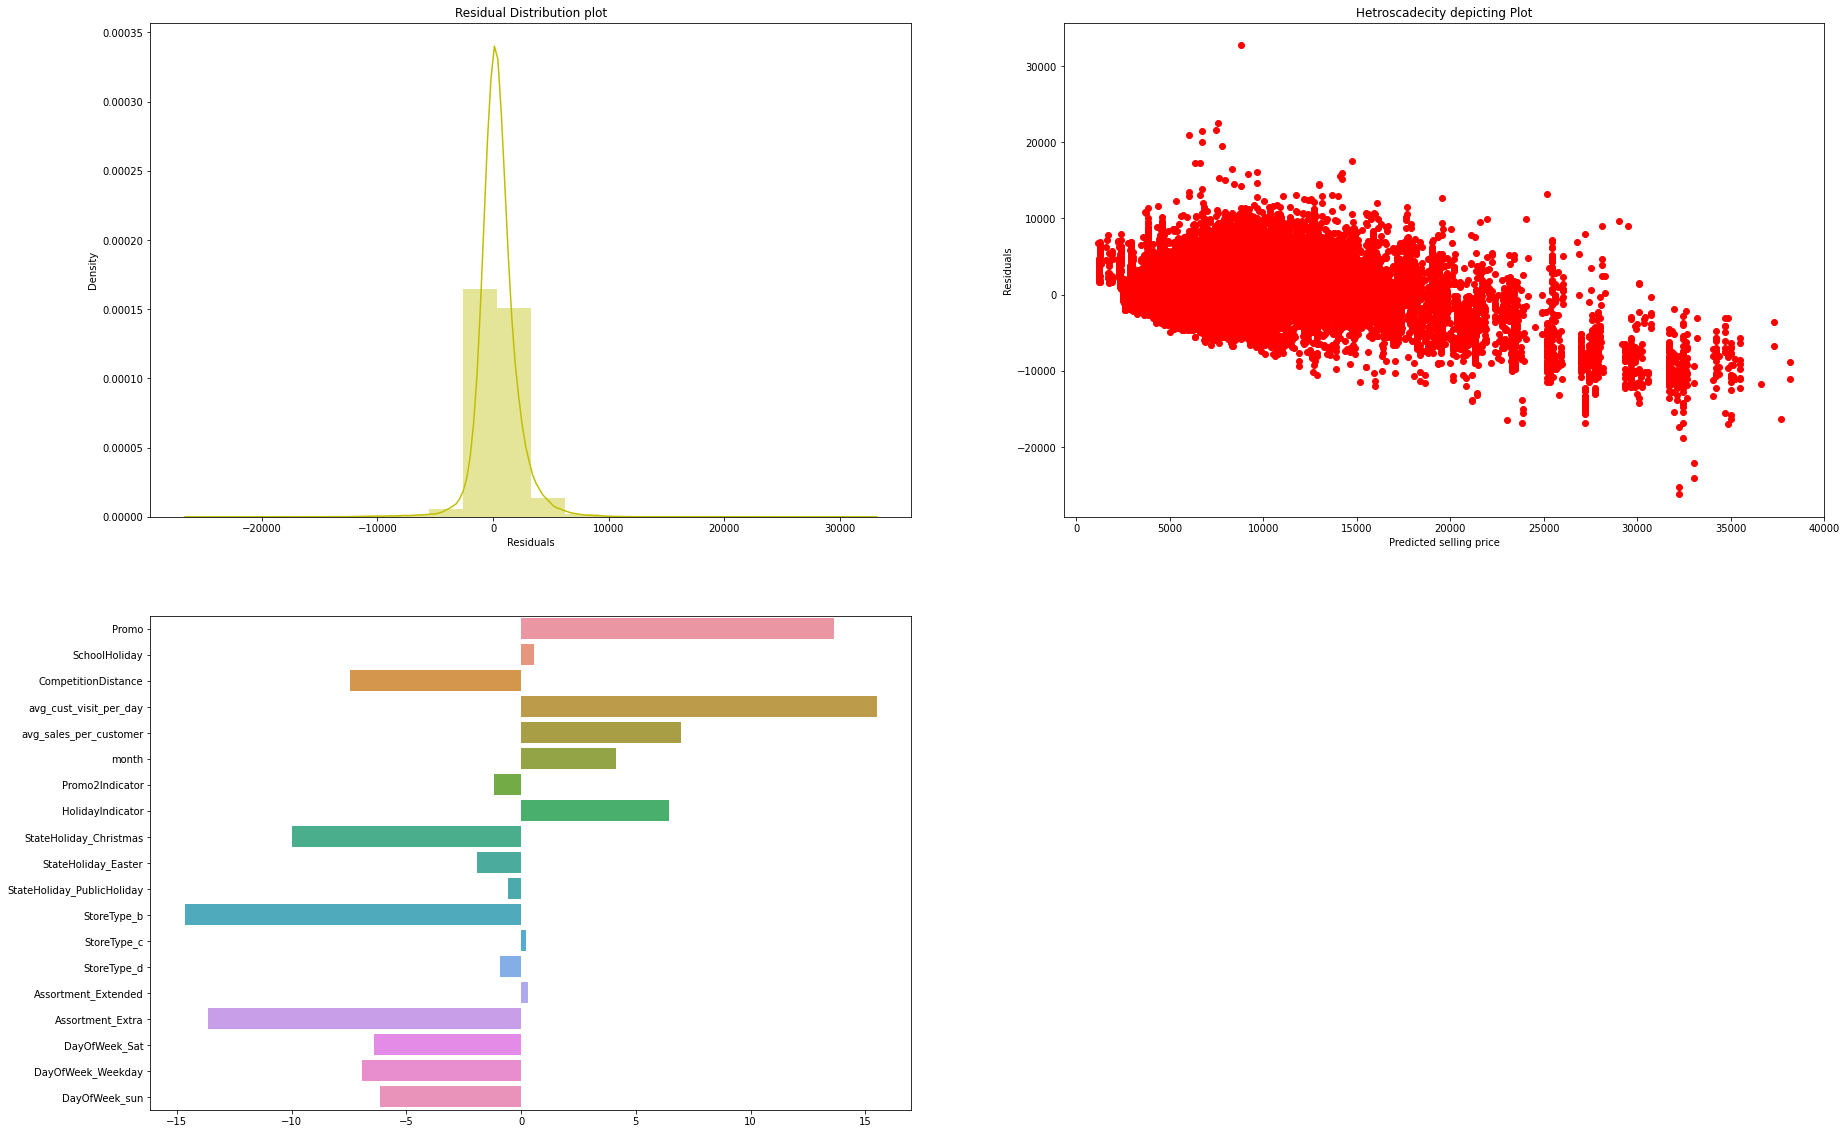

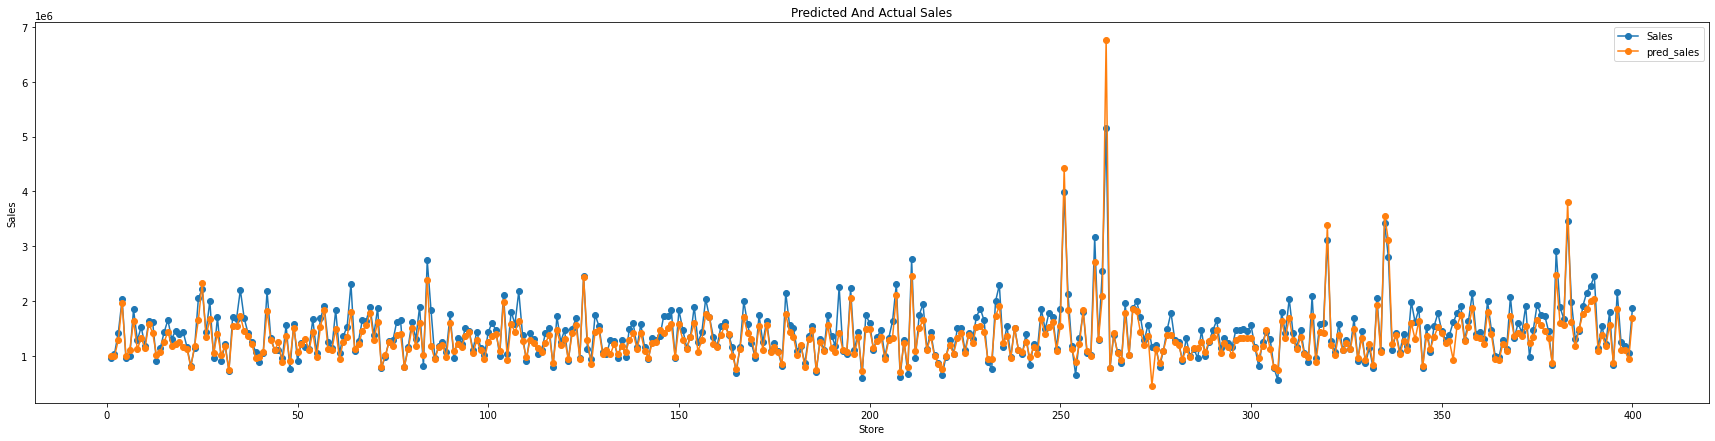

In [153]:
#__________________________________________Block 118_____________________________________________________

x_regtrain,y_regtrain = split_data(reg_train_data)   #calling spilt data function to split train data into input and output variable
x_regtest, y_regtest = split_data(reg_test_data)     #calling spilt data function to split test data into inputs and output variable
start = datetime.datetime.now()
lr_model = linear_model('lr', x_regtrain, y_regtrain)   #lr stands for Simple linear regression
lr_model,lr_score = model_eval(lr_model,x_regtrain,y_regtrain,x_regtest,y_regtest,'linear')   #model evaluation
cross_val(lr_model, reg_train_data)                   #cross validation to cross verifying model performance over different splits
end = datetime.datetime.now()
traintime_lr = (end-start).total_seconds()            #execution time of algorithm 
print('\n Time taken to train and cross validating a model is : ', round(traintime_lr,2), ' Seconds')

*We built basic linear regression model and following points should be noted:*

Following are the Outcomes:

**`1.Training Data R2Score - 0.72 `**

**`2. Test Data R2Score - 0.69`**

**`3. Overall cross validation R2Score - 0.74`**


*1) Model is giving quite decent score and also if we see the metrics for train data and test data both are nearly similar. This indicates that model is neither overfitted nor underfitted.*

*2)However we still apply to demonstrate that as model is not overfitting the scores won't change and will be quite similar to normal regression model* 

##*Buliding Ridge Regression Model*

Best alpha value :  {'alpha': 1e-15} 

Best score value for tuned HyperParameter :  0.7351822833150947 

Train data score card : 

MSE for a model over train data is :  2616618.03
RMSE for a model over train data is :  1617.6
Mean absolute error for train data is :  1092.76
Root mean square percentage error for train data is :  0.33
R2_score for a model over train data is :  0.72
Adjusted R2_score for a model over train data is : 0.72 

Test data score card : 

MSE for a model over test data is :  3125815.45
RMSE for a model over test data is :  1768.0
Mean absolute error for train data is :  1197.03
Root mean square percentage error for train data is :  0.274
R2_score for a model over test data is :  0.69
Adjusted R2_score for a model over test data is : 0.69 

R2 Scores for cross validated models are :  [0.74144436 0.74043117 0.74112803]

Average r2 score from cross validation for a model is :  0.74

 Time taken to train and cross validating a model is :  4.04  Seconds


<Figure size 576x288 with 0 Axes>

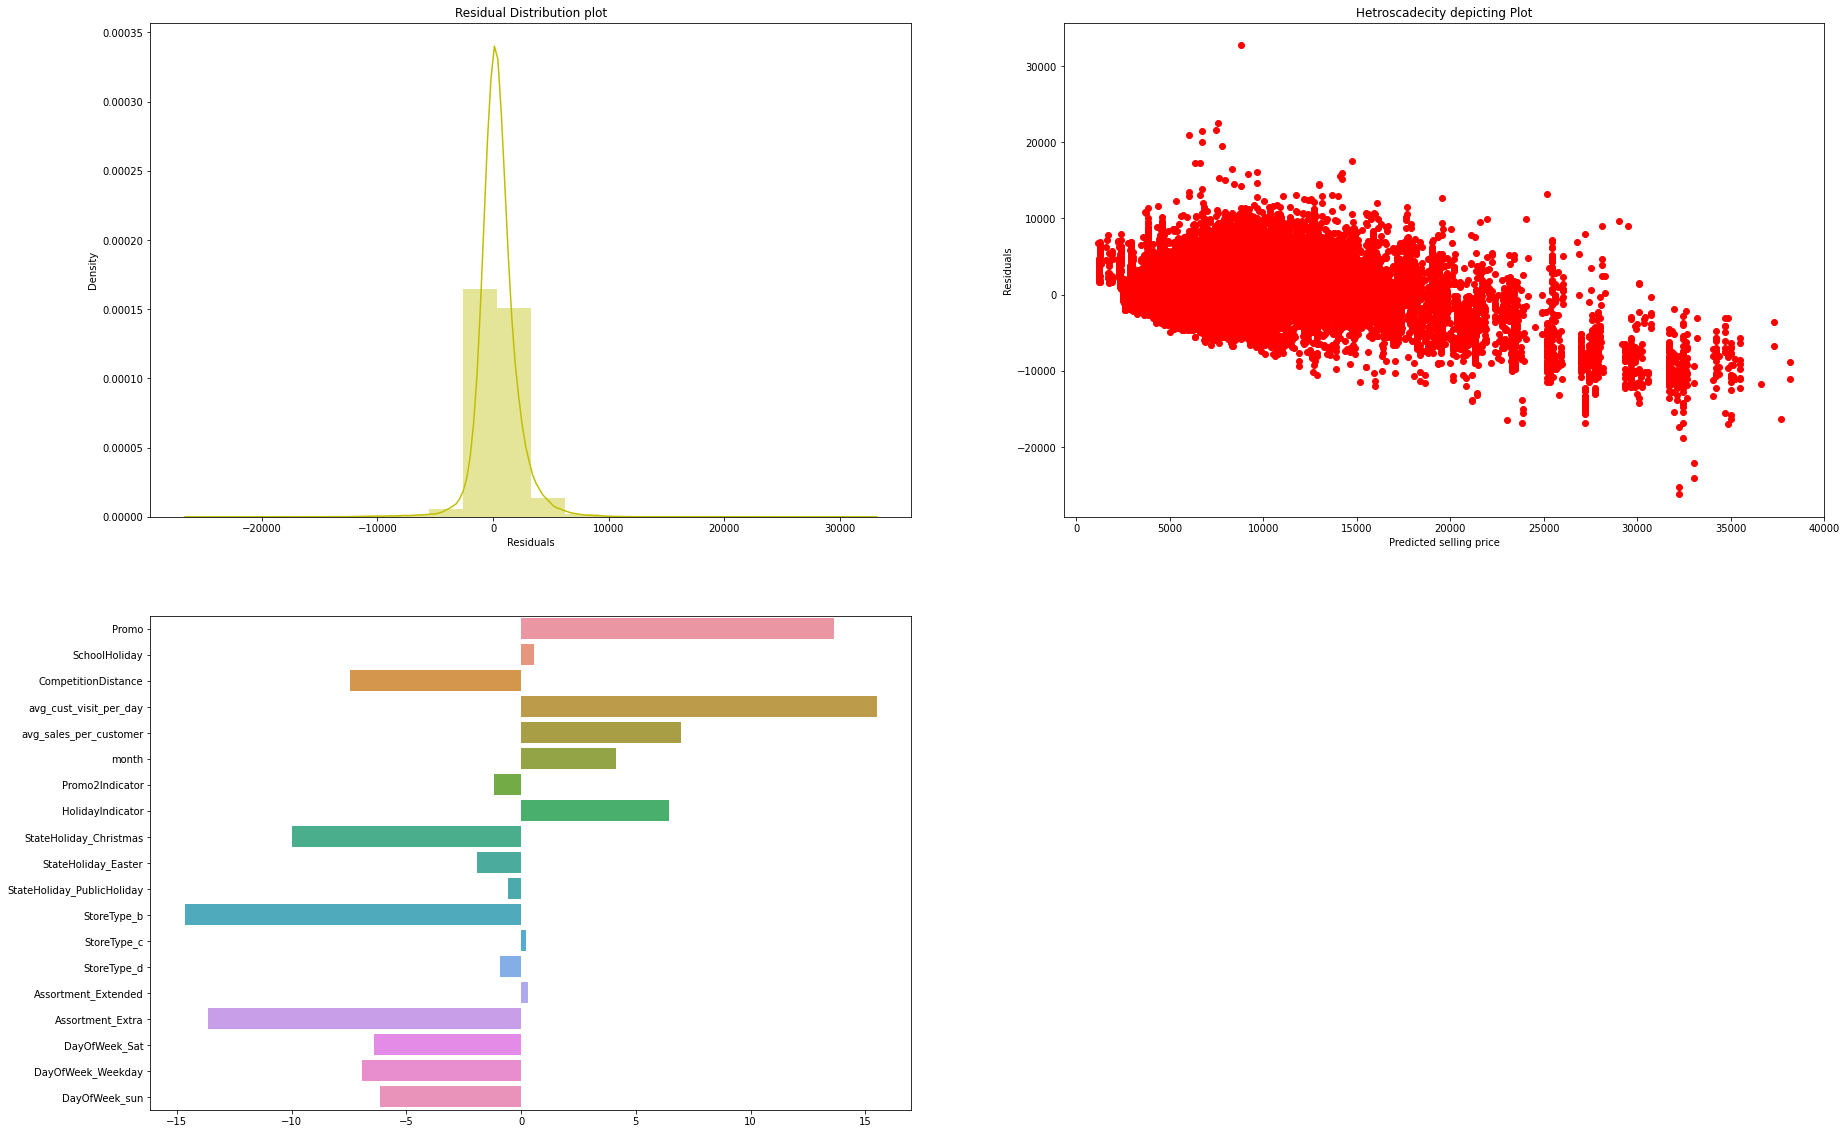

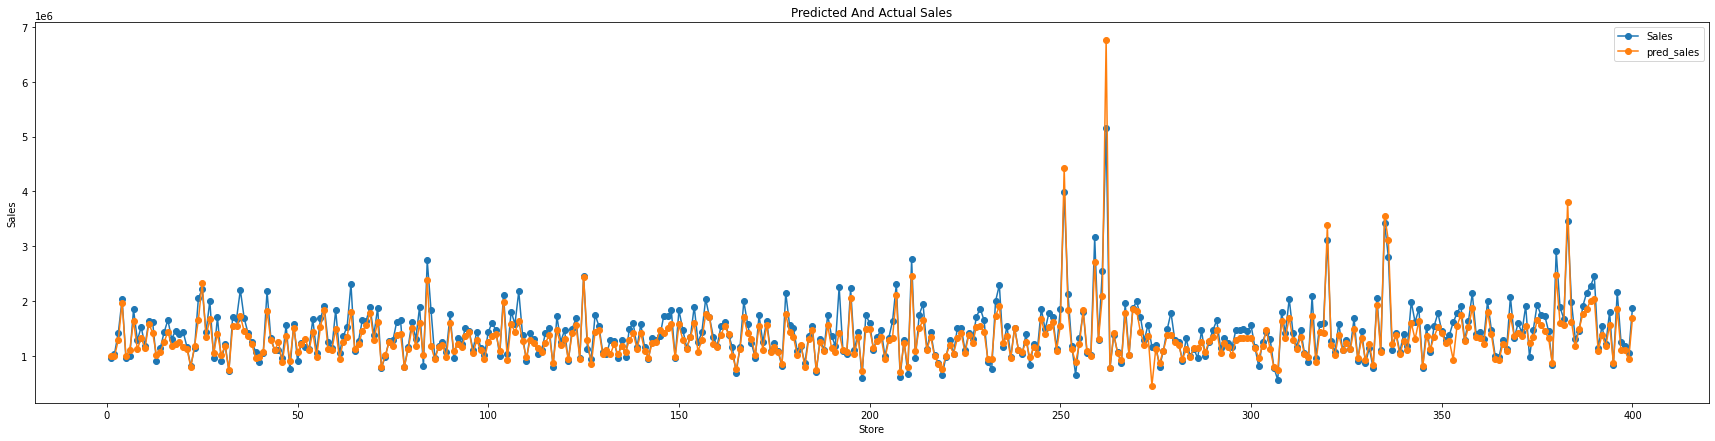

In [154]:
#______________________________Block 119_________________________________________

#hyperparameters dict to tune
start = datetime.datetime.now()
hyperparameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,0.1,0.3,0.6,0.09,1,10]} #alpha values to fine tune
ridge_model = linear_model('ridge',x_regtrain, y_regtrain, hyperparameters)   #applying ridge regression
ridge_model,ridge_score = model_eval(ridge_model,x_regtrain,y_regtrain,x_regtest,y_regtest,'linear')  #model evaluation
cross_val(ridge_model, reg_train_data)   #applying cross validation
end = datetime.datetime.now()
traintime_ridge = (end -start).total_seconds()  #execution time of algorithm 
print('\n Time taken to train and cross validating a model is : ', round(traintime_lr,2), ' Seconds') 

*We built Ridge linear regression model and following points should be noted:*

Following are the Outcomes:

**`1.Training Data R2Score - 0.72`**

**`2. Test Data R2Score - 0.69`**

**`3. Overall cross validation R2Score - 0.74`**

*There is absolutely no difference in basic and Ridge regression that completely indicates that our model is not overfitting*

##*Building Lasso Regression Model*

Best alpha value :  {'alpha': 1e-15}
Best score value for tuned HyperParameter :  0.7351822833150946
Train data score card : 

MSE for a model over train data is :  2616618.03
RMSE for a model over train data is :  1617.6
Mean absolute error for train data is :  1092.76
Root mean square percentage error for train data is :  0.33
R2_score for a model over train data is :  0.72
Adjusted R2_score for a model over train data is : 0.72 

Test data score card : 

MSE for a model over test data is :  3125815.45
RMSE for a model over test data is :  1768.0
Mean absolute error for train data is :  1197.03
Root mean square percentage error for train data is :  0.274
R2_score for a model over test data is :  0.69
Adjusted R2_score for a model over test data is : 0.69 

R2 Scores for cross validated models are :  [0.74144436 0.74043117 0.74112803]

Average r2 score from cross validation for a model is :  0.74

 Time taken to train and cross validating a model is :  4.04  Seconds


<Figure size 576x288 with 0 Axes>

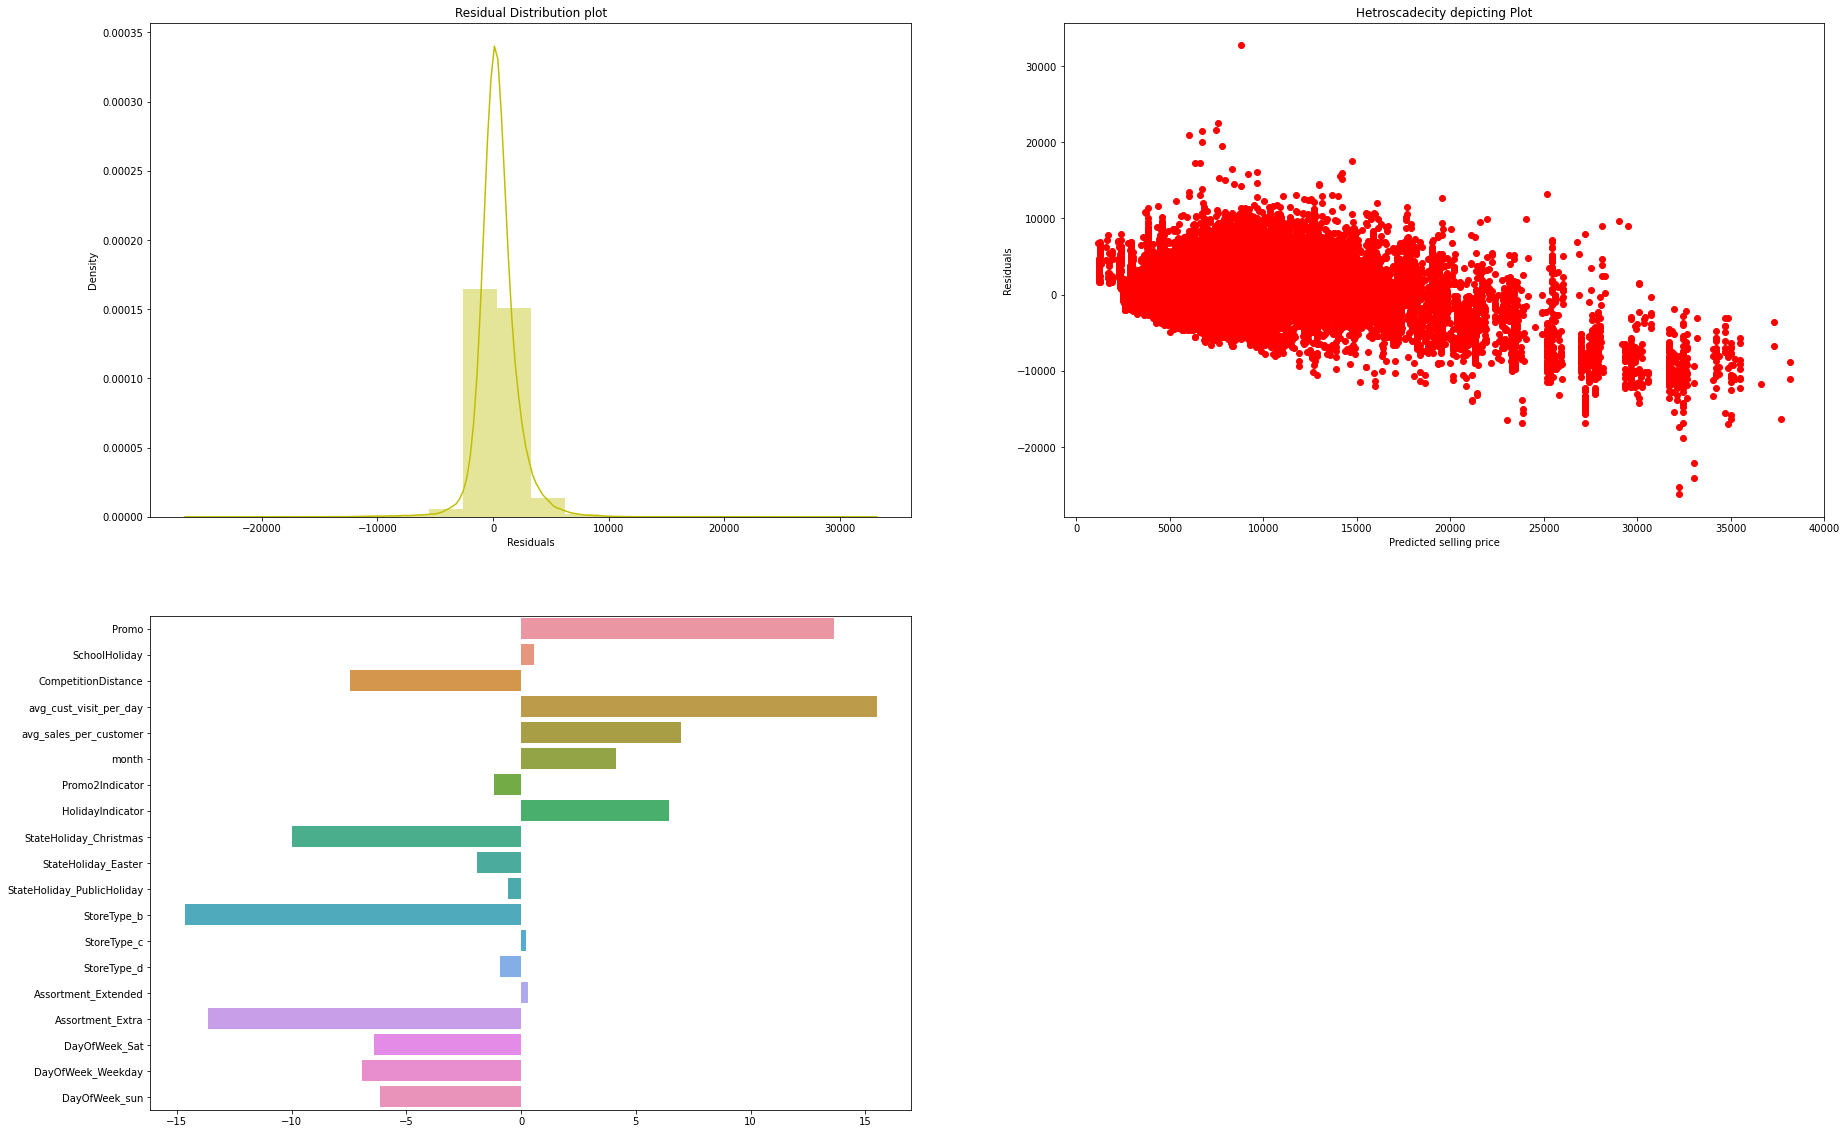

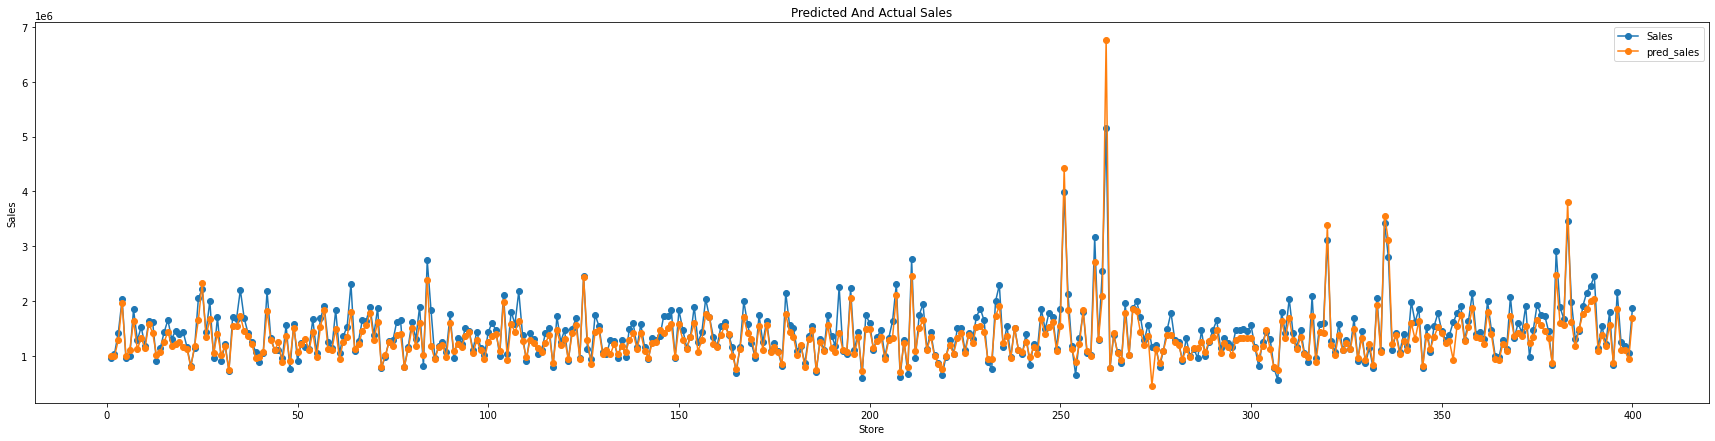

In [155]:
#____________________________________________________Block 120_________________________________________________

start = datetime.datetime.now()
lasso_model = linear_model('lasso',x_regtrain, y_regtrain, hyperparameters)  #applying lasso regression
lasso_model,lasso_score = model_eval(lasso_model,x_regtrain,y_regtrain,x_regtest,y_regtest,'linear')   #evaluating a model
cross_val(lasso_model, reg_train_data)    #cross validating a model
end = datetime.datetime.now()
traintime_lasso = (end - start).total_seconds()  # execution time
print('\n Time taken to train and cross validating a model is : ', round(traintime_lr,2), ' Seconds') 

*We built Lasso linear regression model and following points should be noted:*

Following are the Outcomes:

**`1.Training Data R2Score - 0.72`**

**`2. Test Data R2Score - 0.69`**

**`3. Overall cross validation R2Score - 0.74`**

*There is absolutely no difference in basic, Ridge and lasso regression that completely indicates that our model is not overfitting*

***Outcomes***

*1. Score for all three models(linear, ridge, lasso) are near to similar and doesn't have much difference, it's because ridge and lasso reduces overfitting but if we see the training and test scores of our basic linear model it doesn't seem to be overfit*

*2. Model is getting quite good scores for both training and test data*

*3.But here if we see the residual plot although it is normally distributed it seems to be skewed.*

*4. Also although a hetroscedasticity graph is not completely have a constant variance but also it doesn't shows any pattern at the same time*




# ***Tree Based Models***

## *Creating a copy of our orignal rossman dataset for tree based model*

In [156]:
tree_train_data = train_data.copy()  #copy of data for tree based model
tree_test_data = test_data.copy()

*Columns to drop that are not useful in tree based model*

In [157]:
#list of Columns to drop that are not useful in tree based model
cols_to_drop = ['Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear' ,'Promo2SinceWeek','Promo2SinceYear','PromoInterval',
               'CompetitionOpenSinceDate','Promo2SinceDate','Promo2','Customers',
                'avg_sales_per_day','comp_dist_categories']

In [158]:
#_____________________________________Block 82__________________________________________

#deleting some of the unnecessary columns first from train_data 
tree_train_data.drop(columns=cols_to_drop,inplace= True)
#deleting some of the unnecessary columns first from test data as well 
tree_test_data.drop(columns=cols_to_drop,inplace= True)

*From EDA these features doesn't seems to be useful in our model building*

In [159]:
#_______________________________________________________Block 94____________________________________

encode_features = ['StateHoliday', 'StoreType', 'Assortment']  #features selected for label encoding

In [160]:
#______________________________________________Block 124___________________________________________________

#replacing numerical value to string for labelencoding
tree_train_data['StateHoliday'].replace({0:'0'}, inplace = True)
#tree_train_data['PromoInterval'].replace({0:'0'}, inplace = True)
tree_test_data['StateHoliday'].replace({0:'0'}, inplace = True)
#tree_test_data['PromoInterval'].replace({0:'0'}, inplace = True) 

In [161]:
tree_train_data, tree_test_data = label_encoding(tree_train_data, tree_test_data, encode_features)

*Data seems to be prepared now and we'll begin with different model building*

## *Function designed to apply all tree class model*

In [162]:
#___________________________________Block 126_____________________________________________________

#single function written to apply different tree models to avoid repetitive writing 
def tree_model(predmodel, x, y, hyper_param=None):  
  if predmodel =='dt':
    if hyper_param != None:
      model1= DecisionTreeRegressor()
      #fitting number of random forest model using grid search cv
      grid_model = GridSearchCV(model1, param_grid = dt_hyperparam, n_jobs =-1, scoring = 'r2', cv = 3)
      #fitting these models
      grid_model.fit(x,y)
      #printing best scores and parameters of model that came out of multiple models e build using grid search  
      print('Best parameters for models are : \n', grid_model.best_params_)
      print('\nBest score from a model is : \n', grid_model.best_score_)
      
      #out of all the models from grid search choosing the one that is best 
      model = grid_model.best_estimator_
    else:      
      model = DecisionTreeRegressor()
  
  #random forest model
  elif predmodel == 'rf':
    if hyper_param!=None:  #if hyperparameters are passed then fine tune them
      model1=RandomForestRegressor()
      #fitting number of random forest model using grid search cv
      grid_model = GridSearchCV(model1, param_grid = hyper_param, scoring = 'r2', n_jobs = -1, cv=3)
      #fitting these models
      grid_model.fit(x,y)
      #printing scores and parameters came out of multiple models e build using grid search  
      print('Best parameters for models are : \n', grid_model.best_params_)
      print('\nBest score from a model is : \n', grid_model.best_score_)
      
      #out of all the models from grid search choosing the one that is best 
      model = grid_model.best_estimator_
    else:
      model = RandomForestRegressor()   #building with default parameters for random forest if hyper parameters not passed 
  
  #gradient boost regressor model
  elif predmodel == 'gb':
    if hyper_param!=None:
      model1 = GradientBoostingRegressor()
      
      #fitting number of gradient boost model using grid search cv
      grid_model = GridSearchCV(model1, param_grid = hyper_param, scoring = 'r2', n_jobs = -1, cv=3)
      
      #fitting these models
      grid_model.fit(x,y)

      #printing scores and parameters came out of multiple models e build using grid search  
      print('Best parameters for models are : \n', grid_model.best_params_)
      print('\nBest score from a model is : \n', grid_model.best_score_)
      
      #out of all the models from grid search choosing the one that is best 
      model = grid_model.best_estimator_
    else:
      model = GradientBoostingRegressor()
  
  elif predmodel == 'xgb':
    if hyper_param!=None:
      model1 = XGBRegressor()
      
      #fitting number of gradient boost model using grid search cv
      grid_model = GridSearchCV(model1, param_grid = hyper_param, scoring = 'r2', n_jobs = -1, cv=3)
      
      #fitting these models
      grid_model.fit(x,y)

      #printing scores and parameters came out of multiple models e build using grid search  
      print('Best parameters for models are : \n', grid_model.best_params_)
      print('\nBest score from a model is : \n', grid_model.best_score_)
      
      #out of all the models from grid search choosing the one that is best 
      model = grid_model.best_estimator_
    else:
      model = XGBRegressor()
  return model 

In [163]:
#calling spilt data to split data in x and y for train_data
x_treetrain,y_treetrain = split_data(tree_train_data)
#calling spilt data to split data in x and y for test_data   
x_treetest, y_treetest = split_data(tree_test_data)  

## *Building Decision Tree*

Best parameters for models are : 
 {'max_depth': 12}

Best score from a model is : 
 0.8176498978521044
Train data score card : 

MSE for a model over train data is :  1147633.6
RMSE for a model over train data is :  1071.28
Mean absolute error for train data is :  766.23
Root mean square percentage error for train data is :  0.229
R2_score for a model over train data is :  0.88
Adjusted R2_score for a model over train data is : 0.88 

Test data score card : 

MSE for a model over test data is :  1739286.14
RMSE for a model over test data is :  1318.82
Mean absolute error for train data is :  914.89
Root mean square percentage error for train data is :  0.206
R2_score for a model over test data is :  0.83
Adjusted R2_score for a model over test data is : 0.83 

R2 Scores for cross validated models are :  [0.86496506 0.86654946 0.86552786]

Average r2 score from cross validation for a model is :  0.87
Total time in training and validating the model :  33.75202  Seconds


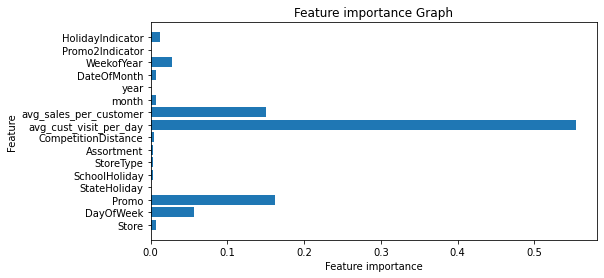

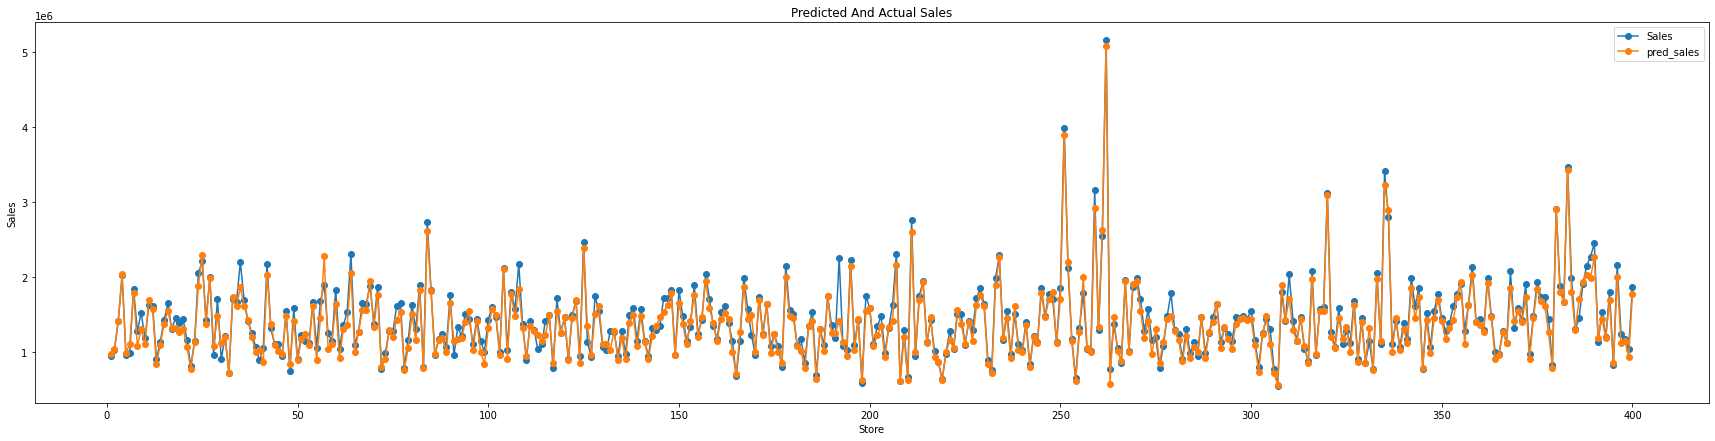

In [164]:
#___________________________________Block 127_______________________________________________________
    
#hyperparameter to tune for decision trees
dt_hyperparam = {'max_depth':[7,8,10,12]}  

#Recording start time before training
start = datetime.datetime.now()  

#for model initialization and finding best hyperparameters
dectree_model = tree_model('dt', x_treetrain, y_treetrain, dt_hyperparam)

#fitting and evaluating best model from grid searchcv
dectree_model,dectree_score = model_eval(dectree_model,x_treetrain,y_treetrain,x_treetest,y_treetest,'tree') 

#cross validating to check performance of model over different dataset to get generalised score
cross_val(dectree_model, tree_train_data)

#recording end time of training
end = datetime.datetime.now()

#calculating net training time
traintime_dtree = (end- start).total_seconds()   
print('Total time in training and validating the model : ', traintime_dtree, ' Seconds')

*We built the decision tree and following are the outcomes :*


**`1.Training Data R2Score -  0.88`**

**`2. Test Data Score - 0.83`**

**`3. Overall cross validation R2Score - 0.87`**


*Note - There are many different subparameters like min_samples_split, max_leaf, min_samples in node , our model alone with the help of max/_depth is performing quite well and doesn't seems to be overfit as well. We have tried along with different combinations performance remains nearby same. It only increases our runtime*

*Thats the reason we only fine tuned the max_depth*

*Also from feature importance graph we can see multiple features are near to of no use as they either have zero or very minute importance in our model building. So we'll try to drop these and build our model then asses the performance*

In [165]:
#building a model explainer and getting explainer and shap train and test
explainer, shap_train, shap_test =  model_explain_build(dectree_model ,x_treetrain, x_treetest)

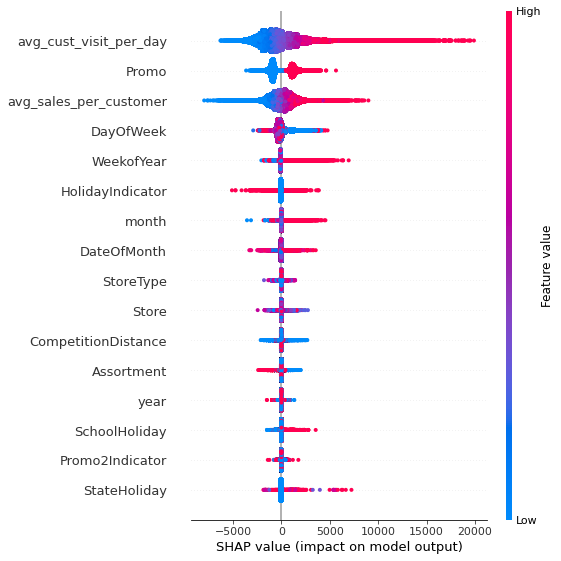

In [166]:
#explaination for data
model_explaination(explainer,x_treetrain, shap_train,data_loc =2, Global=True)

## ***Random Forest***

Best parameters for models are : 
 {'max_depth': 15, 'max_features': 10, 'n_estimators': 60}

Best score from a model is : 
 0.8607440250307984
Train data score card : 

MSE for a model over train data is :  649095.59
RMSE for a model over train data is :  805.66
Mean absolute error for train data is :  572.66
Root mean square percentage error for train data is :  0.202
R2_score for a model over train data is :  0.93
Adjusted R2_score for a model over train data is : 0.93 

Test data score card : 

MSE for a model over test data is :  1200633.07
RMSE for a model over test data is :  1095.73
Mean absolute error for train data is :  760.35
Root mean square percentage error for train data is :  0.166
R2_score for a model over test data is :  0.88
Adjusted R2_score for a model over test data is : 0.88 

R2 Scores for cross validated models are :  [0.91337091 0.91378529 0.91465975]

Average r2 score from cross validation for a model is :  0.91
Total time in training and validating the model

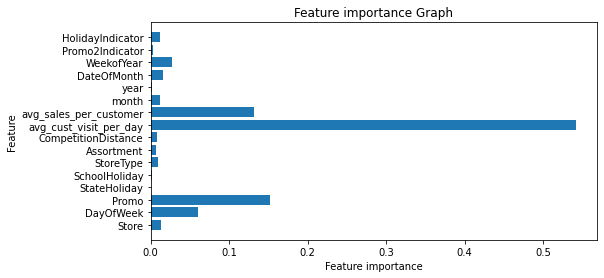

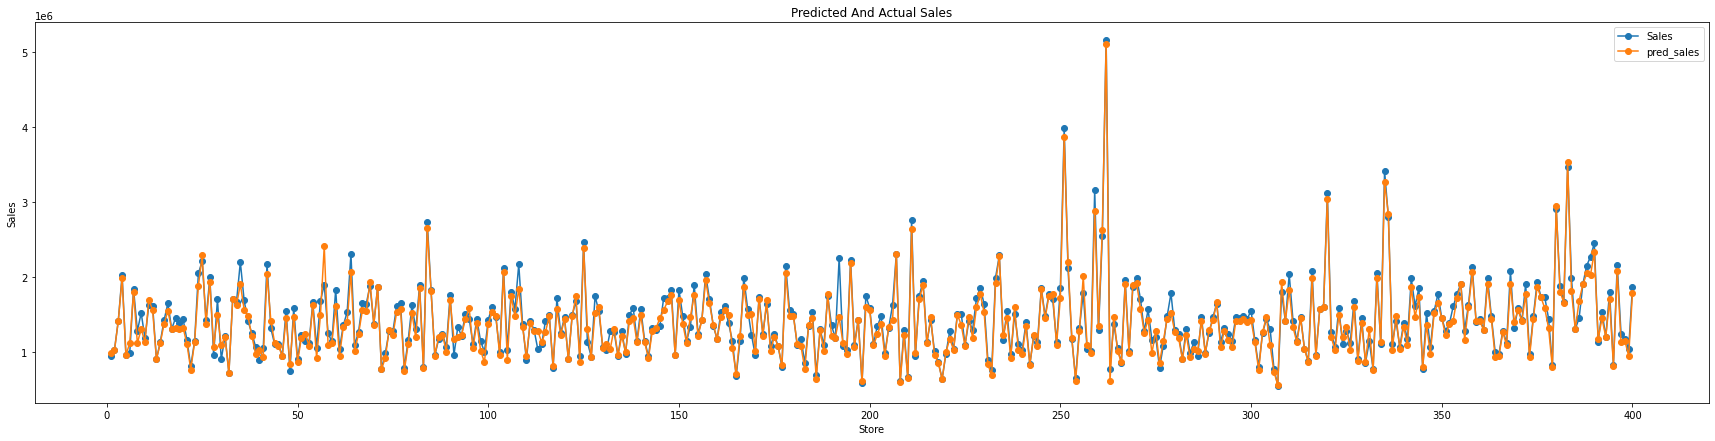

In [167]:
#________________________________________BLOCK 130__________________________________________________

#hyperparameters to tune for random forest
rf_hyperparams = {'n_estimators' : [40,50,60], 'max_depth' : [12,15], 'max_features' : [10,12]}  

#recording training time at start 
start = datetime.datetime.now()

#for model initialization and finding best hyperparameters
rf_model = tree_model('rf', x_treetrain, y_treetrain, rf_hyperparams)   

#fitting and evaluating best model from grid searchcv
rf_model,rf_score = model_eval(rf_model,x_treetrain,y_treetrain,x_treetest,y_treetest,'tree')

#cross validating to check performance of model over different dataset to get generalised score
cross_val(rf_model, tree_train_data)

#recording end training time
end = datetime.datetime.now()

#calculating net training time
traintime_rf = (end-start).total_seconds()
print('Total time in training and validating the model : ', traintime_rf, ' Seconds') 

*We built the decision tree and following are the outcomes :*


**`1.Training Data R2Score -  0.93`**

**`2. Test Data Score - 0.88`**

**`3. Overall cross validation R2Score - 0.91`**

*Random Forest is giving quite a good performance and doesn't overfit as well. But if we compare our model performance with Decision tree its quite similar.*

*Reason is that we have fairly simple model and also an ample amount of data to train. That doesn't leading to a problem of overfitting. As a result of which there is not much difference between both models*

*Note - I have tried with different estimators as well. Model seems to get converged with these number of estimators*

## ***Gradient Boost Regression***

Best parameters for models are : 
 {'learning_rate': 0.6, 'n_estimators': 600, 'subsample': 0.8}

Best score from a model is : 
 0.8461929137917515
Train data score card : 

MSE for a model over train data is :  822867.45
RMSE for a model over train data is :  907.12
Mean absolute error for train data is :  637.24
Root mean square percentage error for train data is :  0.237
R2_score for a model over train data is :  0.91
Adjusted R2_score for a model over train data is : 0.91 

Test data score card : 

MSE for a model over test data is :  1454033.67
RMSE for a model over test data is :  1205.83
Mean absolute error for train data is :  861.11
Root mean square percentage error for train data is :  0.191
R2_score for a model over test data is :  0.86
Adjusted R2_score for a model over test data is : 0.86 

R2 Scores for cross validated models are :  [0.90943406 0.90927595 0.91235627]

Average r2 score from cross validation for a model is :  0.91
Total time in training and validating the m

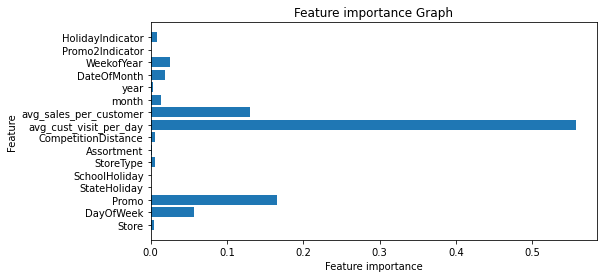

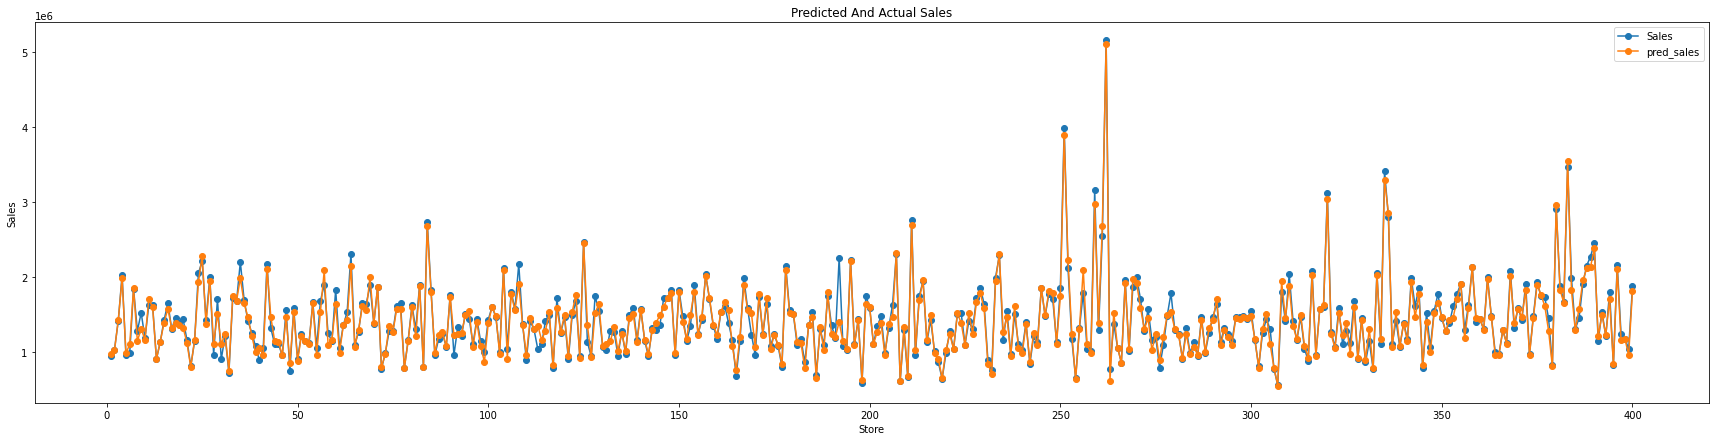

In [168]:
#_________________________________________BLOCK 131________________________________________

#hyperparameter to tune for Gradient Boost Regression 
hyper_param_gb = {'learning_rate':[0.1,0.3, 0.6], 'n_estimators' : [200,400,600],'subsample' : [0.7,0.8, 0.9]}  

#recording training time at start 
start = datetime.datetime.now()

#for model initialization and finding best hyperparameters
gb_model = tree_model('gb',x_treetrain,y_treetrain, hyper_param_gb)

#fitting and evaluating best model from grid searchcv
gb_model,gb_score = model_eval(gb_model,x_treetrain,y_treetrain,x_treetest,y_treetest,'tree')

#cross validating to check performance of model over different dataset to get generalised score
cross_val(gb_model, tree_train_data) 

#recording end training time
end = datetime.datetime.now()

#net training time of algorithm
traintime_gb = (end - start).total_seconds()  
print('Total time in training and validating the model : ', traintime_gb, ' Seconds')

*We built the decision tree and following are the outcomes :*


**`1.Training Data R2Score -  0.90`**

**`2. Test Data Score - 0.86`**

**`3. Overall cross validation R2Score - 0.90`**

*We are getting the test accuracy of 86% in gradient boost which is 2% higher as compared to the random forest but it's coming on the cost of increased training time* 

*Random Forest is executing 24 times faster as compared to the Gradient Boost*

## ***XGBoost***

Best parameters for models are : 
 {'learning_rate': 0.1, 'n_estimators': 600, 'subsample': 0.8}

Best score from a model is : 
 0.8665526274909255
Train data score card : 

MSE for a model over train data is :  582192.77
RMSE for a model over train data is :  763.02
Mean absolute error for train data is :  533.7
Root mean square percentage error for train data is :  0.213
R2_score for a model over train data is :  0.94
Adjusted R2_score for a model over train data is : 0.94 

Test data score card : 

MSE for a model over test data is :  1121840.13
RMSE for a model over test data is :  1059.17
Mean absolute error for train data is :  752.12
Root mean square percentage error for train data is :  0.174
R2_score for a model over test data is :  0.89
Adjusted R2_score for a model over test data is : 0.89 

R2 Scores for cross validated models are :  [0.93348371 0.93397728 0.93464239]

Average r2 score from cross validation for a model is :  0.93
Total time in training and validating the mo

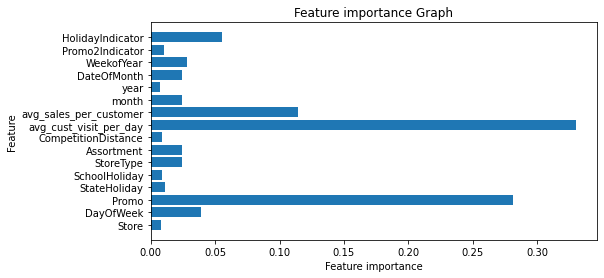

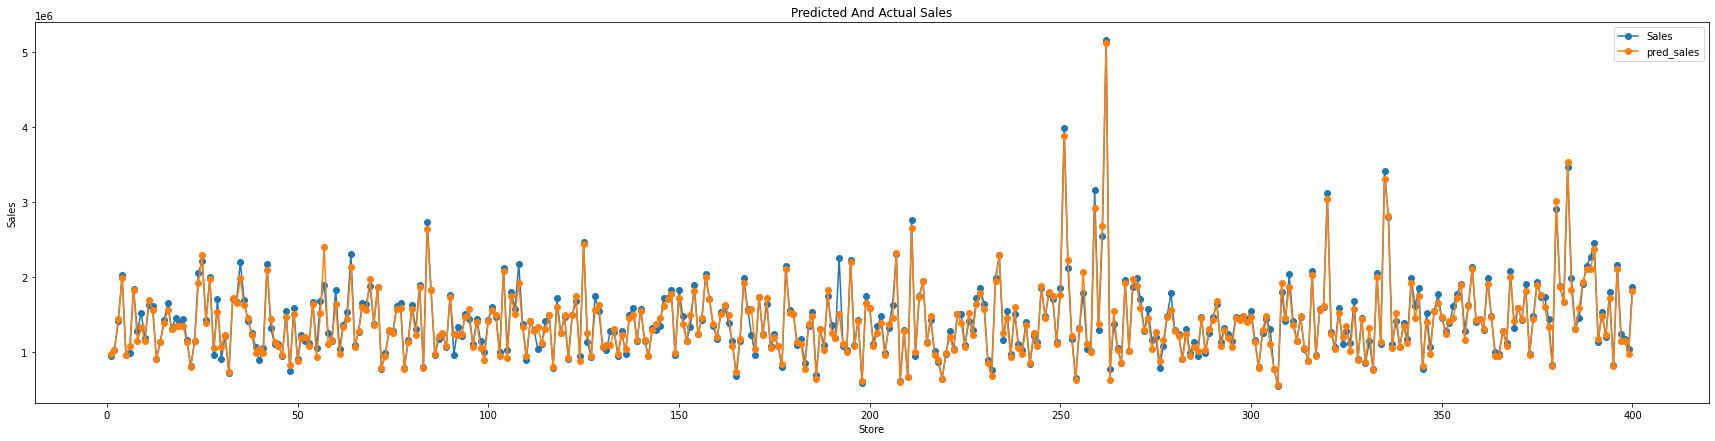

In [169]:
#__________________________________BLOCK 132_________________________________________________

#hyperparameter to tune for Gradient Boost Regression 
hyper_param_xgb = {'learning_rate':[0.1,0.3], 'n_estimators' : [200, 400, 600],'subsample' : [0.8]}

#recording training time at start 
start = datetime.datetime.now()

#for model initialization and finding best hyperparameters
xgb_model = tree_model('xgb',x_treetrain,y_treetrain, hyper_param_xgb)

#fitting and evaluating best model from grid searchcv
xgb_model,xgb_score = model_eval(xgb_model,x_treetrain,y_treetrain,x_treetest,y_treetest,'tree')

#cross validating to check performance of model over different dataset to get generalised score
cross_val(xgb_model, tree_train_data)

#recording end training time
end = datetime.datetime.now()

#training time of algorithm
traintime_xgb = (end - start).total_seconds()   
print('Total time in training and validating the model : ', traintime_xgb, ' Seconds')

*We built the decision tree and following are the outcomes :*


**`1.Training Data R2Score -  0.96`**

**`2. Test Data Score - 0.94`**

**`3. Overall cross validation R2Score - 0.96`**


*Gradient Boost and XG Boost are performing same on the scale of performance metrices the only advantage is the execution time which is nearly 3 times faster than Gradient boost*

# ***Comparing model performances***

In [170]:
#_________________________________________BLOCK 133_____________________________________________________

#scoring different scores of each model in dictionary
score_metrics = {'LinearRegression':lr_score, 'LassoRegression':lasso_score, 'Ridge_Regression':ridge_score,
                 'DecisionTrees' : dectree_score, 'RandomForest':rf_score, 'GradientBoost': gb_score, 'XtremeGradientBoost': xgb_score}

#scoring execution time of different models in a dictionary 
time_metrics ={'LinearRegression':traintime_lr, 'LassoRegression' : traintime_lasso, 'Ridge_Regression':traintime_ridge, 'DecisionTrees':traintime_dtree, 
               'RandomForest':traintime_rf, 'GradientBoost':traintime_gb, 'XtremeGradientBoost':traintime_xgb }

In [171]:
#__________________________________________BLOCK 134_______________________________________________________

#converting dictionaries in data frame and series

score_metrics = pd.DataFrame(score_metrics)
time_metrics = pd.Series(time_metrics)

In [172]:
#_________________________________________________BLOCK 135__________________________________________________

# concatenating time metrics with score metrics
score_metrics.loc["execution_time"]=time_metrics
score_metrics

LinearRegression  LassoRegression  \
Mean Square Error                      3.125815e+06     3.125815e+06   
Root Mean Square Error                 1.768000e+03     1.768000e+03   
Mean Absolute Error                    1.197030e+03     1.197030e+03   
Root Mean Square Percentage Error      2.740000e-01     2.740000e-01   
R2 Score                               6.900000e-01     6.900000e-01   
Adjusted R2 Score                      6.900000e-01     6.900000e-01   
execution_time                         4.035925e+00     3.474557e+02   

                                   Ridge_Regression  DecisionTrees  \
Mean Square Error                      3.125815e+06   1.739286e+06   
Root Mean Square Error                 1.768000e+03   1.318820e+03   
Mean Absolute Error                    1.197030e+03   9.148900e+02   
Root Mean Square Percentage Error      2.740000e-01   2.060000e-01   
R2 Score                               6.900000e-01   8.300000e-01   
Adjusted R2 Score                      6.900000e-01   8.300000e-01   
execution_time                         1.807434e+01   3.375202e+01   

                                   RandomForest  GradientBoost  \
Mean Square Error                  1.200633e+06   1.454034e+06   
Root Mean Square Error             1.095730e+03   1.205830e+03   
Mean Absolute Error                7.603500e+02   8.611100e+02   
Root Mean Square Percentage Error  1.660000e-01   1.910000e-01   
R2 Score                           8.800000e-01   8.600000e-01   
Adjusted R2 Score                  8.800000e-01   8.600000e-01   
execution_time                     2.104273e+03   1.765772e+04   

                                   XtremeGradientBoost  
Mean Square Error                         1.121840e+06  
Root Mean Square Error                    1.059170e+03  
Mean Absolute Error                       7.521200e+02  
Root Mean Square Percentage Error         1.740000e-01  
R2 Score                                  8.900000e-01  
Adjusted R2 Score                         8.900000e-01  
execution_time                            6.277838e+03

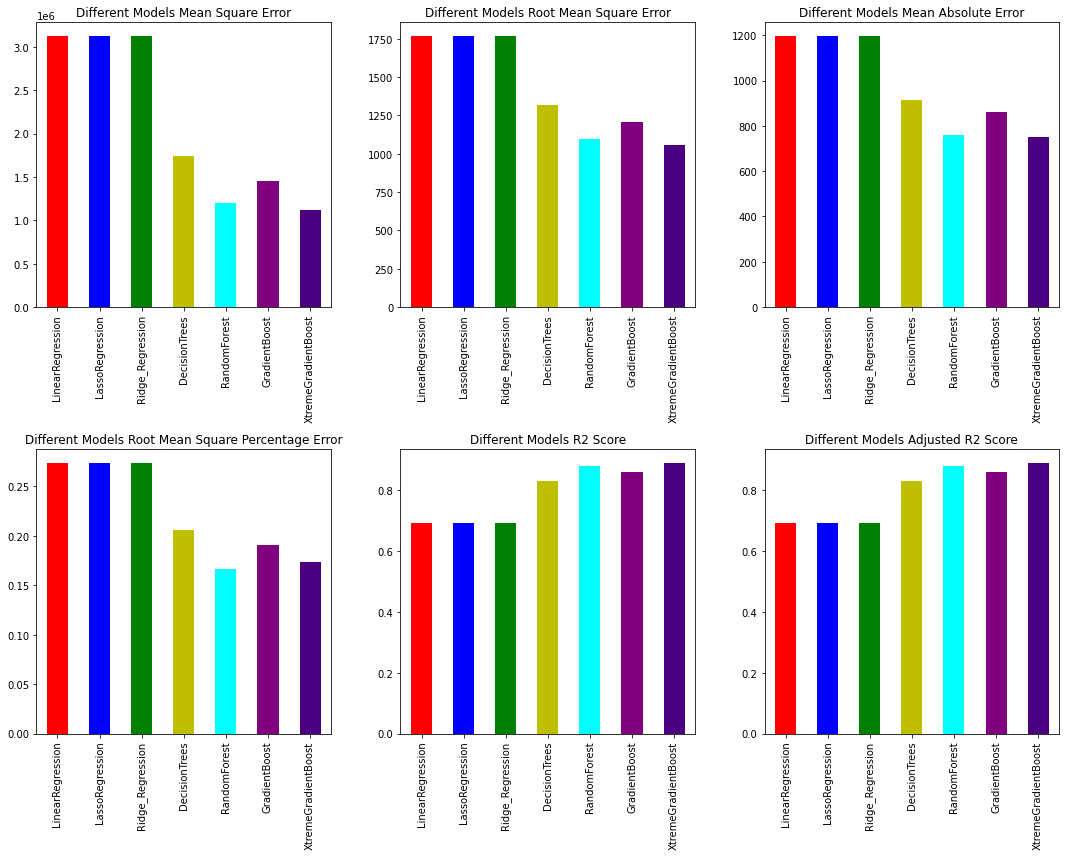

In [173]:
#____________________________________________________BLOCK 136____________________________________

#visualising different score metrics for different models

fig, axes = plt.subplots(2,3,figsize=(15,12))
k =0     #create for indexing title

#different colors to represent different model
colours=['r','b','g','y','cyan','purple','indigo']

#running a nested for loop to plot each score_metric graph
for i in range(2):
  for j in range(3):
    #plotting a bar for each type scores of different models
    ax = score_metrics.iloc[k].plot.bar(ax = axes[i][j],color=colours)

    #setting up title for each graph 
    ax.set_title("Different Models "+str(score_metrics.iloc[k].name))
    k = k+1
    
fig.tight_layout()

*From the visual analysis of various performance metrics of different models, we can see although gradient boost and xtreme gradient boost are giving us a great performance but at the cost of execution time.*

*So `if there is no kind of incremental modelling and we can just train the model once and store it then we can go with Gradient boost or Xtreme gradient boost`*



# ***Final model selection and saving***

In [174]:
#________________________________________________Block 137____________________________________________________

#importing pickle module to save the model so that it can be used later directly for prediction without retraining 
import pickle

#path to save the model 
store_path   = '/content/drive/MyDrive/Rossman sales prediction/'

#changing current directory to mydrive
%cd /content/drive/MyDrive/

#name by which it needs to be saved in drive
name_file = 'rossman_sales_predictor.pkl'

/content/drive/MyDrive


In [175]:
#_____________________________________Block 138_________________________________________

#selecting XGB as our final model
final_model = xgb_model

#dumping a model to drive
pickle.dump(final_model, open(name_file, 'wb'))

*This pickle file will be used in model deployement*

# ***Thank You***